In [1]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import pandas as pd
import eipy.ei as e

In [2]:
from eipy.metrics import fmax_score
from sklearn.metrics import roc_auc_score, matthews_corrcoef

metrics = {
            'f_max': fmax_score,
            'auc': roc_auc_score,
            'mcc': matthews_corrcoef
            }

In [3]:
base_predictors = {
                    'ADAB': AdaBoostClassifier(),
                    'XGB': XGBClassifier(),
                    'DT': DecisionTreeClassifier(),
                    'RF': RandomForestClassifier(),
                    'GB': GradientBoostingClassifier(),
                    'KNN': KNeighborsClassifier(),
                    'LR': LogisticRegression(),
                    'NB': GaussianNB(),
                    'MLP': MLPClassifier(),
                    'SVM': SVC(probability=True),
}

In [4]:
import pickle as pkl
with open("/home/opc/eipy/tadpole/tadpole_data_time_imptn_norm_v1.pickle", "rb") as file:
    data = pkl.load(file)
with open("/home/opc/eipy/tadpole/tadpole_labels_time_imptn_norm_v1.pickle", "rb") as file:
    labels = pkl.load(file)

In [5]:
data = [data[k] for k in data.keys()]

In [6]:
for k,v in labels.items():
    labels[k] = v.reset_index(drop=True)

In [7]:
#intermediate transformation to make sure labels are ordered correctly in time
labels = pd.DataFrame(labels)

labels = labels.to_numpy()

In [8]:
import numpy as np
encoding_dict = {'NL': 0, 'MCI': 1, 'Dementia': 2}

# Use numpy.vectorize with a lambda function to apply the encoding
labels = np.vectorize(lambda x: encoding_dict[x])(labels)

In [9]:
'''data misalignment'''
data=data[:-1]
labels = labels[:,1:]

In [10]:
for i in range(labels.shape[-1]):
    print(pd.Series(labels[:,i]).value_counts())

1    480
0    195
2     27
Name: count, dtype: int64
1    451
0    192
2     59
Name: count, dtype: int64
1    378
0    188
2    136
Name: count, dtype: int64
1    348
2    178
0    176
Name: count, dtype: int64


In [11]:
'''x patients have dementia 0 times in their label sequence,
 y patients have dementia once in their label sequence...'''
dem_freq = np.sum(labels == 2, axis=1)
pd.Series(dem_freq).value_counts()

0    378
1    250
2     72
3      2
Name: count, dtype: int64

In [12]:
'''how many patients get dementia at some point'''
np.any(labels == 2, axis=1).sum()

324

In [13]:
'''data split to validate hyper-parameter tuning'''
data_train = []
data_test = []
labels_train = []
labels_test = []

from sklearn.model_selection import train_test_split
for i in range(len(data)):
    print("hi")


hi
hi
hi
hi


In [14]:
####HI OVER HERE###
import importlib
importlib.reload(e)
###HEYOOOOOO#

<module 'eipy.ei' from '/home/opc/eipy/eipy/ei.py'>

In [15]:
outer_folds = 5

In [16]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

meta_data = []
for t in range(len(data)):
    #time dependent data splitting
    X_train_timestep = data[t]
    labels_at_timestep = labels[:, t]
    EI_for_timestep = e.EnsembleIntegration(
                        base_predictors=base_predictors,
                        k_outer=outer_folds,
                        k_inner=5,
                        n_samples=1,
                        sampling_strategy=None, #to compare to lstm. go back to oversampling after
                        sampling_aggregation="mean",
                        n_jobs=-1,
                        metrics=metrics,
                        random_state=38,
                        project_name=f"time step {t}",
                        verbose=0,
                        model_building=False,
                        )
    print(f"generating metadata for timestep {t}")
    EI_for_timestep.final_label_frequency = dem_freq
    EI_for_timestep.fit_base(X_train_timestep, labels_at_timestep)
    meta_data.append([EI_for_timestep.ensemble_training_data, EI_for_timestep.ensemble_test_data, EI_for_timestep.ensemble_training_data_final, EI_for_timestep.base_summary])

warnings.filterwarnings("default", category=UserWarning)

generating metadata for timestep 0
Training base predictors on Main cognitive tests...
        
... for ensemble performance analysis...


Generating ensemble training data: |          |  0%

[  0   1   2   3   4   5   6   7   8  10  11  13  14  15  17  18  19  20
  21  22  24  25  26  27  28  29  30  31  32  34  36  38  39  40  41  42
  43  44  45  46  47  49  50  51  52  53  54  55  57  59  61  62  63  64
  65  66  67  68  69  71  72  74  75  76  77  78  79  80  81  82  83  84
  85  86  87  88  89  92  94  95  96  99 100 102 103 104 105 106 108 110
 111 112 113 114 115 116 117 118 119 120 121 122 123 125 127 128 129 130
 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148
 149 150 151 152 153 154 155 156 157 159 160 162 163 164 166 167 169 170
 171 172 173 174 175 176 177 178 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 197 198 200 201 202 203 205 206 207 210 211 212
 214 215 219 221 223 225 226 228 229 231 232 233 235 236 237 238 239 240
 243 244 245 246 247 249 250 252 253 254 255 256 257 258 259 260 262 263
 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281
 282 284 287 289 290 292 293 294 295 296 297 298 29

Generating ensemble training data: |██        | 20%

[  1   3   4   5   6   8   9  10  12  13  15  16  17  18  22  23  24  26
  27  28  29  30  31  32  33  34  35  36  37  40  41  42  43  45  46  47
  48  49  50  51  52  54  55  56  58  59  60  61  62  63  64  65  66  67
  70  71  73  74  75  76  77  78  80  81  82  83  84  85  86  90  91  92
  93  95  96  97  98 100 101 102 103 104 105 106 107 109 110 111 112 113
 114 117 118 119 122 123 124 126 127 128 129 130 131 132 133 134 135 136
 137 138 140 141 143 144 145 146 147 148 149 150 151 152 153 154 156 157
 158 159 160 161 162 163 164 165 167 168 169 170 171 172 175 176 178 179
 180 182 184 185 187 189 191 192 193 194 195 196 197 198 199 200 203 204
 205 207 208 209 210 212 213 214 215 216 217 218 219 220 221 222 224 225
 226 227 229 230 231 232 233 234 235 236 237 238 239 240 241 242 244 245
 246 247 248 249 250 251 252 253 255 258 259 260 261 263 264 265 266 267
 269 271 272 273 274 275 276 277 279 280 281 283 284 285 286 288 289 290
 291 292 293 294 296 298 300 301 302 303 305 306 30

Generating ensemble training data: |████      | 40%

[  0   1   2   3   4   5   6   7   8   9  10  11  12  14  15  16  18  19
  20  21  22  23  24  25  26  27  28  31  32  33  35  37  38  39  42  44
  45  46  48  49  52  53  54  56  57  58  59  60  63  64  67  68  69  70
  72  73  74  76  77  78  79  80  82  83  85  86  87  88  89  90  91  92
  93  94  95  97  98  99 100 101 105 106 107 108 109 110 111 112 113 114
 115 116 117 120 121 124 125 126 127 128 129 130 132 134 135 138 139 140
 141 142 143 146 147 148 149 151 152 153 155 157 158 160 161 162 164 165
 166 167 168 169 171 172 173 174 176 177 178 179 181 182 183 184 186 188
 189 190 196 199 200 201 202 204 206 207 208 209 210 211 212 213 214 216
 217 218 219 220 222 223 224 225 226 227 228 229 230 232 234 237 238 239
 240 241 242 243 245 247 248 249 251 252 253 254 255 256 257 261 262 263
 264 265 266 267 268 269 270 271 274 275 277 278 279 280 282 283 284 285
 286 287 288 289 290 291 292 293 295 296 297 298 299 300 301 303 304 307
 308 310 312 313 314 315 316 317 318 319 320 321 32

Generating ensemble training data: |██████    | 60%

[  0   1   2   3   4   7   9  10  11  12  13  14  16  17  19  20  21  22
  23  24  25  26  27  29  30  31  33  34  35  36  37  38  39  40  41  43
  44  46  47  48  49  50  51  52  53  55  56  57  58  59  60  61  62  63
  64  65  66  67  68  69  70  71  72  73  75  76  77  79  81  82  84  85
  87  88  89  90  91  93  94  95  96  97  98  99 100 101 102 103 104 105
 107 108 109 111 112 113 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 136 137 139 141 142 143 144 145 146 147 148
 149 150 154 155 156 158 159 160 161 162 163 165 166 168 170 171 173 174
 175 177 179 180 181 182 183 185 186 187 188 189 190 191 192 193 194 195
 196 197 198 199 200 201 202 203 204 205 206 207 208 209 211 213 215 216
 217 218 219 220 221 222 223 224 225 227 228 230 231 233 234 235 236 237
 239 240 241 242 243 244 245 246 248 250 251 252 253 254 255 256 257 258
 259 260 261 262 263 264 265 268 270 271 272 273 276 277 278 279 280 281
 282 283 284 285 286 287 288 289 291 294 295 297 29

Generating ensemble training data: |████████  | 80%

[  0   2   5   6   7   8   9  11  12  13  14  15  16  17  18  19  20  21
  23  25  28  29  30  32  33  34  35  36  37  38  39  40  41  42  43  44
  45  47  48  50  51  53  54  55  56  57  58  60  61  62  65  66  68  69
  70  71  72  73  74  75  78  79  80  81  83  84  86  87  88  89  90  91
  92  93  94  96  97  98  99 101 102 103 104 106 107 108 109 110 114 115
 116 118 119 120 121 122 123 124 125 126 131 133 134 135 136 137 138 139
 140 142 144 145 150 151 152 153 154 155 156 157 158 159 161 163 164 165
 166 167 168 169 170 172 173 174 175 176 177 178 179 180 181 183 184 185
 186 187 188 190 191 192 193 194 195 196 197 198 199 201 202 203 204 205
 206 208 209 210 211 212 213 214 215 216 217 218 220 221 222 223 224 226
 227 228 229 230 231 232 233 234 235 236 238 241 242 243 244 246 247 248
 249 250 251 254 256 257 258 259 260 261 262 266 267 268 269 270 272 273
 274 275 276 278 281 282 283 285 286 287 288 290 291 292 293 294 295 296
 297 299 300 301 302 303 304 305 306 307 308 309 31

Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%




Training base predictors on MRI volumes...
        
... for ensemble performance analysis...


Generating ensemble training data: |          |  0%

[  0   1   2   3   4   5   6   7   8  10  11  13  14  15  17  18  19  20
  21  22  24  25  26  27  28  29  30  31  32  34  36  38  39  40  41  42
  43  44  45  46  47  49  50  51  52  53  54  55  57  59  61  62  63  64
  65  66  67  68  69  71  72  74  75  76  77  78  79  80  81  82  83  84
  85  86  87  88  89  92  94  95  96  99 100 102 103 104 105 106 108 110
 111 112 113 114 115 116 117 118 119 120 121 122 123 125 127 128 129 130
 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148
 149 150 151 152 153 154 155 156 157 159 160 162 163 164 166 167 169 170
 171 172 173 174 175 176 177 178 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 197 198 200 201 202 203 205 206 207 210 211 212
 214 215 219 221 223 225 226 228 229 231 232 233 235 236 237 238 239 240
 243 244 245 246 247 249 250 252 253 254 255 256 257 258 259 260 262 263
 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281
 282 284 287 289 290 292 293 294 295 296 297 298 29

Generating ensemble training data: |██        | 20%

[  1   3   4   5   6   8   9  10  12  13  15  16  17  18  22  23  24  26
  27  28  29  30  31  32  33  34  35  36  37  40  41  42  43  45  46  47
  48  49  50  51  52  54  55  56  58  59  60  61  62  63  64  65  66  67
  70  71  73  74  75  76  77  78  80  81  82  83  84  85  86  90  91  92
  93  95  96  97  98 100 101 102 103 104 105 106 107 109 110 111 112 113
 114 117 118 119 122 123 124 126 127 128 129 130 131 132 133 134 135 136
 137 138 140 141 143 144 145 146 147 148 149 150 151 152 153 154 156 157
 158 159 160 161 162 163 164 165 167 168 169 170 171 172 175 176 178 179
 180 182 184 185 187 189 191 192 193 194 195 196 197 198 199 200 203 204
 205 207 208 209 210 212 213 214 215 216 217 218 219 220 221 222 224 225
 226 227 229 230 231 232 233 234 235 236 237 238 239 240 241 242 244 245
 246 247 248 249 250 251 252 253 255 258 259 260 261 263 264 265 266 267
 269 271 272 273 274 275 276 277 279 280 281 283 284 285 286 288 289 290
 291 292 293 294 296 298 300 301 302 303 305 306 30

Generating ensemble training data: |████      | 40%

[  0   1   2   3   4   5   6   7   8   9  10  11  12  14  15  16  18  19
  20  21  22  23  24  25  26  27  28  31  32  33  35  37  38  39  42  44
  45  46  48  49  52  53  54  56  57  58  59  60  63  64  67  68  69  70
  72  73  74  76  77  78  79  80  82  83  85  86  87  88  89  90  91  92
  93  94  95  97  98  99 100 101 105 106 107 108 109 110 111 112 113 114
 115 116 117 120 121 124 125 126 127 128 129 130 132 134 135 138 139 140
 141 142 143 146 147 148 149 151 152 153 155 157 158 160 161 162 164 165
 166 167 168 169 171 172 173 174 176 177 178 179 181 182 183 184 186 188
 189 190 196 199 200 201 202 204 206 207 208 209 210 211 212 213 214 216
 217 218 219 220 222 223 224 225 226 227 228 229 230 232 234 237 238 239
 240 241 242 243 245 247 248 249 251 252 253 254 255 256 257 261 262 263
 264 265 266 267 268 269 270 271 274 275 277 278 279 280 282 283 284 285
 286 287 288 289 290 291 292 293 295 296 297 298 299 300 301 303 304 307
 308 310 312 313 314 315 316 317 318 319 320 321 32

Generating ensemble training data: |██████    | 60%

[  0   1   2   3   4   7   9  10  11  12  13  14  16  17  19  20  21  22
  23  24  25  26  27  29  30  31  33  34  35  36  37  38  39  40  41  43
  44  46  47  48  49  50  51  52  53  55  56  57  58  59  60  61  62  63
  64  65  66  67  68  69  70  71  72  73  75  76  77  79  81  82  84  85
  87  88  89  90  91  93  94  95  96  97  98  99 100 101 102 103 104 105
 107 108 109 111 112 113 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 136 137 139 141 142 143 144 145 146 147 148
 149 150 154 155 156 158 159 160 161 162 163 165 166 168 170 171 173 174
 175 177 179 180 181 182 183 185 186 187 188 189 190 191 192 193 194 195
 196 197 198 199 200 201 202 203 204 205 206 207 208 209 211 213 215 216
 217 218 219 220 221 222 223 224 225 227 228 230 231 233 234 235 236 237
 239 240 241 242 243 244 245 246 248 250 251 252 253 254 255 256 257 258
 259 260 261 262 263 264 265 268 270 271 272 273 276 277 278 279 280 281
 282 283 284 285 286 287 288 289 291 294 295 297 29

Generating ensemble training data: |████████  | 80%

[  0   2   5   6   7   8   9  11  12  13  14  15  16  17  18  19  20  21
  23  25  28  29  30  32  33  34  35  36  37  38  39  40  41  42  43  44
  45  47  48  50  51  53  54  55  56  57  58  60  61  62  65  66  68  69
  70  71  72  73  74  75  78  79  80  81  83  84  86  87  88  89  90  91
  92  93  94  96  97  98  99 101 102 103 104 106 107 108 109 110 114 115
 116 118 119 120 121 122 123 124 125 126 131 133 134 135 136 137 138 139
 140 142 144 145 150 151 152 153 154 155 156 157 158 159 161 163 164 165
 166 167 168 169 170 172 173 174 175 176 177 178 179 180 181 183 184 185
 186 187 188 190 191 192 193 194 195 196 197 198 199 201 202 203 204 205
 206 208 209 210 211 212 213 214 215 216 217 218 220 221 222 223 224 226
 227 228 229 230 231 232 233 234 235 236 238 241 242 243 244 246 247 248
 249 250 251 254 256 257 258 259 260 261 262 266 267 268 269 270 272 273
 274 275 276 278 281 282 283 285 286 287 288 290 291 292 293 294 295 296
 297 299 300 301 302 303 304 305 306 307 308 309 31

Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%




Training base predictors on Demo, APOE4 & others...
        
... for ensemble performance analysis...


Generating ensemble training data: |          |  0%

[  0   1   2   3   4   5   6   7   8  10  11  13  14  15  17  18  19  20
  21  22  24  25  26  27  28  29  30  31  32  34  36  38  39  40  41  42
  43  44  45  46  47  49  50  51  52  53  54  55  57  59  61  62  63  64
  65  66  67  68  69  71  72  74  75  76  77  78  79  80  81  82  83  84
  85  86  87  88  89  92  94  95  96  99 100 102 103 104 105 106 108 110
 111 112 113 114 115 116 117 118 119 120 121 122 123 125 127 128 129 130
 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148
 149 150 151 152 153 154 155 156 157 159 160 162 163 164 166 167 169 170
 171 172 173 174 175 176 177 178 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 197 198 200 201 202 203 205 206 207 210 211 212
 214 215 219 221 223 225 226 228 229 231 232 233 235 236 237 238 239 240
 243 244 245 246 247 249 250 252 253 254 255 256 257 258 259 260 262 263
 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281
 282 284 287 289 290 292 293 294 295 296 297 298 29

Generating ensemble training data: |██        | 20%

[  1   3   4   5   6   8   9  10  12  13  15  16  17  18  22  23  24  26
  27  28  29  30  31  32  33  34  35  36  37  40  41  42  43  45  46  47
  48  49  50  51  52  54  55  56  58  59  60  61  62  63  64  65  66  67
  70  71  73  74  75  76  77  78  80  81  82  83  84  85  86  90  91  92
  93  95  96  97  98 100 101 102 103 104 105 106 107 109 110 111 112 113
 114 117 118 119 122 123 124 126 127 128 129 130 131 132 133 134 135 136
 137 138 140 141 143 144 145 146 147 148 149 150 151 152 153 154 156 157
 158 159 160 161 162 163 164 165 167 168 169 170 171 172 175 176 178 179
 180 182 184 185 187 189 191 192 193 194 195 196 197 198 199 200 203 204
 205 207 208 209 210 212 213 214 215 216 217 218 219 220 221 222 224 225
 226 227 229 230 231 232 233 234 235 236 237 238 239 240 241 242 244 245
 246 247 248 249 250 251 252 253 255 258 259 260 261 263 264 265 266 267
 269 271 272 273 274 275 276 277 279 280 281 283 284 285 286 288 289 290
 291 292 293 294 296 298 300 301 302 303 305 306 30

Generating ensemble training data: |████      | 40%

[  0   1   2   3   4   5   6   7   8   9  10  11  12  14  15  16  18  19
  20  21  22  23  24  25  26  27  28  31  32  33  35  37  38  39  42  44
  45  46  48  49  52  53  54  56  57  58  59  60  63  64  67  68  69  70
  72  73  74  76  77  78  79  80  82  83  85  86  87  88  89  90  91  92
  93  94  95  97  98  99 100 101 105 106 107 108 109 110 111 112 113 114
 115 116 117 120 121 124 125 126 127 128 129 130 132 134 135 138 139 140
 141 142 143 146 147 148 149 151 152 153 155 157 158 160 161 162 164 165
 166 167 168 169 171 172 173 174 176 177 178 179 181 182 183 184 186 188
 189 190 196 199 200 201 202 204 206 207 208 209 210 211 212 213 214 216
 217 218 219 220 222 223 224 225 226 227 228 229 230 232 234 237 238 239
 240 241 242 243 245 247 248 249 251 252 253 254 255 256 257 261 262 263
 264 265 266 267 268 269 270 271 274 275 277 278 279 280 282 283 284 285
 286 287 288 289 290 291 292 293 295 296 297 298 299 300 301 303 304 307
 308 310 312 313 314 315 316 317 318 319 320 321 32

Generating ensemble training data: |██████    | 60%

[  0   1   2   3   4   7   9  10  11  12  13  14  16  17  19  20  21  22
  23  24  25  26  27  29  30  31  33  34  35  36  37  38  39  40  41  43
  44  46  47  48  49  50  51  52  53  55  56  57  58  59  60  61  62  63
  64  65  66  67  68  69  70  71  72  73  75  76  77  79  81  82  84  85
  87  88  89  90  91  93  94  95  96  97  98  99 100 101 102 103 104 105
 107 108 109 111 112 113 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 136 137 139 141 142 143 144 145 146 147 148
 149 150 154 155 156 158 159 160 161 162 163 165 166 168 170 171 173 174
 175 177 179 180 181 182 183 185 186 187 188 189 190 191 192 193 194 195
 196 197 198 199 200 201 202 203 204 205 206 207 208 209 211 213 215 216
 217 218 219 220 221 222 223 224 225 227 228 230 231 233 234 235 236 237
 239 240 241 242 243 244 245 246 248 250 251 252 253 254 255 256 257 258
 259 260 261 262 263 264 265 268 270 271 272 273 276 277 278 279 280 281
 282 283 284 285 286 287 288 289 291 294 295 297 29

Generating ensemble training data: |████████  | 80%

[  0   2   5   6   7   8   9  11  12  13  14  15  16  17  18  19  20  21
  23  25  28  29  30  32  33  34  35  36  37  38  39  40  41  42  43  44
  45  47  48  50  51  53  54  55  56  57  58  60  61  62  65  66  68  69
  70  71  72  73  74  75  78  79  80  81  83  84  86  87  88  89  90  91
  92  93  94  96  97  98  99 101 102 103 104 106 107 108 109 110 114 115
 116 118 119 120 121 122 123 124 125 126 131 133 134 135 136 137 138 139
 140 142 144 145 150 151 152 153 154 155 156 157 158 159 161 163 164 165
 166 167 168 169 170 172 173 174 175 176 177 178 179 180 181 183 184 185
 186 187 188 190 191 192 193 194 195 196 197 198 199 201 202 203 204 205
 206 208 209 210 211 212 213 214 215 216 217 218 220 221 222 223 224 226
 227 228 229 230 231 232 233 234 235 236 238 241 242 243 244 246 247 248
 249 250 251 254 256 257 258 259 260 261 262 266 267 268 269 270 272 273
 274 275 276 278 281 282 283 285 286 287 288 290 291 292 293 294 295 296
 297 299 300 301 302 303 304 305 306 307 308 309 31

Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%




Training base predictors on MRI ROI: Volume (WM Parcellation)...
        
... for ensemble performance analysis...


Generating ensemble training data: |          |  0%

[  0   1   2   3   4   5   6   7   8  10  11  13  14  15  17  18  19  20
  21  22  24  25  26  27  28  29  30  31  32  34  36  38  39  40  41  42
  43  44  45  46  47  49  50  51  52  53  54  55  57  59  61  62  63  64
  65  66  67  68  69  71  72  74  75  76  77  78  79  80  81  82  83  84
  85  86  87  88  89  92  94  95  96  99 100 102 103 104 105 106 108 110
 111 112 113 114 115 116 117 118 119 120 121 122 123 125 127 128 129 130
 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148
 149 150 151 152 153 154 155 156 157 159 160 162 163 164 166 167 169 170
 171 172 173 174 175 176 177 178 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 197 198 200 201 202 203 205 206 207 210 211 212
 214 215 219 221 223 225 226 228 229 231 232 233 235 236 237 238 239 240
 243 244 245 246 247 249 250 252 253 254 255 256 257 258 259 260 262 263
 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281
 282 284 287 289 290 292 293 294 295 296 297 298 29

Generating ensemble training data: |██        | 20%

[  1   3   4   5   6   8   9  10  12  13  15  16  17  18  22  23  24  26
  27  28  29  30  31  32  33  34  35  36  37  40  41  42  43  45  46  47
  48  49  50  51  52  54  55  56  58  59  60  61  62  63  64  65  66  67
  70  71  73  74  75  76  77  78  80  81  82  83  84  85  86  90  91  92
  93  95  96  97  98 100 101 102 103 104 105 106 107 109 110 111 112 113
 114 117 118 119 122 123 124 126 127 128 129 130 131 132 133 134 135 136
 137 138 140 141 143 144 145 146 147 148 149 150 151 152 153 154 156 157
 158 159 160 161 162 163 164 165 167 168 169 170 171 172 175 176 178 179
 180 182 184 185 187 189 191 192 193 194 195 196 197 198 199 200 203 204
 205 207 208 209 210 212 213 214 215 216 217 218 219 220 221 222 224 225
 226 227 229 230 231 232 233 234 235 236 237 238 239 240 241 242 244 245
 246 247 248 249 250 251 252 253 255 258 259 260 261 263 264 265 266 267
 269 271 272 273 274 275 276 277 279 280 281 283 284 285 286 288 289 290
 291 292 293 294 296 298 300 301 302 303 305 306 30

Generating ensemble training data: |████      | 40%

[  0   1   2   3   4   5   6   7   8   9  10  11  12  14  15  16  18  19
  20  21  22  23  24  25  26  27  28  31  32  33  35  37  38  39  42  44
  45  46  48  49  52  53  54  56  57  58  59  60  63  64  67  68  69  70
  72  73  74  76  77  78  79  80  82  83  85  86  87  88  89  90  91  92
  93  94  95  97  98  99 100 101 105 106 107 108 109 110 111 112 113 114
 115 116 117 120 121 124 125 126 127 128 129 130 132 134 135 138 139 140
 141 142 143 146 147 148 149 151 152 153 155 157 158 160 161 162 164 165
 166 167 168 169 171 172 173 174 176 177 178 179 181 182 183 184 186 188
 189 190 196 199 200 201 202 204 206 207 208 209 210 211 212 213 214 216
 217 218 219 220 222 223 224 225 226 227 228 229 230 232 234 237 238 239
 240 241 242 243 245 247 248 249 251 252 253 254 255 256 257 261 262 263
 264 265 266 267 268 269 270 271 274 275 277 278 279 280 282 283 284 285
 286 287 288 289 290 291 292 293 295 296 297 298 299 300 301 303 304 307
 308 310 312 313 314 315 316 317 318 319 320 321 32

Generating ensemble training data: |██████    | 60%

[  0   1   2   3   4   7   9  10  11  12  13  14  16  17  19  20  21  22
  23  24  25  26  27  29  30  31  33  34  35  36  37  38  39  40  41  43
  44  46  47  48  49  50  51  52  53  55  56  57  58  59  60  61  62  63
  64  65  66  67  68  69  70  71  72  73  75  76  77  79  81  82  84  85
  87  88  89  90  91  93  94  95  96  97  98  99 100 101 102 103 104 105
 107 108 109 111 112 113 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 136 137 139 141 142 143 144 145 146 147 148
 149 150 154 155 156 158 159 160 161 162 163 165 166 168 170 171 173 174
 175 177 179 180 181 182 183 185 186 187 188 189 190 191 192 193 194 195
 196 197 198 199 200 201 202 203 204 205 206 207 208 209 211 213 215 216
 217 218 219 220 221 222 223 224 225 227 228 230 231 233 234 235 236 237
 239 240 241 242 243 244 245 246 248 250 251 252 253 254 255 256 257 258
 259 260 261 262 263 264 265 268 270 271 272 273 276 277 278 279 280 281
 282 283 284 285 286 287 288 289 291 294 295 297 29

Generating ensemble training data: |████████  | 80%

[  0   2   5   6   7   8   9  11  12  13  14  15  16  17  18  19  20  21
  23  25  28  29  30  32  33  34  35  36  37  38  39  40  41  42  43  44
  45  47  48  50  51  53  54  55  56  57  58  60  61  62  65  66  68  69
  70  71  72  73  74  75  78  79  80  81  83  84  86  87  88  89  90  91
  92  93  94  96  97  98  99 101 102 103 104 106 107 108 109 110 114 115
 116 118 119 120 121 122 123 124 125 126 131 133 134 135 136 137 138 139
 140 142 144 145 150 151 152 153 154 155 156 157 158 159 161 163 164 165
 166 167 168 169 170 172 173 174 175 176 177 178 179 180 181 183 184 185
 186 187 188 190 191 192 193 194 195 196 197 198 199 201 202 203 204 205
 206 208 209 210 211 212 213 214 215 216 217 218 220 221 222 223 224 226
 227 228 229 230 231 232 233 234 235 236 238 241 242 243 244 246 247 248
 249 250 251 254 256 257 258 259 260 261 262 266 267 268 269 270 272 273
 274 275 276 278 281 282 283 285 286 287 288 290 291 292 293 294 295 296
 297 299 300 301 302 303 304 305 306 307 308 309 31

Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%




Training base predictors on MRI ROI: Volume (Cortical Parcellation)...
        
... for ensemble performance analysis...


Generating ensemble training data: |          |  0%

[  0   1   2   3   4   5   6   7   8  10  11  13  14  15  17  18  19  20
  21  22  24  25  26  27  28  29  30  31  32  34  36  38  39  40  41  42
  43  44  45  46  47  49  50  51  52  53  54  55  57  59  61  62  63  64
  65  66  67  68  69  71  72  74  75  76  77  78  79  80  81  82  83  84
  85  86  87  88  89  92  94  95  96  99 100 102 103 104 105 106 108 110
 111 112 113 114 115 116 117 118 119 120 121 122 123 125 127 128 129 130
 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148
 149 150 151 152 153 154 155 156 157 159 160 162 163 164 166 167 169 170
 171 172 173 174 175 176 177 178 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 197 198 200 201 202 203 205 206 207 210 211 212
 214 215 219 221 223 225 226 228 229 231 232 233 235 236 237 238 239 240
 243 244 245 246 247 249 250 252 253 254 255 256 257 258 259 260 262 263
 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281
 282 284 287 289 290 292 293 294 295 296 297 298 29

Generating ensemble training data: |██        | 20%

[  1   3   4   5   6   8   9  10  12  13  15  16  17  18  22  23  24  26
  27  28  29  30  31  32  33  34  35  36  37  40  41  42  43  45  46  47
  48  49  50  51  52  54  55  56  58  59  60  61  62  63  64  65  66  67
  70  71  73  74  75  76  77  78  80  81  82  83  84  85  86  90  91  92
  93  95  96  97  98 100 101 102 103 104 105 106 107 109 110 111 112 113
 114 117 118 119 122 123 124 126 127 128 129 130 131 132 133 134 135 136
 137 138 140 141 143 144 145 146 147 148 149 150 151 152 153 154 156 157
 158 159 160 161 162 163 164 165 167 168 169 170 171 172 175 176 178 179
 180 182 184 185 187 189 191 192 193 194 195 196 197 198 199 200 203 204
 205 207 208 209 210 212 213 214 215 216 217 218 219 220 221 222 224 225
 226 227 229 230 231 232 233 234 235 236 237 238 239 240 241 242 244 245
 246 247 248 249 250 251 252 253 255 258 259 260 261 263 264 265 266 267
 269 271 272 273 274 275 276 277 279 280 281 283 284 285 286 288 289 290
 291 292 293 294 296 298 300 301 302 303 305 306 30

Generating ensemble training data: |████      | 40%

[  0   1   2   3   4   5   6   7   8   9  10  11  12  14  15  16  18  19
  20  21  22  23  24  25  26  27  28  31  32  33  35  37  38  39  42  44
  45  46  48  49  52  53  54  56  57  58  59  60  63  64  67  68  69  70
  72  73  74  76  77  78  79  80  82  83  85  86  87  88  89  90  91  92
  93  94  95  97  98  99 100 101 105 106 107 108 109 110 111 112 113 114
 115 116 117 120 121 124 125 126 127 128 129 130 132 134 135 138 139 140
 141 142 143 146 147 148 149 151 152 153 155 157 158 160 161 162 164 165
 166 167 168 169 171 172 173 174 176 177 178 179 181 182 183 184 186 188
 189 190 196 199 200 201 202 204 206 207 208 209 210 211 212 213 214 216
 217 218 219 220 222 223 224 225 226 227 228 229 230 232 234 237 238 239
 240 241 242 243 245 247 248 249 251 252 253 254 255 256 257 261 262 263
 264 265 266 267 268 269 270 271 274 275 277 278 279 280 282 283 284 285
 286 287 288 289 290 291 292 293 295 296 297 298 299 300 301 303 304 307
 308 310 312 313 314 315 316 317 318 319 320 321 32

Generating ensemble training data: |██████    | 60%

[  0   1   2   3   4   7   9  10  11  12  13  14  16  17  19  20  21  22
  23  24  25  26  27  29  30  31  33  34  35  36  37  38  39  40  41  43
  44  46  47  48  49  50  51  52  53  55  56  57  58  59  60  61  62  63
  64  65  66  67  68  69  70  71  72  73  75  76  77  79  81  82  84  85
  87  88  89  90  91  93  94  95  96  97  98  99 100 101 102 103 104 105
 107 108 109 111 112 113 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 136 137 139 141 142 143 144 145 146 147 148
 149 150 154 155 156 158 159 160 161 162 163 165 166 168 170 171 173 174
 175 177 179 180 181 182 183 185 186 187 188 189 190 191 192 193 194 195
 196 197 198 199 200 201 202 203 204 205 206 207 208 209 211 213 215 216
 217 218 219 220 221 222 223 224 225 227 228 230 231 233 234 235 236 237
 239 240 241 242 243 244 245 246 248 250 251 252 253 254 255 256 257 258
 259 260 261 262 263 264 265 268 270 271 272 273 276 277 278 279 280 281
 282 283 284 285 286 287 288 289 291 294 295 297 29

Generating ensemble training data: |████████  | 80%

[  0   2   5   6   7   8   9  11  12  13  14  15  16  17  18  19  20  21
  23  25  28  29  30  32  33  34  35  36  37  38  39  40  41  42  43  44
  45  47  48  50  51  53  54  55  56  57  58  60  61  62  65  66  68  69
  70  71  72  73  74  75  78  79  80  81  83  84  86  87  88  89  90  91
  92  93  94  96  97  98  99 101 102 103 104 106 107 108 109 110 114 115
 116 118 119 120 121 122 123 124 125 126 131 133 134 135 136 137 138 139
 140 142 144 145 150 151 152 153 154 155 156 157 158 159 161 163 164 165
 166 167 168 169 170 172 173 174 175 176 177 178 179 180 181 183 184 185
 186 187 188 190 191 192 193 194 195 196 197 198 199 201 202 203 204 205
 206 208 209 210 211 212 213 214 215 216 217 218 220 221 222 223 224 226
 227 228 229 230 231 232 233 234 235 236 238 241 242 243 244 246 247 248
 249 250 251 254 256 257 258 259 260 261 262 266 267 268 269 270 272 273
 274 275 276 278 281 282 283 285 286 287 288 290 291 292 293 294 295 296
 297 299 300 301 302 303 304 305 306 307 308 309 31

Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%




Training base predictors on MRI ROI: Surface Area...
        
... for ensemble performance analysis...


Generating ensemble training data: |          |  0%

[  0   1   2   3   4   5   6   7   8  10  11  13  14  15  17  18  19  20
  21  22  24  25  26  27  28  29  30  31  32  34  36  38  39  40  41  42
  43  44  45  46  47  49  50  51  52  53  54  55  57  59  61  62  63  64
  65  66  67  68  69  71  72  74  75  76  77  78  79  80  81  82  83  84
  85  86  87  88  89  92  94  95  96  99 100 102 103 104 105 106 108 110
 111 112 113 114 115 116 117 118 119 120 121 122 123 125 127 128 129 130
 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148
 149 150 151 152 153 154 155 156 157 159 160 162 163 164 166 167 169 170
 171 172 173 174 175 176 177 178 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 197 198 200 201 202 203 205 206 207 210 211 212
 214 215 219 221 223 225 226 228 229 231 232 233 235 236 237 238 239 240
 243 244 245 246 247 249 250 252 253 254 255 256 257 258 259 260 262 263
 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281
 282 284 287 289 290 292 293 294 295 296 297 298 29

Generating ensemble training data: |██        | 20%

[  1   3   4   5   6   8   9  10  12  13  15  16  17  18  22  23  24  26
  27  28  29  30  31  32  33  34  35  36  37  40  41  42  43  45  46  47
  48  49  50  51  52  54  55  56  58  59  60  61  62  63  64  65  66  67
  70  71  73  74  75  76  77  78  80  81  82  83  84  85  86  90  91  92
  93  95  96  97  98 100 101 102 103 104 105 106 107 109 110 111 112 113
 114 117 118 119 122 123 124 126 127 128 129 130 131 132 133 134 135 136
 137 138 140 141 143 144 145 146 147 148 149 150 151 152 153 154 156 157
 158 159 160 161 162 163 164 165 167 168 169 170 171 172 175 176 178 179
 180 182 184 185 187 189 191 192 193 194 195 196 197 198 199 200 203 204
 205 207 208 209 210 212 213 214 215 216 217 218 219 220 221 222 224 225
 226 227 229 230 231 232 233 234 235 236 237 238 239 240 241 242 244 245
 246 247 248 249 250 251 252 253 255 258 259 260 261 263 264 265 266 267
 269 271 272 273 274 275 276 277 279 280 281 283 284 285 286 288 289 290
 291 292 293 294 296 298 300 301 302 303 305 306 30

Generating ensemble training data: |████      | 40%

[  0   1   2   3   4   5   6   7   8   9  10  11  12  14  15  16  18  19
  20  21  22  23  24  25  26  27  28  31  32  33  35  37  38  39  42  44
  45  46  48  49  52  53  54  56  57  58  59  60  63  64  67  68  69  70
  72  73  74  76  77  78  79  80  82  83  85  86  87  88  89  90  91  92
  93  94  95  97  98  99 100 101 105 106 107 108 109 110 111 112 113 114
 115 116 117 120 121 124 125 126 127 128 129 130 132 134 135 138 139 140
 141 142 143 146 147 148 149 151 152 153 155 157 158 160 161 162 164 165
 166 167 168 169 171 172 173 174 176 177 178 179 181 182 183 184 186 188
 189 190 196 199 200 201 202 204 206 207 208 209 210 211 212 213 214 216
 217 218 219 220 222 223 224 225 226 227 228 229 230 232 234 237 238 239
 240 241 242 243 245 247 248 249 251 252 253 254 255 256 257 261 262 263
 264 265 266 267 268 269 270 271 274 275 277 278 279 280 282 283 284 285
 286 287 288 289 290 291 292 293 295 296 297 298 299 300 301 303 304 307
 308 310 312 313 314 315 316 317 318 319 320 321 32

Generating ensemble training data: |██████    | 60%

[  0   1   2   3   4   7   9  10  11  12  13  14  16  17  19  20  21  22
  23  24  25  26  27  29  30  31  33  34  35  36  37  38  39  40  41  43
  44  46  47  48  49  50  51  52  53  55  56  57  58  59  60  61  62  63
  64  65  66  67  68  69  70  71  72  73  75  76  77  79  81  82  84  85
  87  88  89  90  91  93  94  95  96  97  98  99 100 101 102 103 104 105
 107 108 109 111 112 113 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 136 137 139 141 142 143 144 145 146 147 148
 149 150 154 155 156 158 159 160 161 162 163 165 166 168 170 171 173 174
 175 177 179 180 181 182 183 185 186 187 188 189 190 191 192 193 194 195
 196 197 198 199 200 201 202 203 204 205 206 207 208 209 211 213 215 216
 217 218 219 220 221 222 223 224 225 227 228 230 231 233 234 235 236 237
 239 240 241 242 243 244 245 246 248 250 251 252 253 254 255 256 257 258
 259 260 261 262 263 264 265 268 270 271 272 273 276 277 278 279 280 281
 282 283 284 285 286 287 288 289 291 294 295 297 29

Generating ensemble training data: |████████  | 80%

[  0   2   5   6   7   8   9  11  12  13  14  15  16  17  18  19  20  21
  23  25  28  29  30  32  33  34  35  36  37  38  39  40  41  42  43  44
  45  47  48  50  51  53  54  55  56  57  58  60  61  62  65  66  68  69
  70  71  72  73  74  75  78  79  80  81  83  84  86  87  88  89  90  91
  92  93  94  96  97  98  99 101 102 103 104 106 107 108 109 110 114 115
 116 118 119 120 121 122 123 124 125 126 131 133 134 135 136 137 138 139
 140 142 144 145 150 151 152 153 154 155 156 157 158 159 161 163 164 165
 166 167 168 169 170 172 173 174 175 176 177 178 179 180 181 183 184 185
 186 187 188 190 191 192 193 194 195 196 197 198 199 201 202 203 204 205
 206 208 209 210 211 212 213 214 215 216 217 218 220 221 222 223 224 226
 227 228 229 230 231 232 233 234 235 236 238 241 242 243 244 246 247 248
 249 250 251 254 256 257 258 259 260 261 262 266 267 268 269 270 272 273
 274 275 276 278 281 282 283 285 286 287 288 290 291 292 293 294 295 296
 297 299 300 301 302 303 304 305 306 307 308 309 31

Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%




Training base predictors on MRI ROI: Cortical Thickness Average...
        
... for ensemble performance analysis...


Generating ensemble training data: |          |  0%

[  0   1   2   3   4   5   6   7   8  10  11  13  14  15  17  18  19  20
  21  22  24  25  26  27  28  29  30  31  32  34  36  38  39  40  41  42
  43  44  45  46  47  49  50  51  52  53  54  55  57  59  61  62  63  64
  65  66  67  68  69  71  72  74  75  76  77  78  79  80  81  82  83  84
  85  86  87  88  89  92  94  95  96  99 100 102 103 104 105 106 108 110
 111 112 113 114 115 116 117 118 119 120 121 122 123 125 127 128 129 130
 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148
 149 150 151 152 153 154 155 156 157 159 160 162 163 164 166 167 169 170
 171 172 173 174 175 176 177 178 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 197 198 200 201 202 203 205 206 207 210 211 212
 214 215 219 221 223 225 226 228 229 231 232 233 235 236 237 238 239 240
 243 244 245 246 247 249 250 252 253 254 255 256 257 258 259 260 262 263
 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281
 282 284 287 289 290 292 293 294 295 296 297 298 29

Generating ensemble training data: |██        | 20%

[  1   3   4   5   6   8   9  10  12  13  15  16  17  18  22  23  24  26
  27  28  29  30  31  32  33  34  35  36  37  40  41  42  43  45  46  47
  48  49  50  51  52  54  55  56  58  59  60  61  62  63  64  65  66  67
  70  71  73  74  75  76  77  78  80  81  82  83  84  85  86  90  91  92
  93  95  96  97  98 100 101 102 103 104 105 106 107 109 110 111 112 113
 114 117 118 119 122 123 124 126 127 128 129 130 131 132 133 134 135 136
 137 138 140 141 143 144 145 146 147 148 149 150 151 152 153 154 156 157
 158 159 160 161 162 163 164 165 167 168 169 170 171 172 175 176 178 179
 180 182 184 185 187 189 191 192 193 194 195 196 197 198 199 200 203 204
 205 207 208 209 210 212 213 214 215 216 217 218 219 220 221 222 224 225
 226 227 229 230 231 232 233 234 235 236 237 238 239 240 241 242 244 245
 246 247 248 249 250 251 252 253 255 258 259 260 261 263 264 265 266 267
 269 271 272 273 274 275 276 277 279 280 281 283 284 285 286 288 289 290
 291 292 293 294 296 298 300 301 302 303 305 306 30

Generating ensemble training data: |████      | 40%

[  0   1   2   3   4   5   6   7   8   9  10  11  12  14  15  16  18  19
  20  21  22  23  24  25  26  27  28  31  32  33  35  37  38  39  42  44
  45  46  48  49  52  53  54  56  57  58  59  60  63  64  67  68  69  70
  72  73  74  76  77  78  79  80  82  83  85  86  87  88  89  90  91  92
  93  94  95  97  98  99 100 101 105 106 107 108 109 110 111 112 113 114
 115 116 117 120 121 124 125 126 127 128 129 130 132 134 135 138 139 140
 141 142 143 146 147 148 149 151 152 153 155 157 158 160 161 162 164 165
 166 167 168 169 171 172 173 174 176 177 178 179 181 182 183 184 186 188
 189 190 196 199 200 201 202 204 206 207 208 209 210 211 212 213 214 216
 217 218 219 220 222 223 224 225 226 227 228 229 230 232 234 237 238 239
 240 241 242 243 245 247 248 249 251 252 253 254 255 256 257 261 262 263
 264 265 266 267 268 269 270 271 274 275 277 278 279 280 282 283 284 285
 286 287 288 289 290 291 292 293 295 296 297 298 299 300 301 303 304 307
 308 310 312 313 314 315 316 317 318 319 320 321 32

Generating ensemble training data: |██████    | 60%

[  0   1   2   3   4   7   9  10  11  12  13  14  16  17  19  20  21  22
  23  24  25  26  27  29  30  31  33  34  35  36  37  38  39  40  41  43
  44  46  47  48  49  50  51  52  53  55  56  57  58  59  60  61  62  63
  64  65  66  67  68  69  70  71  72  73  75  76  77  79  81  82  84  85
  87  88  89  90  91  93  94  95  96  97  98  99 100 101 102 103 104 105
 107 108 109 111 112 113 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 136 137 139 141 142 143 144 145 146 147 148
 149 150 154 155 156 158 159 160 161 162 163 165 166 168 170 171 173 174
 175 177 179 180 181 182 183 185 186 187 188 189 190 191 192 193 194 195
 196 197 198 199 200 201 202 203 204 205 206 207 208 209 211 213 215 216
 217 218 219 220 221 222 223 224 225 227 228 230 231 233 234 235 236 237
 239 240 241 242 243 244 245 246 248 250 251 252 253 254 255 256 257 258
 259 260 261 262 263 264 265 268 270 271 272 273 276 277 278 279 280 281
 282 283 284 285 286 287 288 289 291 294 295 297 29

Generating ensemble training data: |████████  | 80%

[  0   2   5   6   7   8   9  11  12  13  14  15  16  17  18  19  20  21
  23  25  28  29  30  32  33  34  35  36  37  38  39  40  41  42  43  44
  45  47  48  50  51  53  54  55  56  57  58  60  61  62  65  66  68  69
  70  71  72  73  74  75  78  79  80  81  83  84  86  87  88  89  90  91
  92  93  94  96  97  98  99 101 102 103 104 106 107 108 109 110 114 115
 116 118 119 120 121 122 123 124 125 126 131 133 134 135 136 137 138 139
 140 142 144 145 150 151 152 153 154 155 156 157 158 159 161 163 164 165
 166 167 168 169 170 172 173 174 175 176 177 178 179 180 181 183 184 185
 186 187 188 190 191 192 193 194 195 196 197 198 199 201 202 203 204 205
 206 208 209 210 211 212 213 214 215 216 217 218 220 221 222 223 224 226
 227 228 229 230 231 232 233 234 235 236 238 241 242 243 244 246 247 248
 249 250 251 254 256 257 258 259 260 261 262 266 267 268 269 270 272 273
 274 275 276 278 281 282 283 285 286 287 288 290 291 292 293 294 295 296
 297 299 300 301 302 303 304 305 306 307 308 309 31

Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%




Training base predictors on MRI ROI: Cortical Thickness Standard Deviation...
        
... for ensemble performance analysis...


Generating ensemble training data: |          |  0%

[  0   1   2   3   4   5   6   7   8  10  11  13  14  15  17  18  19  20
  21  22  24  25  26  27  28  29  30  31  32  34  36  38  39  40  41  42
  43  44  45  46  47  49  50  51  52  53  54  55  57  59  61  62  63  64
  65  66  67  68  69  71  72  74  75  76  77  78  79  80  81  82  83  84
  85  86  87  88  89  92  94  95  96  99 100 102 103 104 105 106 108 110
 111 112 113 114 115 116 117 118 119 120 121 122 123 125 127 128 129 130
 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148
 149 150 151 152 153 154 155 156 157 159 160 162 163 164 166 167 169 170
 171 172 173 174 175 176 177 178 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 197 198 200 201 202 203 205 206 207 210 211 212
 214 215 219 221 223 225 226 228 229 231 232 233 235 236 237 238 239 240
 243 244 245 246 247 249 250 252 253 254 255 256 257 258 259 260 262 263
 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281
 282 284 287 289 290 292 293 294 295 296 297 298 29

Generating ensemble training data: |██        | 20%

[  1   3   4   5   6   8   9  10  12  13  15  16  17  18  22  23  24  26
  27  28  29  30  31  32  33  34  35  36  37  40  41  42  43  45  46  47
  48  49  50  51  52  54  55  56  58  59  60  61  62  63  64  65  66  67
  70  71  73  74  75  76  77  78  80  81  82  83  84  85  86  90  91  92
  93  95  96  97  98 100 101 102 103 104 105 106 107 109 110 111 112 113
 114 117 118 119 122 123 124 126 127 128 129 130 131 132 133 134 135 136
 137 138 140 141 143 144 145 146 147 148 149 150 151 152 153 154 156 157
 158 159 160 161 162 163 164 165 167 168 169 170 171 172 175 176 178 179
 180 182 184 185 187 189 191 192 193 194 195 196 197 198 199 200 203 204
 205 207 208 209 210 212 213 214 215 216 217 218 219 220 221 222 224 225
 226 227 229 230 231 232 233 234 235 236 237 238 239 240 241 242 244 245
 246 247 248 249 250 251 252 253 255 258 259 260 261 263 264 265 266 267
 269 271 272 273 274 275 276 277 279 280 281 283 284 285 286 288 289 290
 291 292 293 294 296 298 300 301 302 303 305 306 30

Generating ensemble training data: |████      | 40%

[  0   1   2   3   4   5   6   7   8   9  10  11  12  14  15  16  18  19
  20  21  22  23  24  25  26  27  28  31  32  33  35  37  38  39  42  44
  45  46  48  49  52  53  54  56  57  58  59  60  63  64  67  68  69  70
  72  73  74  76  77  78  79  80  82  83  85  86  87  88  89  90  91  92
  93  94  95  97  98  99 100 101 105 106 107 108 109 110 111 112 113 114
 115 116 117 120 121 124 125 126 127 128 129 130 132 134 135 138 139 140
 141 142 143 146 147 148 149 151 152 153 155 157 158 160 161 162 164 165
 166 167 168 169 171 172 173 174 176 177 178 179 181 182 183 184 186 188
 189 190 196 199 200 201 202 204 206 207 208 209 210 211 212 213 214 216
 217 218 219 220 222 223 224 225 226 227 228 229 230 232 234 237 238 239
 240 241 242 243 245 247 248 249 251 252 253 254 255 256 257 261 262 263
 264 265 266 267 268 269 270 271 274 275 277 278 279 280 282 283 284 285
 286 287 288 289 290 291 292 293 295 296 297 298 299 300 301 303 304 307
 308 310 312 313 314 315 316 317 318 319 320 321 32

Generating ensemble training data: |██████    | 60%

[  0   1   2   3   4   7   9  10  11  12  13  14  16  17  19  20  21  22
  23  24  25  26  27  29  30  31  33  34  35  36  37  38  39  40  41  43
  44  46  47  48  49  50  51  52  53  55  56  57  58  59  60  61  62  63
  64  65  66  67  68  69  70  71  72  73  75  76  77  79  81  82  84  85
  87  88  89  90  91  93  94  95  96  97  98  99 100 101 102 103 104 105
 107 108 109 111 112 113 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 136 137 139 141 142 143 144 145 146 147 148
 149 150 154 155 156 158 159 160 161 162 163 165 166 168 170 171 173 174
 175 177 179 180 181 182 183 185 186 187 188 189 190 191 192 193 194 195
 196 197 198 199 200 201 202 203 204 205 206 207 208 209 211 213 215 216
 217 218 219 220 221 222 223 224 225 227 228 230 231 233 234 235 236 237
 239 240 241 242 243 244 245 246 248 250 251 252 253 254 255 256 257 258
 259 260 261 262 263 264 265 268 270 271 272 273 276 277 278 279 280 281
 282 283 284 285 286 287 288 289 291 294 295 297 29

Generating ensemble training data: |████████  | 80%

[  0   2   5   6   7   8   9  11  12  13  14  15  16  17  18  19  20  21
  23  25  28  29  30  32  33  34  35  36  37  38  39  40  41  42  43  44
  45  47  48  50  51  53  54  55  56  57  58  60  61  62  65  66  68  69
  70  71  72  73  74  75  78  79  80  81  83  84  86  87  88  89  90  91
  92  93  94  96  97  98  99 101 102 103 104 106 107 108 109 110 114 115
 116 118 119 120 121 122 123 124 125 126 131 133 134 135 136 137 138 139
 140 142 144 145 150 151 152 153 154 155 156 157 158 159 161 163 164 165
 166 167 168 169 170 172 173 174 175 176 177 178 179 180 181 183 184 185
 186 187 188 190 191 192 193 194 195 196 197 198 199 201 202 203 204 205
 206 208 209 210 211 212 213 214 215 216 217 218 220 221 222 223 224 226
 227 228 229 230 231 232 233 234 235 236 238 241 242 243 244 246 247 248
 249 250 251 254 256 257 258 259 260 261 262 266 267 268 269 270 272 273
 274 275 276 278 281 282 283 285 286 287 288 290 291 292 293 294 295 296
 297 299 300 301 302 303 304 305 306 307 308 309 31

Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%




generating metadata for timestep 1
Training base predictors on Main cognitive tests...
        
... for ensemble performance analysis...


Generating ensemble training data: |          |  0%

[  0   1   2   3   4   5   6   7   8  10  11  13  14  15  17  18  19  20
  21  22  24  25  26  27  28  29  30  31  32  34  36  38  39  40  41  42
  43  44  45  46  47  49  50  51  52  53  54  55  57  59  61  62  63  64
  65  66  67  68  69  71  72  74  75  76  77  78  79  80  81  82  83  84
  85  86  87  88  89  92  94  95  96  99 100 102 103 104 105 106 108 110
 111 112 113 114 115 116 117 118 119 120 121 122 123 125 127 128 129 130
 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148
 149 150 151 152 153 154 155 156 157 159 160 162 163 164 166 167 169 170
 171 172 173 174 175 176 177 178 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 197 198 200 201 202 203 205 206 207 210 211 212
 214 215 219 221 223 225 226 228 229 231 232 233 235 236 237 238 239 240
 243 244 245 246 247 249 250 252 253 254 255 256 257 258 259 260 262 263
 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281
 282 284 287 289 290 292 293 294 295 296 297 298 29

Generating ensemble training data: |██        | 20%

[  1   3   4   5   6   8   9  10  12  13  15  16  17  18  22  23  24  26
  27  28  29  30  31  32  33  34  35  36  37  40  41  42  43  45  46  47
  48  49  50  51  52  54  55  56  58  59  60  61  62  63  64  65  66  67
  70  71  73  74  75  76  77  78  80  81  82  83  84  85  86  90  91  92
  93  95  96  97  98 100 101 102 103 104 105 106 107 109 110 111 112 113
 114 117 118 119 122 123 124 126 127 128 129 130 131 132 133 134 135 136
 137 138 140 141 143 144 145 146 147 148 149 150 151 152 153 154 156 157
 158 159 160 161 162 163 164 165 167 168 169 170 171 172 175 176 178 179
 180 182 184 185 187 189 191 192 193 194 195 196 197 198 199 200 203 204
 205 207 208 209 210 212 213 214 215 216 217 218 219 220 221 222 224 225
 226 227 229 230 231 232 233 234 235 236 237 238 239 240 241 242 244 245
 246 247 248 249 250 251 252 253 255 258 259 260 261 263 264 265 266 267
 269 271 272 273 274 275 276 277 279 280 281 283 284 285 286 288 289 290
 291 292 293 294 296 298 300 301 302 303 305 306 30

Generating ensemble training data: |████      | 40%

[  0   1   2   3   4   5   6   7   8   9  10  11  12  14  15  16  18  19
  20  21  22  23  24  25  26  27  28  31  32  33  35  37  38  39  42  44
  45  46  48  49  52  53  54  56  57  58  59  60  63  64  67  68  69  70
  72  73  74  76  77  78  79  80  82  83  85  86  87  88  89  90  91  92
  93  94  95  97  98  99 100 101 105 106 107 108 109 110 111 112 113 114
 115 116 117 120 121 124 125 126 127 128 129 130 132 134 135 138 139 140
 141 142 143 146 147 148 149 151 152 153 155 157 158 160 161 162 164 165
 166 167 168 169 171 172 173 174 176 177 178 179 181 182 183 184 186 188
 189 190 196 199 200 201 202 204 206 207 208 209 210 211 212 213 214 216
 217 218 219 220 222 223 224 225 226 227 228 229 230 232 234 237 238 239
 240 241 242 243 245 247 248 249 251 252 253 254 255 256 257 261 262 263
 264 265 266 267 268 269 270 271 274 275 277 278 279 280 282 283 284 285
 286 287 288 289 290 291 292 293 295 296 297 298 299 300 301 303 304 307
 308 310 312 313 314 315 316 317 318 319 320 321 32

Generating ensemble training data: |██████    | 60%

[  0   1   2   3   4   7   9  10  11  12  13  14  16  17  19  20  21  22
  23  24  25  26  27  29  30  31  33  34  35  36  37  38  39  40  41  43
  44  46  47  48  49  50  51  52  53  55  56  57  58  59  60  61  62  63
  64  65  66  67  68  69  70  71  72  73  75  76  77  79  81  82  84  85
  87  88  89  90  91  93  94  95  96  97  98  99 100 101 102 103 104 105
 107 108 109 111 112 113 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 136 137 139 141 142 143 144 145 146 147 148
 149 150 154 155 156 158 159 160 161 162 163 165 166 168 170 171 173 174
 175 177 179 180 181 182 183 185 186 187 188 189 190 191 192 193 194 195
 196 197 198 199 200 201 202 203 204 205 206 207 208 209 211 213 215 216
 217 218 219 220 221 222 223 224 225 227 228 230 231 233 234 235 236 237
 239 240 241 242 243 244 245 246 248 250 251 252 253 254 255 256 257 258
 259 260 261 262 263 264 265 268 270 271 272 273 276 277 278 279 280 281
 282 283 284 285 286 287 288 289 291 294 295 297 29

Generating ensemble training data: |████████  | 80%

[  0   2   5   6   7   8   9  11  12  13  14  15  16  17  18  19  20  21
  23  25  28  29  30  32  33  34  35  36  37  38  39  40  41  42  43  44
  45  47  48  50  51  53  54  55  56  57  58  60  61  62  65  66  68  69
  70  71  72  73  74  75  78  79  80  81  83  84  86  87  88  89  90  91
  92  93  94  96  97  98  99 101 102 103 104 106 107 108 109 110 114 115
 116 118 119 120 121 122 123 124 125 126 131 133 134 135 136 137 138 139
 140 142 144 145 150 151 152 153 154 155 156 157 158 159 161 163 164 165
 166 167 168 169 170 172 173 174 175 176 177 178 179 180 181 183 184 185
 186 187 188 190 191 192 193 194 195 196 197 198 199 201 202 203 204 205
 206 208 209 210 211 212 213 214 215 216 217 218 220 221 222 223 224 226
 227 228 229 230 231 232 233 234 235 236 238 241 242 243 244 246 247 248
 249 250 251 254 256 257 258 259 260 261 262 266 267 268 269 270 272 273
 274 275 276 278 281 282 283 285 286 287 288 290 291 292 293 294 295 296
 297 299 300 301 302 303 304 305 306 307 308 309 31

Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%




Training base predictors on MRI volumes...
        
... for ensemble performance analysis...


Generating ensemble training data: |          |  0%

[  0   1   2   3   4   5   6   7   8  10  11  13  14  15  17  18  19  20
  21  22  24  25  26  27  28  29  30  31  32  34  36  38  39  40  41  42
  43  44  45  46  47  49  50  51  52  53  54  55  57  59  61  62  63  64
  65  66  67  68  69  71  72  74  75  76  77  78  79  80  81  82  83  84
  85  86  87  88  89  92  94  95  96  99 100 102 103 104 105 106 108 110
 111 112 113 114 115 116 117 118 119 120 121 122 123 125 127 128 129 130
 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148
 149 150 151 152 153 154 155 156 157 159 160 162 163 164 166 167 169 170
 171 172 173 174 175 176 177 178 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 197 198 200 201 202 203 205 206 207 210 211 212
 214 215 219 221 223 225 226 228 229 231 232 233 235 236 237 238 239 240
 243 244 245 246 247 249 250 252 253 254 255 256 257 258 259 260 262 263
 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281
 282 284 287 289 290 292 293 294 295 296 297 298 29

Generating ensemble training data: |██        | 20%

[  1   3   4   5   6   8   9  10  12  13  15  16  17  18  22  23  24  26
  27  28  29  30  31  32  33  34  35  36  37  40  41  42  43  45  46  47
  48  49  50  51  52  54  55  56  58  59  60  61  62  63  64  65  66  67
  70  71  73  74  75  76  77  78  80  81  82  83  84  85  86  90  91  92
  93  95  96  97  98 100 101 102 103 104 105 106 107 109 110 111 112 113
 114 117 118 119 122 123 124 126 127 128 129 130 131 132 133 134 135 136
 137 138 140 141 143 144 145 146 147 148 149 150 151 152 153 154 156 157
 158 159 160 161 162 163 164 165 167 168 169 170 171 172 175 176 178 179
 180 182 184 185 187 189 191 192 193 194 195 196 197 198 199 200 203 204
 205 207 208 209 210 212 213 214 215 216 217 218 219 220 221 222 224 225
 226 227 229 230 231 232 233 234 235 236 237 238 239 240 241 242 244 245
 246 247 248 249 250 251 252 253 255 258 259 260 261 263 264 265 266 267
 269 271 272 273 274 275 276 277 279 280 281 283 284 285 286 288 289 290
 291 292 293 294 296 298 300 301 302 303 305 306 30

Generating ensemble training data: |████      | 40%

[  0   1   2   3   4   5   6   7   8   9  10  11  12  14  15  16  18  19
  20  21  22  23  24  25  26  27  28  31  32  33  35  37  38  39  42  44
  45  46  48  49  52  53  54  56  57  58  59  60  63  64  67  68  69  70
  72  73  74  76  77  78  79  80  82  83  85  86  87  88  89  90  91  92
  93  94  95  97  98  99 100 101 105 106 107 108 109 110 111 112 113 114
 115 116 117 120 121 124 125 126 127 128 129 130 132 134 135 138 139 140
 141 142 143 146 147 148 149 151 152 153 155 157 158 160 161 162 164 165
 166 167 168 169 171 172 173 174 176 177 178 179 181 182 183 184 186 188
 189 190 196 199 200 201 202 204 206 207 208 209 210 211 212 213 214 216
 217 218 219 220 222 223 224 225 226 227 228 229 230 232 234 237 238 239
 240 241 242 243 245 247 248 249 251 252 253 254 255 256 257 261 262 263
 264 265 266 267 268 269 270 271 274 275 277 278 279 280 282 283 284 285
 286 287 288 289 290 291 292 293 295 296 297 298 299 300 301 303 304 307
 308 310 312 313 314 315 316 317 318 319 320 321 32

Generating ensemble training data: |██████    | 60%

[  0   1   2   3   4   7   9  10  11  12  13  14  16  17  19  20  21  22
  23  24  25  26  27  29  30  31  33  34  35  36  37  38  39  40  41  43
  44  46  47  48  49  50  51  52  53  55  56  57  58  59  60  61  62  63
  64  65  66  67  68  69  70  71  72  73  75  76  77  79  81  82  84  85
  87  88  89  90  91  93  94  95  96  97  98  99 100 101 102 103 104 105
 107 108 109 111 112 113 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 136 137 139 141 142 143 144 145 146 147 148
 149 150 154 155 156 158 159 160 161 162 163 165 166 168 170 171 173 174
 175 177 179 180 181 182 183 185 186 187 188 189 190 191 192 193 194 195
 196 197 198 199 200 201 202 203 204 205 206 207 208 209 211 213 215 216
 217 218 219 220 221 222 223 224 225 227 228 230 231 233 234 235 236 237
 239 240 241 242 243 244 245 246 248 250 251 252 253 254 255 256 257 258
 259 260 261 262 263 264 265 268 270 271 272 273 276 277 278 279 280 281
 282 283 284 285 286 287 288 289 291 294 295 297 29

Generating ensemble training data: |████████  | 80%

[  0   2   5   6   7   8   9  11  12  13  14  15  16  17  18  19  20  21
  23  25  28  29  30  32  33  34  35  36  37  38  39  40  41  42  43  44
  45  47  48  50  51  53  54  55  56  57  58  60  61  62  65  66  68  69
  70  71  72  73  74  75  78  79  80  81  83  84  86  87  88  89  90  91
  92  93  94  96  97  98  99 101 102 103 104 106 107 108 109 110 114 115
 116 118 119 120 121 122 123 124 125 126 131 133 134 135 136 137 138 139
 140 142 144 145 150 151 152 153 154 155 156 157 158 159 161 163 164 165
 166 167 168 169 170 172 173 174 175 176 177 178 179 180 181 183 184 185
 186 187 188 190 191 192 193 194 195 196 197 198 199 201 202 203 204 205
 206 208 209 210 211 212 213 214 215 216 217 218 220 221 222 223 224 226
 227 228 229 230 231 232 233 234 235 236 238 241 242 243 244 246 247 248
 249 250 251 254 256 257 258 259 260 261 262 266 267 268 269 270 272 273
 274 275 276 278 281 282 283 285 286 287 288 290 291 292 293 294 295 296
 297 299 300 301 302 303 304 305 306 307 308 309 31

Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%




Training base predictors on Demo, APOE4 & others...
        
... for ensemble performance analysis...


Generating ensemble training data: |          |  0%

[  0   1   2   3   4   5   6   7   8  10  11  13  14  15  17  18  19  20
  21  22  24  25  26  27  28  29  30  31  32  34  36  38  39  40  41  42
  43  44  45  46  47  49  50  51  52  53  54  55  57  59  61  62  63  64
  65  66  67  68  69  71  72  74  75  76  77  78  79  80  81  82  83  84
  85  86  87  88  89  92  94  95  96  99 100 102 103 104 105 106 108 110
 111 112 113 114 115 116 117 118 119 120 121 122 123 125 127 128 129 130
 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148
 149 150 151 152 153 154 155 156 157 159 160 162 163 164 166 167 169 170
 171 172 173 174 175 176 177 178 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 197 198 200 201 202 203 205 206 207 210 211 212
 214 215 219 221 223 225 226 228 229 231 232 233 235 236 237 238 239 240
 243 244 245 246 247 249 250 252 253 254 255 256 257 258 259 260 262 263
 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281
 282 284 287 289 290 292 293 294 295 296 297 298 29

Generating ensemble training data: |██        | 20%

[  1   3   4   5   6   8   9  10  12  13  15  16  17  18  22  23  24  26
  27  28  29  30  31  32  33  34  35  36  37  40  41  42  43  45  46  47
  48  49  50  51  52  54  55  56  58  59  60  61  62  63  64  65  66  67
  70  71  73  74  75  76  77  78  80  81  82  83  84  85  86  90  91  92
  93  95  96  97  98 100 101 102 103 104 105 106 107 109 110 111 112 113
 114 117 118 119 122 123 124 126 127 128 129 130 131 132 133 134 135 136
 137 138 140 141 143 144 145 146 147 148 149 150 151 152 153 154 156 157
 158 159 160 161 162 163 164 165 167 168 169 170 171 172 175 176 178 179
 180 182 184 185 187 189 191 192 193 194 195 196 197 198 199 200 203 204
 205 207 208 209 210 212 213 214 215 216 217 218 219 220 221 222 224 225
 226 227 229 230 231 232 233 234 235 236 237 238 239 240 241 242 244 245
 246 247 248 249 250 251 252 253 255 258 259 260 261 263 264 265 266 267
 269 271 272 273 274 275 276 277 279 280 281 283 284 285 286 288 289 290
 291 292 293 294 296 298 300 301 302 303 305 306 30

Generating ensemble training data: |████      | 40%

[  0   1   2   3   4   5   6   7   8   9  10  11  12  14  15  16  18  19
  20  21  22  23  24  25  26  27  28  31  32  33  35  37  38  39  42  44
  45  46  48  49  52  53  54  56  57  58  59  60  63  64  67  68  69  70
  72  73  74  76  77  78  79  80  82  83  85  86  87  88  89  90  91  92
  93  94  95  97  98  99 100 101 105 106 107 108 109 110 111 112 113 114
 115 116 117 120 121 124 125 126 127 128 129 130 132 134 135 138 139 140
 141 142 143 146 147 148 149 151 152 153 155 157 158 160 161 162 164 165
 166 167 168 169 171 172 173 174 176 177 178 179 181 182 183 184 186 188
 189 190 196 199 200 201 202 204 206 207 208 209 210 211 212 213 214 216
 217 218 219 220 222 223 224 225 226 227 228 229 230 232 234 237 238 239
 240 241 242 243 245 247 248 249 251 252 253 254 255 256 257 261 262 263
 264 265 266 267 268 269 270 271 274 275 277 278 279 280 282 283 284 285
 286 287 288 289 290 291 292 293 295 296 297 298 299 300 301 303 304 307
 308 310 312 313 314 315 316 317 318 319 320 321 32

Generating ensemble training data: |██████    | 60%

[  0   1   2   3   4   7   9  10  11  12  13  14  16  17  19  20  21  22
  23  24  25  26  27  29  30  31  33  34  35  36  37  38  39  40  41  43
  44  46  47  48  49  50  51  52  53  55  56  57  58  59  60  61  62  63
  64  65  66  67  68  69  70  71  72  73  75  76  77  79  81  82  84  85
  87  88  89  90  91  93  94  95  96  97  98  99 100 101 102 103 104 105
 107 108 109 111 112 113 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 136 137 139 141 142 143 144 145 146 147 148
 149 150 154 155 156 158 159 160 161 162 163 165 166 168 170 171 173 174
 175 177 179 180 181 182 183 185 186 187 188 189 190 191 192 193 194 195
 196 197 198 199 200 201 202 203 204 205 206 207 208 209 211 213 215 216
 217 218 219 220 221 222 223 224 225 227 228 230 231 233 234 235 236 237
 239 240 241 242 243 244 245 246 248 250 251 252 253 254 255 256 257 258
 259 260 261 262 263 264 265 268 270 271 272 273 276 277 278 279 280 281
 282 283 284 285 286 287 288 289 291 294 295 297 29

Generating ensemble training data: |████████  | 80%

[  0   2   5   6   7   8   9  11  12  13  14  15  16  17  18  19  20  21
  23  25  28  29  30  32  33  34  35  36  37  38  39  40  41  42  43  44
  45  47  48  50  51  53  54  55  56  57  58  60  61  62  65  66  68  69
  70  71  72  73  74  75  78  79  80  81  83  84  86  87  88  89  90  91
  92  93  94  96  97  98  99 101 102 103 104 106 107 108 109 110 114 115
 116 118 119 120 121 122 123 124 125 126 131 133 134 135 136 137 138 139
 140 142 144 145 150 151 152 153 154 155 156 157 158 159 161 163 164 165
 166 167 168 169 170 172 173 174 175 176 177 178 179 180 181 183 184 185
 186 187 188 190 191 192 193 194 195 196 197 198 199 201 202 203 204 205
 206 208 209 210 211 212 213 214 215 216 217 218 220 221 222 223 224 226
 227 228 229 230 231 232 233 234 235 236 238 241 242 243 244 246 247 248
 249 250 251 254 256 257 258 259 260 261 262 266 267 268 269 270 272 273
 274 275 276 278 281 282 283 285 286 287 288 290 291 292 293 294 295 296
 297 299 300 301 302 303 304 305 306 307 308 309 31

Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%




Training base predictors on MRI ROI: Volume (WM Parcellation)...
        
... for ensemble performance analysis...


Generating ensemble training data: |          |  0%

[  0   1   2   3   4   5   6   7   8  10  11  13  14  15  17  18  19  20
  21  22  24  25  26  27  28  29  30  31  32  34  36  38  39  40  41  42
  43  44  45  46  47  49  50  51  52  53  54  55  57  59  61  62  63  64
  65  66  67  68  69  71  72  74  75  76  77  78  79  80  81  82  83  84
  85  86  87  88  89  92  94  95  96  99 100 102 103 104 105 106 108 110
 111 112 113 114 115 116 117 118 119 120 121 122 123 125 127 128 129 130
 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148
 149 150 151 152 153 154 155 156 157 159 160 162 163 164 166 167 169 170
 171 172 173 174 175 176 177 178 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 197 198 200 201 202 203 205 206 207 210 211 212
 214 215 219 221 223 225 226 228 229 231 232 233 235 236 237 238 239 240
 243 244 245 246 247 249 250 252 253 254 255 256 257 258 259 260 262 263
 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281
 282 284 287 289 290 292 293 294 295 296 297 298 29

Generating ensemble training data: |██        | 20%

[  1   3   4   5   6   8   9  10  12  13  15  16  17  18  22  23  24  26
  27  28  29  30  31  32  33  34  35  36  37  40  41  42  43  45  46  47
  48  49  50  51  52  54  55  56  58  59  60  61  62  63  64  65  66  67
  70  71  73  74  75  76  77  78  80  81  82  83  84  85  86  90  91  92
  93  95  96  97  98 100 101 102 103 104 105 106 107 109 110 111 112 113
 114 117 118 119 122 123 124 126 127 128 129 130 131 132 133 134 135 136
 137 138 140 141 143 144 145 146 147 148 149 150 151 152 153 154 156 157
 158 159 160 161 162 163 164 165 167 168 169 170 171 172 175 176 178 179
 180 182 184 185 187 189 191 192 193 194 195 196 197 198 199 200 203 204
 205 207 208 209 210 212 213 214 215 216 217 218 219 220 221 222 224 225
 226 227 229 230 231 232 233 234 235 236 237 238 239 240 241 242 244 245
 246 247 248 249 250 251 252 253 255 258 259 260 261 263 264 265 266 267
 269 271 272 273 274 275 276 277 279 280 281 283 284 285 286 288 289 290
 291 292 293 294 296 298 300 301 302 303 305 306 30

Generating ensemble training data: |████      | 40%

[  0   1   2   3   4   5   6   7   8   9  10  11  12  14  15  16  18  19
  20  21  22  23  24  25  26  27  28  31  32  33  35  37  38  39  42  44
  45  46  48  49  52  53  54  56  57  58  59  60  63  64  67  68  69  70
  72  73  74  76  77  78  79  80  82  83  85  86  87  88  89  90  91  92
  93  94  95  97  98  99 100 101 105 106 107 108 109 110 111 112 113 114
 115 116 117 120 121 124 125 126 127 128 129 130 132 134 135 138 139 140
 141 142 143 146 147 148 149 151 152 153 155 157 158 160 161 162 164 165
 166 167 168 169 171 172 173 174 176 177 178 179 181 182 183 184 186 188
 189 190 196 199 200 201 202 204 206 207 208 209 210 211 212 213 214 216
 217 218 219 220 222 223 224 225 226 227 228 229 230 232 234 237 238 239
 240 241 242 243 245 247 248 249 251 252 253 254 255 256 257 261 262 263
 264 265 266 267 268 269 270 271 274 275 277 278 279 280 282 283 284 285
 286 287 288 289 290 291 292 293 295 296 297 298 299 300 301 303 304 307
 308 310 312 313 314 315 316 317 318 319 320 321 32

Generating ensemble training data: |██████    | 60%

[  0   1   2   3   4   7   9  10  11  12  13  14  16  17  19  20  21  22
  23  24  25  26  27  29  30  31  33  34  35  36  37  38  39  40  41  43
  44  46  47  48  49  50  51  52  53  55  56  57  58  59  60  61  62  63
  64  65  66  67  68  69  70  71  72  73  75  76  77  79  81  82  84  85
  87  88  89  90  91  93  94  95  96  97  98  99 100 101 102 103 104 105
 107 108 109 111 112 113 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 136 137 139 141 142 143 144 145 146 147 148
 149 150 154 155 156 158 159 160 161 162 163 165 166 168 170 171 173 174
 175 177 179 180 181 182 183 185 186 187 188 189 190 191 192 193 194 195
 196 197 198 199 200 201 202 203 204 205 206 207 208 209 211 213 215 216
 217 218 219 220 221 222 223 224 225 227 228 230 231 233 234 235 236 237
 239 240 241 242 243 244 245 246 248 250 251 252 253 254 255 256 257 258
 259 260 261 262 263 264 265 268 270 271 272 273 276 277 278 279 280 281
 282 283 284 285 286 287 288 289 291 294 295 297 29

Generating ensemble training data: |████████  | 80%

[  0   2   5   6   7   8   9  11  12  13  14  15  16  17  18  19  20  21
  23  25  28  29  30  32  33  34  35  36  37  38  39  40  41  42  43  44
  45  47  48  50  51  53  54  55  56  57  58  60  61  62  65  66  68  69
  70  71  72  73  74  75  78  79  80  81  83  84  86  87  88  89  90  91
  92  93  94  96  97  98  99 101 102 103 104 106 107 108 109 110 114 115
 116 118 119 120 121 122 123 124 125 126 131 133 134 135 136 137 138 139
 140 142 144 145 150 151 152 153 154 155 156 157 158 159 161 163 164 165
 166 167 168 169 170 172 173 174 175 176 177 178 179 180 181 183 184 185
 186 187 188 190 191 192 193 194 195 196 197 198 199 201 202 203 204 205
 206 208 209 210 211 212 213 214 215 216 217 218 220 221 222 223 224 226
 227 228 229 230 231 232 233 234 235 236 238 241 242 243 244 246 247 248
 249 250 251 254 256 257 258 259 260 261 262 266 267 268 269 270 272 273
 274 275 276 278 281 282 283 285 286 287 288 290 291 292 293 294 295 296
 297 299 300 301 302 303 304 305 306 307 308 309 31

Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%




Training base predictors on MRI ROI: Volume (Cortical Parcellation)...
        
... for ensemble performance analysis...


Generating ensemble training data: |          |  0%

[  0   1   2   3   4   5   6   7   8  10  11  13  14  15  17  18  19  20
  21  22  24  25  26  27  28  29  30  31  32  34  36  38  39  40  41  42
  43  44  45  46  47  49  50  51  52  53  54  55  57  59  61  62  63  64
  65  66  67  68  69  71  72  74  75  76  77  78  79  80  81  82  83  84
  85  86  87  88  89  92  94  95  96  99 100 102 103 104 105 106 108 110
 111 112 113 114 115 116 117 118 119 120 121 122 123 125 127 128 129 130
 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148
 149 150 151 152 153 154 155 156 157 159 160 162 163 164 166 167 169 170
 171 172 173 174 175 176 177 178 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 197 198 200 201 202 203 205 206 207 210 211 212
 214 215 219 221 223 225 226 228 229 231 232 233 235 236 237 238 239 240
 243 244 245 246 247 249 250 252 253 254 255 256 257 258 259 260 262 263
 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281
 282 284 287 289 290 292 293 294 295 296 297 298 29

Generating ensemble training data: |██        | 20%

[  1   3   4   5   6   8   9  10  12  13  15  16  17  18  22  23  24  26
  27  28  29  30  31  32  33  34  35  36  37  40  41  42  43  45  46  47
  48  49  50  51  52  54  55  56  58  59  60  61  62  63  64  65  66  67
  70  71  73  74  75  76  77  78  80  81  82  83  84  85  86  90  91  92
  93  95  96  97  98 100 101 102 103 104 105 106 107 109 110 111 112 113
 114 117 118 119 122 123 124 126 127 128 129 130 131 132 133 134 135 136
 137 138 140 141 143 144 145 146 147 148 149 150 151 152 153 154 156 157
 158 159 160 161 162 163 164 165 167 168 169 170 171 172 175 176 178 179
 180 182 184 185 187 189 191 192 193 194 195 196 197 198 199 200 203 204
 205 207 208 209 210 212 213 214 215 216 217 218 219 220 221 222 224 225
 226 227 229 230 231 232 233 234 235 236 237 238 239 240 241 242 244 245
 246 247 248 249 250 251 252 253 255 258 259 260 261 263 264 265 266 267
 269 271 272 273 274 275 276 277 279 280 281 283 284 285 286 288 289 290
 291 292 293 294 296 298 300 301 302 303 305 306 30

Generating ensemble training data: |████      | 40%

[  0   1   2   3   4   5   6   7   8   9  10  11  12  14  15  16  18  19
  20  21  22  23  24  25  26  27  28  31  32  33  35  37  38  39  42  44
  45  46  48  49  52  53  54  56  57  58  59  60  63  64  67  68  69  70
  72  73  74  76  77  78  79  80  82  83  85  86  87  88  89  90  91  92
  93  94  95  97  98  99 100 101 105 106 107 108 109 110 111 112 113 114
 115 116 117 120 121 124 125 126 127 128 129 130 132 134 135 138 139 140
 141 142 143 146 147 148 149 151 152 153 155 157 158 160 161 162 164 165
 166 167 168 169 171 172 173 174 176 177 178 179 181 182 183 184 186 188
 189 190 196 199 200 201 202 204 206 207 208 209 210 211 212 213 214 216
 217 218 219 220 222 223 224 225 226 227 228 229 230 232 234 237 238 239
 240 241 242 243 245 247 248 249 251 252 253 254 255 256 257 261 262 263
 264 265 266 267 268 269 270 271 274 275 277 278 279 280 282 283 284 285
 286 287 288 289 290 291 292 293 295 296 297 298 299 300 301 303 304 307
 308 310 312 313 314 315 316 317 318 319 320 321 32

Generating ensemble training data: |██████    | 60%

[  0   1   2   3   4   7   9  10  11  12  13  14  16  17  19  20  21  22
  23  24  25  26  27  29  30  31  33  34  35  36  37  38  39  40  41  43
  44  46  47  48  49  50  51  52  53  55  56  57  58  59  60  61  62  63
  64  65  66  67  68  69  70  71  72  73  75  76  77  79  81  82  84  85
  87  88  89  90  91  93  94  95  96  97  98  99 100 101 102 103 104 105
 107 108 109 111 112 113 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 136 137 139 141 142 143 144 145 146 147 148
 149 150 154 155 156 158 159 160 161 162 163 165 166 168 170 171 173 174
 175 177 179 180 181 182 183 185 186 187 188 189 190 191 192 193 194 195
 196 197 198 199 200 201 202 203 204 205 206 207 208 209 211 213 215 216
 217 218 219 220 221 222 223 224 225 227 228 230 231 233 234 235 236 237
 239 240 241 242 243 244 245 246 248 250 251 252 253 254 255 256 257 258
 259 260 261 262 263 264 265 268 270 271 272 273 276 277 278 279 280 281
 282 283 284 285 286 287 288 289 291 294 295 297 29

Generating ensemble training data: |████████  | 80%

[  0   2   5   6   7   8   9  11  12  13  14  15  16  17  18  19  20  21
  23  25  28  29  30  32  33  34  35  36  37  38  39  40  41  42  43  44
  45  47  48  50  51  53  54  55  56  57  58  60  61  62  65  66  68  69
  70  71  72  73  74  75  78  79  80  81  83  84  86  87  88  89  90  91
  92  93  94  96  97  98  99 101 102 103 104 106 107 108 109 110 114 115
 116 118 119 120 121 122 123 124 125 126 131 133 134 135 136 137 138 139
 140 142 144 145 150 151 152 153 154 155 156 157 158 159 161 163 164 165
 166 167 168 169 170 172 173 174 175 176 177 178 179 180 181 183 184 185
 186 187 188 190 191 192 193 194 195 196 197 198 199 201 202 203 204 205
 206 208 209 210 211 212 213 214 215 216 217 218 220 221 222 223 224 226
 227 228 229 230 231 232 233 234 235 236 238 241 242 243 244 246 247 248
 249 250 251 254 256 257 258 259 260 261 262 266 267 268 269 270 272 273
 274 275 276 278 281 282 283 285 286 287 288 290 291 292 293 294 295 296
 297 299 300 301 302 303 304 305 306 307 308 309 31

Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%




Training base predictors on MRI ROI: Surface Area...
        
... for ensemble performance analysis...


Generating ensemble training data: |          |  0%

[  0   1   2   3   4   5   6   7   8  10  11  13  14  15  17  18  19  20
  21  22  24  25  26  27  28  29  30  31  32  34  36  38  39  40  41  42
  43  44  45  46  47  49  50  51  52  53  54  55  57  59  61  62  63  64
  65  66  67  68  69  71  72  74  75  76  77  78  79  80  81  82  83  84
  85  86  87  88  89  92  94  95  96  99 100 102 103 104 105 106 108 110
 111 112 113 114 115 116 117 118 119 120 121 122 123 125 127 128 129 130
 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148
 149 150 151 152 153 154 155 156 157 159 160 162 163 164 166 167 169 170
 171 172 173 174 175 176 177 178 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 197 198 200 201 202 203 205 206 207 210 211 212
 214 215 219 221 223 225 226 228 229 231 232 233 235 236 237 238 239 240
 243 244 245 246 247 249 250 252 253 254 255 256 257 258 259 260 262 263
 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281
 282 284 287 289 290 292 293 294 295 296 297 298 29

Generating ensemble training data: |██        | 20%

[  1   3   4   5   6   8   9  10  12  13  15  16  17  18  22  23  24  26
  27  28  29  30  31  32  33  34  35  36  37  40  41  42  43  45  46  47
  48  49  50  51  52  54  55  56  58  59  60  61  62  63  64  65  66  67
  70  71  73  74  75  76  77  78  80  81  82  83  84  85  86  90  91  92
  93  95  96  97  98 100 101 102 103 104 105 106 107 109 110 111 112 113
 114 117 118 119 122 123 124 126 127 128 129 130 131 132 133 134 135 136
 137 138 140 141 143 144 145 146 147 148 149 150 151 152 153 154 156 157
 158 159 160 161 162 163 164 165 167 168 169 170 171 172 175 176 178 179
 180 182 184 185 187 189 191 192 193 194 195 196 197 198 199 200 203 204
 205 207 208 209 210 212 213 214 215 216 217 218 219 220 221 222 224 225
 226 227 229 230 231 232 233 234 235 236 237 238 239 240 241 242 244 245
 246 247 248 249 250 251 252 253 255 258 259 260 261 263 264 265 266 267
 269 271 272 273 274 275 276 277 279 280 281 283 284 285 286 288 289 290
 291 292 293 294 296 298 300 301 302 303 305 306 30

Generating ensemble training data: |████      | 40%

[  0   1   2   3   4   5   6   7   8   9  10  11  12  14  15  16  18  19
  20  21  22  23  24  25  26  27  28  31  32  33  35  37  38  39  42  44
  45  46  48  49  52  53  54  56  57  58  59  60  63  64  67  68  69  70
  72  73  74  76  77  78  79  80  82  83  85  86  87  88  89  90  91  92
  93  94  95  97  98  99 100 101 105 106 107 108 109 110 111 112 113 114
 115 116 117 120 121 124 125 126 127 128 129 130 132 134 135 138 139 140
 141 142 143 146 147 148 149 151 152 153 155 157 158 160 161 162 164 165
 166 167 168 169 171 172 173 174 176 177 178 179 181 182 183 184 186 188
 189 190 196 199 200 201 202 204 206 207 208 209 210 211 212 213 214 216
 217 218 219 220 222 223 224 225 226 227 228 229 230 232 234 237 238 239
 240 241 242 243 245 247 248 249 251 252 253 254 255 256 257 261 262 263
 264 265 266 267 268 269 270 271 274 275 277 278 279 280 282 283 284 285
 286 287 288 289 290 291 292 293 295 296 297 298 299 300 301 303 304 307
 308 310 312 313 314 315 316 317 318 319 320 321 32

Generating ensemble training data: |██████    | 60%

[  0   1   2   3   4   7   9  10  11  12  13  14  16  17  19  20  21  22
  23  24  25  26  27  29  30  31  33  34  35  36  37  38  39  40  41  43
  44  46  47  48  49  50  51  52  53  55  56  57  58  59  60  61  62  63
  64  65  66  67  68  69  70  71  72  73  75  76  77  79  81  82  84  85
  87  88  89  90  91  93  94  95  96  97  98  99 100 101 102 103 104 105
 107 108 109 111 112 113 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 136 137 139 141 142 143 144 145 146 147 148
 149 150 154 155 156 158 159 160 161 162 163 165 166 168 170 171 173 174
 175 177 179 180 181 182 183 185 186 187 188 189 190 191 192 193 194 195
 196 197 198 199 200 201 202 203 204 205 206 207 208 209 211 213 215 216
 217 218 219 220 221 222 223 224 225 227 228 230 231 233 234 235 236 237
 239 240 241 242 243 244 245 246 248 250 251 252 253 254 255 256 257 258
 259 260 261 262 263 264 265 268 270 271 272 273 276 277 278 279 280 281
 282 283 284 285 286 287 288 289 291 294 295 297 29

Generating ensemble training data: |████████  | 80%

[  0   2   5   6   7   8   9  11  12  13  14  15  16  17  18  19  20  21
  23  25  28  29  30  32  33  34  35  36  37  38  39  40  41  42  43  44
  45  47  48  50  51  53  54  55  56  57  58  60  61  62  65  66  68  69
  70  71  72  73  74  75  78  79  80  81  83  84  86  87  88  89  90  91
  92  93  94  96  97  98  99 101 102 103 104 106 107 108 109 110 114 115
 116 118 119 120 121 122 123 124 125 126 131 133 134 135 136 137 138 139
 140 142 144 145 150 151 152 153 154 155 156 157 158 159 161 163 164 165
 166 167 168 169 170 172 173 174 175 176 177 178 179 180 181 183 184 185
 186 187 188 190 191 192 193 194 195 196 197 198 199 201 202 203 204 205
 206 208 209 210 211 212 213 214 215 216 217 218 220 221 222 223 224 226
 227 228 229 230 231 232 233 234 235 236 238 241 242 243 244 246 247 248
 249 250 251 254 256 257 258 259 260 261 262 266 267 268 269 270 272 273
 274 275 276 278 281 282 283 285 286 287 288 290 291 292 293 294 295 296
 297 299 300 301 302 303 304 305 306 307 308 309 31

Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%




Training base predictors on MRI ROI: Cortical Thickness Average...
        
... for ensemble performance analysis...


Generating ensemble training data: |          |  0%

[  0   1   2   3   4   5   6   7   8  10  11  13  14  15  17  18  19  20
  21  22  24  25  26  27  28  29  30  31  32  34  36  38  39  40  41  42
  43  44  45  46  47  49  50  51  52  53  54  55  57  59  61  62  63  64
  65  66  67  68  69  71  72  74  75  76  77  78  79  80  81  82  83  84
  85  86  87  88  89  92  94  95  96  99 100 102 103 104 105 106 108 110
 111 112 113 114 115 116 117 118 119 120 121 122 123 125 127 128 129 130
 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148
 149 150 151 152 153 154 155 156 157 159 160 162 163 164 166 167 169 170
 171 172 173 174 175 176 177 178 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 197 198 200 201 202 203 205 206 207 210 211 212
 214 215 219 221 223 225 226 228 229 231 232 233 235 236 237 238 239 240
 243 244 245 246 247 249 250 252 253 254 255 256 257 258 259 260 262 263
 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281
 282 284 287 289 290 292 293 294 295 296 297 298 29

Generating ensemble training data: |██        | 20%

[  1   3   4   5   6   8   9  10  12  13  15  16  17  18  22  23  24  26
  27  28  29  30  31  32  33  34  35  36  37  40  41  42  43  45  46  47
  48  49  50  51  52  54  55  56  58  59  60  61  62  63  64  65  66  67
  70  71  73  74  75  76  77  78  80  81  82  83  84  85  86  90  91  92
  93  95  96  97  98 100 101 102 103 104 105 106 107 109 110 111 112 113
 114 117 118 119 122 123 124 126 127 128 129 130 131 132 133 134 135 136
 137 138 140 141 143 144 145 146 147 148 149 150 151 152 153 154 156 157
 158 159 160 161 162 163 164 165 167 168 169 170 171 172 175 176 178 179
 180 182 184 185 187 189 191 192 193 194 195 196 197 198 199 200 203 204
 205 207 208 209 210 212 213 214 215 216 217 218 219 220 221 222 224 225
 226 227 229 230 231 232 233 234 235 236 237 238 239 240 241 242 244 245
 246 247 248 249 250 251 252 253 255 258 259 260 261 263 264 265 266 267
 269 271 272 273 274 275 276 277 279 280 281 283 284 285 286 288 289 290
 291 292 293 294 296 298 300 301 302 303 305 306 30

Generating ensemble training data: |████      | 40%

[  0   1   2   3   4   5   6   7   8   9  10  11  12  14  15  16  18  19
  20  21  22  23  24  25  26  27  28  31  32  33  35  37  38  39  42  44
  45  46  48  49  52  53  54  56  57  58  59  60  63  64  67  68  69  70
  72  73  74  76  77  78  79  80  82  83  85  86  87  88  89  90  91  92
  93  94  95  97  98  99 100 101 105 106 107 108 109 110 111 112 113 114
 115 116 117 120 121 124 125 126 127 128 129 130 132 134 135 138 139 140
 141 142 143 146 147 148 149 151 152 153 155 157 158 160 161 162 164 165
 166 167 168 169 171 172 173 174 176 177 178 179 181 182 183 184 186 188
 189 190 196 199 200 201 202 204 206 207 208 209 210 211 212 213 214 216
 217 218 219 220 222 223 224 225 226 227 228 229 230 232 234 237 238 239
 240 241 242 243 245 247 248 249 251 252 253 254 255 256 257 261 262 263
 264 265 266 267 268 269 270 271 274 275 277 278 279 280 282 283 284 285
 286 287 288 289 290 291 292 293 295 296 297 298 299 300 301 303 304 307
 308 310 312 313 314 315 316 317 318 319 320 321 32

Generating ensemble training data: |██████    | 60%

[  0   1   2   3   4   7   9  10  11  12  13  14  16  17  19  20  21  22
  23  24  25  26  27  29  30  31  33  34  35  36  37  38  39  40  41  43
  44  46  47  48  49  50  51  52  53  55  56  57  58  59  60  61  62  63
  64  65  66  67  68  69  70  71  72  73  75  76  77  79  81  82  84  85
  87  88  89  90  91  93  94  95  96  97  98  99 100 101 102 103 104 105
 107 108 109 111 112 113 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 136 137 139 141 142 143 144 145 146 147 148
 149 150 154 155 156 158 159 160 161 162 163 165 166 168 170 171 173 174
 175 177 179 180 181 182 183 185 186 187 188 189 190 191 192 193 194 195
 196 197 198 199 200 201 202 203 204 205 206 207 208 209 211 213 215 216
 217 218 219 220 221 222 223 224 225 227 228 230 231 233 234 235 236 237
 239 240 241 242 243 244 245 246 248 250 251 252 253 254 255 256 257 258
 259 260 261 262 263 264 265 268 270 271 272 273 276 277 278 279 280 281
 282 283 284 285 286 287 288 289 291 294 295 297 29

Generating ensemble training data: |████████  | 80%

[  0   2   5   6   7   8   9  11  12  13  14  15  16  17  18  19  20  21
  23  25  28  29  30  32  33  34  35  36  37  38  39  40  41  42  43  44
  45  47  48  50  51  53  54  55  56  57  58  60  61  62  65  66  68  69
  70  71  72  73  74  75  78  79  80  81  83  84  86  87  88  89  90  91
  92  93  94  96  97  98  99 101 102 103 104 106 107 108 109 110 114 115
 116 118 119 120 121 122 123 124 125 126 131 133 134 135 136 137 138 139
 140 142 144 145 150 151 152 153 154 155 156 157 158 159 161 163 164 165
 166 167 168 169 170 172 173 174 175 176 177 178 179 180 181 183 184 185
 186 187 188 190 191 192 193 194 195 196 197 198 199 201 202 203 204 205
 206 208 209 210 211 212 213 214 215 216 217 218 220 221 222 223 224 226
 227 228 229 230 231 232 233 234 235 236 238 241 242 243 244 246 247 248
 249 250 251 254 256 257 258 259 260 261 262 266 267 268 269 270 272 273
 274 275 276 278 281 282 283 285 286 287 288 290 291 292 293 294 295 296
 297 299 300 301 302 303 304 305 306 307 308 309 31

Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%




Training base predictors on MRI ROI: Cortical Thickness Standard Deviation...
        
... for ensemble performance analysis...


Generating ensemble training data: |          |  0%

[  0   1   2   3   4   5   6   7   8  10  11  13  14  15  17  18  19  20
  21  22  24  25  26  27  28  29  30  31  32  34  36  38  39  40  41  42
  43  44  45  46  47  49  50  51  52  53  54  55  57  59  61  62  63  64
  65  66  67  68  69  71  72  74  75  76  77  78  79  80  81  82  83  84
  85  86  87  88  89  92  94  95  96  99 100 102 103 104 105 106 108 110
 111 112 113 114 115 116 117 118 119 120 121 122 123 125 127 128 129 130
 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148
 149 150 151 152 153 154 155 156 157 159 160 162 163 164 166 167 169 170
 171 172 173 174 175 176 177 178 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 197 198 200 201 202 203 205 206 207 210 211 212
 214 215 219 221 223 225 226 228 229 231 232 233 235 236 237 238 239 240
 243 244 245 246 247 249 250 252 253 254 255 256 257 258 259 260 262 263
 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281
 282 284 287 289 290 292 293 294 295 296 297 298 29

Generating ensemble training data: |██        | 20%

[  1   3   4   5   6   8   9  10  12  13  15  16  17  18  22  23  24  26
  27  28  29  30  31  32  33  34  35  36  37  40  41  42  43  45  46  47
  48  49  50  51  52  54  55  56  58  59  60  61  62  63  64  65  66  67
  70  71  73  74  75  76  77  78  80  81  82  83  84  85  86  90  91  92
  93  95  96  97  98 100 101 102 103 104 105 106 107 109 110 111 112 113
 114 117 118 119 122 123 124 126 127 128 129 130 131 132 133 134 135 136
 137 138 140 141 143 144 145 146 147 148 149 150 151 152 153 154 156 157
 158 159 160 161 162 163 164 165 167 168 169 170 171 172 175 176 178 179
 180 182 184 185 187 189 191 192 193 194 195 196 197 198 199 200 203 204
 205 207 208 209 210 212 213 214 215 216 217 218 219 220 221 222 224 225
 226 227 229 230 231 232 233 234 235 236 237 238 239 240 241 242 244 245
 246 247 248 249 250 251 252 253 255 258 259 260 261 263 264 265 266 267
 269 271 272 273 274 275 276 277 279 280 281 283 284 285 286 288 289 290
 291 292 293 294 296 298 300 301 302 303 305 306 30

Generating ensemble training data: |████      | 40%

[  0   1   2   3   4   5   6   7   8   9  10  11  12  14  15  16  18  19
  20  21  22  23  24  25  26  27  28  31  32  33  35  37  38  39  42  44
  45  46  48  49  52  53  54  56  57  58  59  60  63  64  67  68  69  70
  72  73  74  76  77  78  79  80  82  83  85  86  87  88  89  90  91  92
  93  94  95  97  98  99 100 101 105 106 107 108 109 110 111 112 113 114
 115 116 117 120 121 124 125 126 127 128 129 130 132 134 135 138 139 140
 141 142 143 146 147 148 149 151 152 153 155 157 158 160 161 162 164 165
 166 167 168 169 171 172 173 174 176 177 178 179 181 182 183 184 186 188
 189 190 196 199 200 201 202 204 206 207 208 209 210 211 212 213 214 216
 217 218 219 220 222 223 224 225 226 227 228 229 230 232 234 237 238 239
 240 241 242 243 245 247 248 249 251 252 253 254 255 256 257 261 262 263
 264 265 266 267 268 269 270 271 274 275 277 278 279 280 282 283 284 285
 286 287 288 289 290 291 292 293 295 296 297 298 299 300 301 303 304 307
 308 310 312 313 314 315 316 317 318 319 320 321 32

Generating ensemble training data: |██████    | 60%

[  0   1   2   3   4   7   9  10  11  12  13  14  16  17  19  20  21  22
  23  24  25  26  27  29  30  31  33  34  35  36  37  38  39  40  41  43
  44  46  47  48  49  50  51  52  53  55  56  57  58  59  60  61  62  63
  64  65  66  67  68  69  70  71  72  73  75  76  77  79  81  82  84  85
  87  88  89  90  91  93  94  95  96  97  98  99 100 101 102 103 104 105
 107 108 109 111 112 113 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 136 137 139 141 142 143 144 145 146 147 148
 149 150 154 155 156 158 159 160 161 162 163 165 166 168 170 171 173 174
 175 177 179 180 181 182 183 185 186 187 188 189 190 191 192 193 194 195
 196 197 198 199 200 201 202 203 204 205 206 207 208 209 211 213 215 216
 217 218 219 220 221 222 223 224 225 227 228 230 231 233 234 235 236 237
 239 240 241 242 243 244 245 246 248 250 251 252 253 254 255 256 257 258
 259 260 261 262 263 264 265 268 270 271 272 273 276 277 278 279 280 281
 282 283 284 285 286 287 288 289 291 294 295 297 29

Generating ensemble training data: |████████  | 80%

[  0   2   5   6   7   8   9  11  12  13  14  15  16  17  18  19  20  21
  23  25  28  29  30  32  33  34  35  36  37  38  39  40  41  42  43  44
  45  47  48  50  51  53  54  55  56  57  58  60  61  62  65  66  68  69
  70  71  72  73  74  75  78  79  80  81  83  84  86  87  88  89  90  91
  92  93  94  96  97  98  99 101 102 103 104 106 107 108 109 110 114 115
 116 118 119 120 121 122 123 124 125 126 131 133 134 135 136 137 138 139
 140 142 144 145 150 151 152 153 154 155 156 157 158 159 161 163 164 165
 166 167 168 169 170 172 173 174 175 176 177 178 179 180 181 183 184 185
 186 187 188 190 191 192 193 194 195 196 197 198 199 201 202 203 204 205
 206 208 209 210 211 212 213 214 215 216 217 218 220 221 222 223 224 226
 227 228 229 230 231 232 233 234 235 236 238 241 242 243 244 246 247 248
 249 250 251 254 256 257 258 259 260 261 262 266 267 268 269 270 272 273
 274 275 276 278 281 282 283 285 286 287 288 290 291 292 293 294 295 296
 297 299 300 301 302 303 304 305 306 307 308 309 31

Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%




generating metadata for timestep 2
Training base predictors on Main cognitive tests...
        
... for ensemble performance analysis...


Generating ensemble training data: |          |  0%

[  0   1   2   3   4   5   6   7   8  10  11  13  14  15  17  18  19  20
  21  22  24  25  26  27  28  29  30  31  32  34  36  38  39  40  41  42
  43  44  45  46  47  49  50  51  52  53  54  55  57  59  61  62  63  64
  65  66  67  68  69  71  72  74  75  76  77  78  79  80  81  82  83  84
  85  86  87  88  89  92  94  95  96  99 100 102 103 104 105 106 108 110
 111 112 113 114 115 116 117 118 119 120 121 122 123 125 127 128 129 130
 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148
 149 150 151 152 153 154 155 156 157 159 160 162 163 164 166 167 169 170
 171 172 173 174 175 176 177 178 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 197 198 200 201 202 203 205 206 207 210 211 212
 214 215 219 221 223 225 226 228 229 231 232 233 235 236 237 238 239 240
 243 244 245 246 247 249 250 252 253 254 255 256 257 258 259 260 262 263
 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281
 282 284 287 289 290 292 293 294 295 296 297 298 29

Generating ensemble training data: |██        | 20%

[  1   3   4   5   6   8   9  10  12  13  15  16  17  18  22  23  24  26
  27  28  29  30  31  32  33  34  35  36  37  40  41  42  43  45  46  47
  48  49  50  51  52  54  55  56  58  59  60  61  62  63  64  65  66  67
  70  71  73  74  75  76  77  78  80  81  82  83  84  85  86  90  91  92
  93  95  96  97  98 100 101 102 103 104 105 106 107 109 110 111 112 113
 114 117 118 119 122 123 124 126 127 128 129 130 131 132 133 134 135 136
 137 138 140 141 143 144 145 146 147 148 149 150 151 152 153 154 156 157
 158 159 160 161 162 163 164 165 167 168 169 170 171 172 175 176 178 179
 180 182 184 185 187 189 191 192 193 194 195 196 197 198 199 200 203 204
 205 207 208 209 210 212 213 214 215 216 217 218 219 220 221 222 224 225
 226 227 229 230 231 232 233 234 235 236 237 238 239 240 241 242 244 245
 246 247 248 249 250 251 252 253 255 258 259 260 261 263 264 265 266 267
 269 271 272 273 274 275 276 277 279 280 281 283 284 285 286 288 289 290
 291 292 293 294 296 298 300 301 302 303 305 306 30

Generating ensemble training data: |████      | 40%

[  0   1   2   3   4   5   6   7   8   9  10  11  12  14  15  16  18  19
  20  21  22  23  24  25  26  27  28  31  32  33  35  37  38  39  42  44
  45  46  48  49  52  53  54  56  57  58  59  60  63  64  67  68  69  70
  72  73  74  76  77  78  79  80  82  83  85  86  87  88  89  90  91  92
  93  94  95  97  98  99 100 101 105 106 107 108 109 110 111 112 113 114
 115 116 117 120 121 124 125 126 127 128 129 130 132 134 135 138 139 140
 141 142 143 146 147 148 149 151 152 153 155 157 158 160 161 162 164 165
 166 167 168 169 171 172 173 174 176 177 178 179 181 182 183 184 186 188
 189 190 196 199 200 201 202 204 206 207 208 209 210 211 212 213 214 216
 217 218 219 220 222 223 224 225 226 227 228 229 230 232 234 237 238 239
 240 241 242 243 245 247 248 249 251 252 253 254 255 256 257 261 262 263
 264 265 266 267 268 269 270 271 274 275 277 278 279 280 282 283 284 285
 286 287 288 289 290 291 292 293 295 296 297 298 299 300 301 303 304 307
 308 310 312 313 314 315 316 317 318 319 320 321 32

Generating ensemble training data: |██████    | 60%

[  0   1   2   3   4   7   9  10  11  12  13  14  16  17  19  20  21  22
  23  24  25  26  27  29  30  31  33  34  35  36  37  38  39  40  41  43
  44  46  47  48  49  50  51  52  53  55  56  57  58  59  60  61  62  63
  64  65  66  67  68  69  70  71  72  73  75  76  77  79  81  82  84  85
  87  88  89  90  91  93  94  95  96  97  98  99 100 101 102 103 104 105
 107 108 109 111 112 113 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 136 137 139 141 142 143 144 145 146 147 148
 149 150 154 155 156 158 159 160 161 162 163 165 166 168 170 171 173 174
 175 177 179 180 181 182 183 185 186 187 188 189 190 191 192 193 194 195
 196 197 198 199 200 201 202 203 204 205 206 207 208 209 211 213 215 216
 217 218 219 220 221 222 223 224 225 227 228 230 231 233 234 235 236 237
 239 240 241 242 243 244 245 246 248 250 251 252 253 254 255 256 257 258
 259 260 261 262 263 264 265 268 270 271 272 273 276 277 278 279 280 281
 282 283 284 285 286 287 288 289 291 294 295 297 29

Generating ensemble training data: |████████  | 80%

[  0   2   5   6   7   8   9  11  12  13  14  15  16  17  18  19  20  21
  23  25  28  29  30  32  33  34  35  36  37  38  39  40  41  42  43  44
  45  47  48  50  51  53  54  55  56  57  58  60  61  62  65  66  68  69
  70  71  72  73  74  75  78  79  80  81  83  84  86  87  88  89  90  91
  92  93  94  96  97  98  99 101 102 103 104 106 107 108 109 110 114 115
 116 118 119 120 121 122 123 124 125 126 131 133 134 135 136 137 138 139
 140 142 144 145 150 151 152 153 154 155 156 157 158 159 161 163 164 165
 166 167 168 169 170 172 173 174 175 176 177 178 179 180 181 183 184 185
 186 187 188 190 191 192 193 194 195 196 197 198 199 201 202 203 204 205
 206 208 209 210 211 212 213 214 215 216 217 218 220 221 222 223 224 226
 227 228 229 230 231 232 233 234 235 236 238 241 242 243 244 246 247 248
 249 250 251 254 256 257 258 259 260 261 262 266 267 268 269 270 272 273
 274 275 276 278 281 282 283 285 286 287 288 290 291 292 293 294 295 296
 297 299 300 301 302 303 304 305 306 307 308 309 31

Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%




Training base predictors on MRI volumes...
        
... for ensemble performance analysis...


Generating ensemble training data: |          |  0%

[  0   1   2   3   4   5   6   7   8  10  11  13  14  15  17  18  19  20
  21  22  24  25  26  27  28  29  30  31  32  34  36  38  39  40  41  42
  43  44  45  46  47  49  50  51  52  53  54  55  57  59  61  62  63  64
  65  66  67  68  69  71  72  74  75  76  77  78  79  80  81  82  83  84
  85  86  87  88  89  92  94  95  96  99 100 102 103 104 105 106 108 110
 111 112 113 114 115 116 117 118 119 120 121 122 123 125 127 128 129 130
 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148
 149 150 151 152 153 154 155 156 157 159 160 162 163 164 166 167 169 170
 171 172 173 174 175 176 177 178 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 197 198 200 201 202 203 205 206 207 210 211 212
 214 215 219 221 223 225 226 228 229 231 232 233 235 236 237 238 239 240
 243 244 245 246 247 249 250 252 253 254 255 256 257 258 259 260 262 263
 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281
 282 284 287 289 290 292 293 294 295 296 297 298 29

Generating ensemble training data: |██        | 20%

[  1   3   4   5   6   8   9  10  12  13  15  16  17  18  22  23  24  26
  27  28  29  30  31  32  33  34  35  36  37  40  41  42  43  45  46  47
  48  49  50  51  52  54  55  56  58  59  60  61  62  63  64  65  66  67
  70  71  73  74  75  76  77  78  80  81  82  83  84  85  86  90  91  92
  93  95  96  97  98 100 101 102 103 104 105 106 107 109 110 111 112 113
 114 117 118 119 122 123 124 126 127 128 129 130 131 132 133 134 135 136
 137 138 140 141 143 144 145 146 147 148 149 150 151 152 153 154 156 157
 158 159 160 161 162 163 164 165 167 168 169 170 171 172 175 176 178 179
 180 182 184 185 187 189 191 192 193 194 195 196 197 198 199 200 203 204
 205 207 208 209 210 212 213 214 215 216 217 218 219 220 221 222 224 225
 226 227 229 230 231 232 233 234 235 236 237 238 239 240 241 242 244 245
 246 247 248 249 250 251 252 253 255 258 259 260 261 263 264 265 266 267
 269 271 272 273 274 275 276 277 279 280 281 283 284 285 286 288 289 290
 291 292 293 294 296 298 300 301 302 303 305 306 30

Generating ensemble training data: |████      | 40%

[  0   1   2   3   4   5   6   7   8   9  10  11  12  14  15  16  18  19
  20  21  22  23  24  25  26  27  28  31  32  33  35  37  38  39  42  44
  45  46  48  49  52  53  54  56  57  58  59  60  63  64  67  68  69  70
  72  73  74  76  77  78  79  80  82  83  85  86  87  88  89  90  91  92
  93  94  95  97  98  99 100 101 105 106 107 108 109 110 111 112 113 114
 115 116 117 120 121 124 125 126 127 128 129 130 132 134 135 138 139 140
 141 142 143 146 147 148 149 151 152 153 155 157 158 160 161 162 164 165
 166 167 168 169 171 172 173 174 176 177 178 179 181 182 183 184 186 188
 189 190 196 199 200 201 202 204 206 207 208 209 210 211 212 213 214 216
 217 218 219 220 222 223 224 225 226 227 228 229 230 232 234 237 238 239
 240 241 242 243 245 247 248 249 251 252 253 254 255 256 257 261 262 263
 264 265 266 267 268 269 270 271 274 275 277 278 279 280 282 283 284 285
 286 287 288 289 290 291 292 293 295 296 297 298 299 300 301 303 304 307
 308 310 312 313 314 315 316 317 318 319 320 321 32

Generating ensemble training data: |██████    | 60%

[  0   1   2   3   4   7   9  10  11  12  13  14  16  17  19  20  21  22
  23  24  25  26  27  29  30  31  33  34  35  36  37  38  39  40  41  43
  44  46  47  48  49  50  51  52  53  55  56  57  58  59  60  61  62  63
  64  65  66  67  68  69  70  71  72  73  75  76  77  79  81  82  84  85
  87  88  89  90  91  93  94  95  96  97  98  99 100 101 102 103 104 105
 107 108 109 111 112 113 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 136 137 139 141 142 143 144 145 146 147 148
 149 150 154 155 156 158 159 160 161 162 163 165 166 168 170 171 173 174
 175 177 179 180 181 182 183 185 186 187 188 189 190 191 192 193 194 195
 196 197 198 199 200 201 202 203 204 205 206 207 208 209 211 213 215 216
 217 218 219 220 221 222 223 224 225 227 228 230 231 233 234 235 236 237
 239 240 241 242 243 244 245 246 248 250 251 252 253 254 255 256 257 258
 259 260 261 262 263 264 265 268 270 271 272 273 276 277 278 279 280 281
 282 283 284 285 286 287 288 289 291 294 295 297 29

Generating ensemble training data: |████████  | 80%

[  0   2   5   6   7   8   9  11  12  13  14  15  16  17  18  19  20  21
  23  25  28  29  30  32  33  34  35  36  37  38  39  40  41  42  43  44
  45  47  48  50  51  53  54  55  56  57  58  60  61  62  65  66  68  69
  70  71  72  73  74  75  78  79  80  81  83  84  86  87  88  89  90  91
  92  93  94  96  97  98  99 101 102 103 104 106 107 108 109 110 114 115
 116 118 119 120 121 122 123 124 125 126 131 133 134 135 136 137 138 139
 140 142 144 145 150 151 152 153 154 155 156 157 158 159 161 163 164 165
 166 167 168 169 170 172 173 174 175 176 177 178 179 180 181 183 184 185
 186 187 188 190 191 192 193 194 195 196 197 198 199 201 202 203 204 205
 206 208 209 210 211 212 213 214 215 216 217 218 220 221 222 223 224 226
 227 228 229 230 231 232 233 234 235 236 238 241 242 243 244 246 247 248
 249 250 251 254 256 257 258 259 260 261 262 266 267 268 269 270 272 273
 274 275 276 278 281 282 283 285 286 287 288 290 291 292 293 294 295 296
 297 299 300 301 302 303 304 305 306 307 308 309 31

Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%




Training base predictors on Demo, APOE4 & others...
        
... for ensemble performance analysis...


Generating ensemble training data: |          |  0%

[  0   1   2   3   4   5   6   7   8  10  11  13  14  15  17  18  19  20
  21  22  24  25  26  27  28  29  30  31  32  34  36  38  39  40  41  42
  43  44  45  46  47  49  50  51  52  53  54  55  57  59  61  62  63  64
  65  66  67  68  69  71  72  74  75  76  77  78  79  80  81  82  83  84
  85  86  87  88  89  92  94  95  96  99 100 102 103 104 105 106 108 110
 111 112 113 114 115 116 117 118 119 120 121 122 123 125 127 128 129 130
 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148
 149 150 151 152 153 154 155 156 157 159 160 162 163 164 166 167 169 170
 171 172 173 174 175 176 177 178 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 197 198 200 201 202 203 205 206 207 210 211 212
 214 215 219 221 223 225 226 228 229 231 232 233 235 236 237 238 239 240
 243 244 245 246 247 249 250 252 253 254 255 256 257 258 259 260 262 263
 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281
 282 284 287 289 290 292 293 294 295 296 297 298 29

Generating ensemble training data: |██        | 20%

[  1   3   4   5   6   8   9  10  12  13  15  16  17  18  22  23  24  26
  27  28  29  30  31  32  33  34  35  36  37  40  41  42  43  45  46  47
  48  49  50  51  52  54  55  56  58  59  60  61  62  63  64  65  66  67
  70  71  73  74  75  76  77  78  80  81  82  83  84  85  86  90  91  92
  93  95  96  97  98 100 101 102 103 104 105 106 107 109 110 111 112 113
 114 117 118 119 122 123 124 126 127 128 129 130 131 132 133 134 135 136
 137 138 140 141 143 144 145 146 147 148 149 150 151 152 153 154 156 157
 158 159 160 161 162 163 164 165 167 168 169 170 171 172 175 176 178 179
 180 182 184 185 187 189 191 192 193 194 195 196 197 198 199 200 203 204
 205 207 208 209 210 212 213 214 215 216 217 218 219 220 221 222 224 225
 226 227 229 230 231 232 233 234 235 236 237 238 239 240 241 242 244 245
 246 247 248 249 250 251 252 253 255 258 259 260 261 263 264 265 266 267
 269 271 272 273 274 275 276 277 279 280 281 283 284 285 286 288 289 290
 291 292 293 294 296 298 300 301 302 303 305 306 30

Generating ensemble training data: |████      | 40%

[  0   1   2   3   4   5   6   7   8   9  10  11  12  14  15  16  18  19
  20  21  22  23  24  25  26  27  28  31  32  33  35  37  38  39  42  44
  45  46  48  49  52  53  54  56  57  58  59  60  63  64  67  68  69  70
  72  73  74  76  77  78  79  80  82  83  85  86  87  88  89  90  91  92
  93  94  95  97  98  99 100 101 105 106 107 108 109 110 111 112 113 114
 115 116 117 120 121 124 125 126 127 128 129 130 132 134 135 138 139 140
 141 142 143 146 147 148 149 151 152 153 155 157 158 160 161 162 164 165
 166 167 168 169 171 172 173 174 176 177 178 179 181 182 183 184 186 188
 189 190 196 199 200 201 202 204 206 207 208 209 210 211 212 213 214 216
 217 218 219 220 222 223 224 225 226 227 228 229 230 232 234 237 238 239
 240 241 242 243 245 247 248 249 251 252 253 254 255 256 257 261 262 263
 264 265 266 267 268 269 270 271 274 275 277 278 279 280 282 283 284 285
 286 287 288 289 290 291 292 293 295 296 297 298 299 300 301 303 304 307
 308 310 312 313 314 315 316 317 318 319 320 321 32

Generating ensemble training data: |██████    | 60%

[  0   1   2   3   4   7   9  10  11  12  13  14  16  17  19  20  21  22
  23  24  25  26  27  29  30  31  33  34  35  36  37  38  39  40  41  43
  44  46  47  48  49  50  51  52  53  55  56  57  58  59  60  61  62  63
  64  65  66  67  68  69  70  71  72  73  75  76  77  79  81  82  84  85
  87  88  89  90  91  93  94  95  96  97  98  99 100 101 102 103 104 105
 107 108 109 111 112 113 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 136 137 139 141 142 143 144 145 146 147 148
 149 150 154 155 156 158 159 160 161 162 163 165 166 168 170 171 173 174
 175 177 179 180 181 182 183 185 186 187 188 189 190 191 192 193 194 195
 196 197 198 199 200 201 202 203 204 205 206 207 208 209 211 213 215 216
 217 218 219 220 221 222 223 224 225 227 228 230 231 233 234 235 236 237
 239 240 241 242 243 244 245 246 248 250 251 252 253 254 255 256 257 258
 259 260 261 262 263 264 265 268 270 271 272 273 276 277 278 279 280 281
 282 283 284 285 286 287 288 289 291 294 295 297 29

Generating ensemble training data: |████████  | 80%

[  0   2   5   6   7   8   9  11  12  13  14  15  16  17  18  19  20  21
  23  25  28  29  30  32  33  34  35  36  37  38  39  40  41  42  43  44
  45  47  48  50  51  53  54  55  56  57  58  60  61  62  65  66  68  69
  70  71  72  73  74  75  78  79  80  81  83  84  86  87  88  89  90  91
  92  93  94  96  97  98  99 101 102 103 104 106 107 108 109 110 114 115
 116 118 119 120 121 122 123 124 125 126 131 133 134 135 136 137 138 139
 140 142 144 145 150 151 152 153 154 155 156 157 158 159 161 163 164 165
 166 167 168 169 170 172 173 174 175 176 177 178 179 180 181 183 184 185
 186 187 188 190 191 192 193 194 195 196 197 198 199 201 202 203 204 205
 206 208 209 210 211 212 213 214 215 216 217 218 220 221 222 223 224 226
 227 228 229 230 231 232 233 234 235 236 238 241 242 243 244 246 247 248
 249 250 251 254 256 257 258 259 260 261 262 266 267 268 269 270 272 273
 274 275 276 278 281 282 283 285 286 287 288 290 291 292 293 294 295 296
 297 299 300 301 302 303 304 305 306 307 308 309 31

Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%




Training base predictors on MRI ROI: Volume (WM Parcellation)...
        
... for ensemble performance analysis...


Generating ensemble training data: |          |  0%

[  0   1   2   3   4   5   6   7   8  10  11  13  14  15  17  18  19  20
  21  22  24  25  26  27  28  29  30  31  32  34  36  38  39  40  41  42
  43  44  45  46  47  49  50  51  52  53  54  55  57  59  61  62  63  64
  65  66  67  68  69  71  72  74  75  76  77  78  79  80  81  82  83  84
  85  86  87  88  89  92  94  95  96  99 100 102 103 104 105 106 108 110
 111 112 113 114 115 116 117 118 119 120 121 122 123 125 127 128 129 130
 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148
 149 150 151 152 153 154 155 156 157 159 160 162 163 164 166 167 169 170
 171 172 173 174 175 176 177 178 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 197 198 200 201 202 203 205 206 207 210 211 212
 214 215 219 221 223 225 226 228 229 231 232 233 235 236 237 238 239 240
 243 244 245 246 247 249 250 252 253 254 255 256 257 258 259 260 262 263
 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281
 282 284 287 289 290 292 293 294 295 296 297 298 29

Generating ensemble training data: |██        | 20%

[  1   3   4   5   6   8   9  10  12  13  15  16  17  18  22  23  24  26
  27  28  29  30  31  32  33  34  35  36  37  40  41  42  43  45  46  47
  48  49  50  51  52  54  55  56  58  59  60  61  62  63  64  65  66  67
  70  71  73  74  75  76  77  78  80  81  82  83  84  85  86  90  91  92
  93  95  96  97  98 100 101 102 103 104 105 106 107 109 110 111 112 113
 114 117 118 119 122 123 124 126 127 128 129 130 131 132 133 134 135 136
 137 138 140 141 143 144 145 146 147 148 149 150 151 152 153 154 156 157
 158 159 160 161 162 163 164 165 167 168 169 170 171 172 175 176 178 179
 180 182 184 185 187 189 191 192 193 194 195 196 197 198 199 200 203 204
 205 207 208 209 210 212 213 214 215 216 217 218 219 220 221 222 224 225
 226 227 229 230 231 232 233 234 235 236 237 238 239 240 241 242 244 245
 246 247 248 249 250 251 252 253 255 258 259 260 261 263 264 265 266 267
 269 271 272 273 274 275 276 277 279 280 281 283 284 285 286 288 289 290
 291 292 293 294 296 298 300 301 302 303 305 306 30

Generating ensemble training data: |████      | 40%

[  0   1   2   3   4   5   6   7   8   9  10  11  12  14  15  16  18  19
  20  21  22  23  24  25  26  27  28  31  32  33  35  37  38  39  42  44
  45  46  48  49  52  53  54  56  57  58  59  60  63  64  67  68  69  70
  72  73  74  76  77  78  79  80  82  83  85  86  87  88  89  90  91  92
  93  94  95  97  98  99 100 101 105 106 107 108 109 110 111 112 113 114
 115 116 117 120 121 124 125 126 127 128 129 130 132 134 135 138 139 140
 141 142 143 146 147 148 149 151 152 153 155 157 158 160 161 162 164 165
 166 167 168 169 171 172 173 174 176 177 178 179 181 182 183 184 186 188
 189 190 196 199 200 201 202 204 206 207 208 209 210 211 212 213 214 216
 217 218 219 220 222 223 224 225 226 227 228 229 230 232 234 237 238 239
 240 241 242 243 245 247 248 249 251 252 253 254 255 256 257 261 262 263
 264 265 266 267 268 269 270 271 274 275 277 278 279 280 282 283 284 285
 286 287 288 289 290 291 292 293 295 296 297 298 299 300 301 303 304 307
 308 310 312 313 314 315 316 317 318 319 320 321 32

Generating ensemble training data: |██████    | 60%

[  0   1   2   3   4   7   9  10  11  12  13  14  16  17  19  20  21  22
  23  24  25  26  27  29  30  31  33  34  35  36  37  38  39  40  41  43
  44  46  47  48  49  50  51  52  53  55  56  57  58  59  60  61  62  63
  64  65  66  67  68  69  70  71  72  73  75  76  77  79  81  82  84  85
  87  88  89  90  91  93  94  95  96  97  98  99 100 101 102 103 104 105
 107 108 109 111 112 113 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 136 137 139 141 142 143 144 145 146 147 148
 149 150 154 155 156 158 159 160 161 162 163 165 166 168 170 171 173 174
 175 177 179 180 181 182 183 185 186 187 188 189 190 191 192 193 194 195
 196 197 198 199 200 201 202 203 204 205 206 207 208 209 211 213 215 216
 217 218 219 220 221 222 223 224 225 227 228 230 231 233 234 235 236 237
 239 240 241 242 243 244 245 246 248 250 251 252 253 254 255 256 257 258
 259 260 261 262 263 264 265 268 270 271 272 273 276 277 278 279 280 281
 282 283 284 285 286 287 288 289 291 294 295 297 29

Generating ensemble training data: |████████  | 80%

[  0   2   5   6   7   8   9  11  12  13  14  15  16  17  18  19  20  21
  23  25  28  29  30  32  33  34  35  36  37  38  39  40  41  42  43  44
  45  47  48  50  51  53  54  55  56  57  58  60  61  62  65  66  68  69
  70  71  72  73  74  75  78  79  80  81  83  84  86  87  88  89  90  91
  92  93  94  96  97  98  99 101 102 103 104 106 107 108 109 110 114 115
 116 118 119 120 121 122 123 124 125 126 131 133 134 135 136 137 138 139
 140 142 144 145 150 151 152 153 154 155 156 157 158 159 161 163 164 165
 166 167 168 169 170 172 173 174 175 176 177 178 179 180 181 183 184 185
 186 187 188 190 191 192 193 194 195 196 197 198 199 201 202 203 204 205
 206 208 209 210 211 212 213 214 215 216 217 218 220 221 222 223 224 226
 227 228 229 230 231 232 233 234 235 236 238 241 242 243 244 246 247 248
 249 250 251 254 256 257 258 259 260 261 262 266 267 268 269 270 272 273
 274 275 276 278 281 282 283 285 286 287 288 290 291 292 293 294 295 296
 297 299 300 301 302 303 304 305 306 307 308 309 31

Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%




Training base predictors on MRI ROI: Volume (Cortical Parcellation)...
        
... for ensemble performance analysis...


Generating ensemble training data: |          |  0%

[  0   1   2   3   4   5   6   7   8  10  11  13  14  15  17  18  19  20
  21  22  24  25  26  27  28  29  30  31  32  34  36  38  39  40  41  42
  43  44  45  46  47  49  50  51  52  53  54  55  57  59  61  62  63  64
  65  66  67  68  69  71  72  74  75  76  77  78  79  80  81  82  83  84
  85  86  87  88  89  92  94  95  96  99 100 102 103 104 105 106 108 110
 111 112 113 114 115 116 117 118 119 120 121 122 123 125 127 128 129 130
 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148
 149 150 151 152 153 154 155 156 157 159 160 162 163 164 166 167 169 170
 171 172 173 174 175 176 177 178 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 197 198 200 201 202 203 205 206 207 210 211 212
 214 215 219 221 223 225 226 228 229 231 232 233 235 236 237 238 239 240
 243 244 245 246 247 249 250 252 253 254 255 256 257 258 259 260 262 263
 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281
 282 284 287 289 290 292 293 294 295 296 297 298 29

Generating ensemble training data: |██        | 20%

[  1   3   4   5   6   8   9  10  12  13  15  16  17  18  22  23  24  26
  27  28  29  30  31  32  33  34  35  36  37  40  41  42  43  45  46  47
  48  49  50  51  52  54  55  56  58  59  60  61  62  63  64  65  66  67
  70  71  73  74  75  76  77  78  80  81  82  83  84  85  86  90  91  92
  93  95  96  97  98 100 101 102 103 104 105 106 107 109 110 111 112 113
 114 117 118 119 122 123 124 126 127 128 129 130 131 132 133 134 135 136
 137 138 140 141 143 144 145 146 147 148 149 150 151 152 153 154 156 157
 158 159 160 161 162 163 164 165 167 168 169 170 171 172 175 176 178 179
 180 182 184 185 187 189 191 192 193 194 195 196 197 198 199 200 203 204
 205 207 208 209 210 212 213 214 215 216 217 218 219 220 221 222 224 225
 226 227 229 230 231 232 233 234 235 236 237 238 239 240 241 242 244 245
 246 247 248 249 250 251 252 253 255 258 259 260 261 263 264 265 266 267
 269 271 272 273 274 275 276 277 279 280 281 283 284 285 286 288 289 290
 291 292 293 294 296 298 300 301 302 303 305 306 30

Generating ensemble training data: |████      | 40%

[  0   1   2   3   4   5   6   7   8   9  10  11  12  14  15  16  18  19
  20  21  22  23  24  25  26  27  28  31  32  33  35  37  38  39  42  44
  45  46  48  49  52  53  54  56  57  58  59  60  63  64  67  68  69  70
  72  73  74  76  77  78  79  80  82  83  85  86  87  88  89  90  91  92
  93  94  95  97  98  99 100 101 105 106 107 108 109 110 111 112 113 114
 115 116 117 120 121 124 125 126 127 128 129 130 132 134 135 138 139 140
 141 142 143 146 147 148 149 151 152 153 155 157 158 160 161 162 164 165
 166 167 168 169 171 172 173 174 176 177 178 179 181 182 183 184 186 188
 189 190 196 199 200 201 202 204 206 207 208 209 210 211 212 213 214 216
 217 218 219 220 222 223 224 225 226 227 228 229 230 232 234 237 238 239
 240 241 242 243 245 247 248 249 251 252 253 254 255 256 257 261 262 263
 264 265 266 267 268 269 270 271 274 275 277 278 279 280 282 283 284 285
 286 287 288 289 290 291 292 293 295 296 297 298 299 300 301 303 304 307
 308 310 312 313 314 315 316 317 318 319 320 321 32

Generating ensemble training data: |██████    | 60%

[  0   1   2   3   4   7   9  10  11  12  13  14  16  17  19  20  21  22
  23  24  25  26  27  29  30  31  33  34  35  36  37  38  39  40  41  43
  44  46  47  48  49  50  51  52  53  55  56  57  58  59  60  61  62  63
  64  65  66  67  68  69  70  71  72  73  75  76  77  79  81  82  84  85
  87  88  89  90  91  93  94  95  96  97  98  99 100 101 102 103 104 105
 107 108 109 111 112 113 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 136 137 139 141 142 143 144 145 146 147 148
 149 150 154 155 156 158 159 160 161 162 163 165 166 168 170 171 173 174
 175 177 179 180 181 182 183 185 186 187 188 189 190 191 192 193 194 195
 196 197 198 199 200 201 202 203 204 205 206 207 208 209 211 213 215 216
 217 218 219 220 221 222 223 224 225 227 228 230 231 233 234 235 236 237
 239 240 241 242 243 244 245 246 248 250 251 252 253 254 255 256 257 258
 259 260 261 262 263 264 265 268 270 271 272 273 276 277 278 279 280 281
 282 283 284 285 286 287 288 289 291 294 295 297 29

Generating ensemble training data: |████████  | 80%

[  0   2   5   6   7   8   9  11  12  13  14  15  16  17  18  19  20  21
  23  25  28  29  30  32  33  34  35  36  37  38  39  40  41  42  43  44
  45  47  48  50  51  53  54  55  56  57  58  60  61  62  65  66  68  69
  70  71  72  73  74  75  78  79  80  81  83  84  86  87  88  89  90  91
  92  93  94  96  97  98  99 101 102 103 104 106 107 108 109 110 114 115
 116 118 119 120 121 122 123 124 125 126 131 133 134 135 136 137 138 139
 140 142 144 145 150 151 152 153 154 155 156 157 158 159 161 163 164 165
 166 167 168 169 170 172 173 174 175 176 177 178 179 180 181 183 184 185
 186 187 188 190 191 192 193 194 195 196 197 198 199 201 202 203 204 205
 206 208 209 210 211 212 213 214 215 216 217 218 220 221 222 223 224 226
 227 228 229 230 231 232 233 234 235 236 238 241 242 243 244 246 247 248
 249 250 251 254 256 257 258 259 260 261 262 266 267 268 269 270 272 273
 274 275 276 278 281 282 283 285 286 287 288 290 291 292 293 294 295 296
 297 299 300 301 302 303 304 305 306 307 308 309 31

Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%




Training base predictors on MRI ROI: Surface Area...
        
... for ensemble performance analysis...


Generating ensemble training data: |          |  0%

[  0   1   2   3   4   5   6   7   8  10  11  13  14  15  17  18  19  20
  21  22  24  25  26  27  28  29  30  31  32  34  36  38  39  40  41  42
  43  44  45  46  47  49  50  51  52  53  54  55  57  59  61  62  63  64
  65  66  67  68  69  71  72  74  75  76  77  78  79  80  81  82  83  84
  85  86  87  88  89  92  94  95  96  99 100 102 103 104 105 106 108 110
 111 112 113 114 115 116 117 118 119 120 121 122 123 125 127 128 129 130
 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148
 149 150 151 152 153 154 155 156 157 159 160 162 163 164 166 167 169 170
 171 172 173 174 175 176 177 178 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 197 198 200 201 202 203 205 206 207 210 211 212
 214 215 219 221 223 225 226 228 229 231 232 233 235 236 237 238 239 240
 243 244 245 246 247 249 250 252 253 254 255 256 257 258 259 260 262 263
 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281
 282 284 287 289 290 292 293 294 295 296 297 298 29

Generating ensemble training data: |██        | 20%

[  1   3   4   5   6   8   9  10  12  13  15  16  17  18  22  23  24  26
  27  28  29  30  31  32  33  34  35  36  37  40  41  42  43  45  46  47
  48  49  50  51  52  54  55  56  58  59  60  61  62  63  64  65  66  67
  70  71  73  74  75  76  77  78  80  81  82  83  84  85  86  90  91  92
  93  95  96  97  98 100 101 102 103 104 105 106 107 109 110 111 112 113
 114 117 118 119 122 123 124 126 127 128 129 130 131 132 133 134 135 136
 137 138 140 141 143 144 145 146 147 148 149 150 151 152 153 154 156 157
 158 159 160 161 162 163 164 165 167 168 169 170 171 172 175 176 178 179
 180 182 184 185 187 189 191 192 193 194 195 196 197 198 199 200 203 204
 205 207 208 209 210 212 213 214 215 216 217 218 219 220 221 222 224 225
 226 227 229 230 231 232 233 234 235 236 237 238 239 240 241 242 244 245
 246 247 248 249 250 251 252 253 255 258 259 260 261 263 264 265 266 267
 269 271 272 273 274 275 276 277 279 280 281 283 284 285 286 288 289 290
 291 292 293 294 296 298 300 301 302 303 305 306 30

Generating ensemble training data: |████      | 40%

[  0   1   2   3   4   5   6   7   8   9  10  11  12  14  15  16  18  19
  20  21  22  23  24  25  26  27  28  31  32  33  35  37  38  39  42  44
  45  46  48  49  52  53  54  56  57  58  59  60  63  64  67  68  69  70
  72  73  74  76  77  78  79  80  82  83  85  86  87  88  89  90  91  92
  93  94  95  97  98  99 100 101 105 106 107 108 109 110 111 112 113 114
 115 116 117 120 121 124 125 126 127 128 129 130 132 134 135 138 139 140
 141 142 143 146 147 148 149 151 152 153 155 157 158 160 161 162 164 165
 166 167 168 169 171 172 173 174 176 177 178 179 181 182 183 184 186 188
 189 190 196 199 200 201 202 204 206 207 208 209 210 211 212 213 214 216
 217 218 219 220 222 223 224 225 226 227 228 229 230 232 234 237 238 239
 240 241 242 243 245 247 248 249 251 252 253 254 255 256 257 261 262 263
 264 265 266 267 268 269 270 271 274 275 277 278 279 280 282 283 284 285
 286 287 288 289 290 291 292 293 295 296 297 298 299 300 301 303 304 307
 308 310 312 313 314 315 316 317 318 319 320 321 32

Generating ensemble training data: |██████    | 60%

[  0   1   2   3   4   7   9  10  11  12  13  14  16  17  19  20  21  22
  23  24  25  26  27  29  30  31  33  34  35  36  37  38  39  40  41  43
  44  46  47  48  49  50  51  52  53  55  56  57  58  59  60  61  62  63
  64  65  66  67  68  69  70  71  72  73  75  76  77  79  81  82  84  85
  87  88  89  90  91  93  94  95  96  97  98  99 100 101 102 103 104 105
 107 108 109 111 112 113 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 136 137 139 141 142 143 144 145 146 147 148
 149 150 154 155 156 158 159 160 161 162 163 165 166 168 170 171 173 174
 175 177 179 180 181 182 183 185 186 187 188 189 190 191 192 193 194 195
 196 197 198 199 200 201 202 203 204 205 206 207 208 209 211 213 215 216
 217 218 219 220 221 222 223 224 225 227 228 230 231 233 234 235 236 237
 239 240 241 242 243 244 245 246 248 250 251 252 253 254 255 256 257 258
 259 260 261 262 263 264 265 268 270 271 272 273 276 277 278 279 280 281
 282 283 284 285 286 287 288 289 291 294 295 297 29

Generating ensemble training data: |████████  | 80%

[  0   2   5   6   7   8   9  11  12  13  14  15  16  17  18  19  20  21
  23  25  28  29  30  32  33  34  35  36  37  38  39  40  41  42  43  44
  45  47  48  50  51  53  54  55  56  57  58  60  61  62  65  66  68  69
  70  71  72  73  74  75  78  79  80  81  83  84  86  87  88  89  90  91
  92  93  94  96  97  98  99 101 102 103 104 106 107 108 109 110 114 115
 116 118 119 120 121 122 123 124 125 126 131 133 134 135 136 137 138 139
 140 142 144 145 150 151 152 153 154 155 156 157 158 159 161 163 164 165
 166 167 168 169 170 172 173 174 175 176 177 178 179 180 181 183 184 185
 186 187 188 190 191 192 193 194 195 196 197 198 199 201 202 203 204 205
 206 208 209 210 211 212 213 214 215 216 217 218 220 221 222 223 224 226
 227 228 229 230 231 232 233 234 235 236 238 241 242 243 244 246 247 248
 249 250 251 254 256 257 258 259 260 261 262 266 267 268 269 270 272 273
 274 275 276 278 281 282 283 285 286 287 288 290 291 292 293 294 295 296
 297 299 300 301 302 303 304 305 306 307 308 309 31

Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%




Training base predictors on MRI ROI: Cortical Thickness Average...
        
... for ensemble performance analysis...


Generating ensemble training data: |          |  0%

[  0   1   2   3   4   5   6   7   8  10  11  13  14  15  17  18  19  20
  21  22  24  25  26  27  28  29  30  31  32  34  36  38  39  40  41  42
  43  44  45  46  47  49  50  51  52  53  54  55  57  59  61  62  63  64
  65  66  67  68  69  71  72  74  75  76  77  78  79  80  81  82  83  84
  85  86  87  88  89  92  94  95  96  99 100 102 103 104 105 106 108 110
 111 112 113 114 115 116 117 118 119 120 121 122 123 125 127 128 129 130
 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148
 149 150 151 152 153 154 155 156 157 159 160 162 163 164 166 167 169 170
 171 172 173 174 175 176 177 178 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 197 198 200 201 202 203 205 206 207 210 211 212
 214 215 219 221 223 225 226 228 229 231 232 233 235 236 237 238 239 240
 243 244 245 246 247 249 250 252 253 254 255 256 257 258 259 260 262 263
 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281
 282 284 287 289 290 292 293 294 295 296 297 298 29

Generating ensemble training data: |██        | 20%

[  1   3   4   5   6   8   9  10  12  13  15  16  17  18  22  23  24  26
  27  28  29  30  31  32  33  34  35  36  37  40  41  42  43  45  46  47
  48  49  50  51  52  54  55  56  58  59  60  61  62  63  64  65  66  67
  70  71  73  74  75  76  77  78  80  81  82  83  84  85  86  90  91  92
  93  95  96  97  98 100 101 102 103 104 105 106 107 109 110 111 112 113
 114 117 118 119 122 123 124 126 127 128 129 130 131 132 133 134 135 136
 137 138 140 141 143 144 145 146 147 148 149 150 151 152 153 154 156 157
 158 159 160 161 162 163 164 165 167 168 169 170 171 172 175 176 178 179
 180 182 184 185 187 189 191 192 193 194 195 196 197 198 199 200 203 204
 205 207 208 209 210 212 213 214 215 216 217 218 219 220 221 222 224 225
 226 227 229 230 231 232 233 234 235 236 237 238 239 240 241 242 244 245
 246 247 248 249 250 251 252 253 255 258 259 260 261 263 264 265 266 267
 269 271 272 273 274 275 276 277 279 280 281 283 284 285 286 288 289 290
 291 292 293 294 296 298 300 301 302 303 305 306 30

Generating ensemble training data: |████      | 40%

[  0   1   2   3   4   5   6   7   8   9  10  11  12  14  15  16  18  19
  20  21  22  23  24  25  26  27  28  31  32  33  35  37  38  39  42  44
  45  46  48  49  52  53  54  56  57  58  59  60  63  64  67  68  69  70
  72  73  74  76  77  78  79  80  82  83  85  86  87  88  89  90  91  92
  93  94  95  97  98  99 100 101 105 106 107 108 109 110 111 112 113 114
 115 116 117 120 121 124 125 126 127 128 129 130 132 134 135 138 139 140
 141 142 143 146 147 148 149 151 152 153 155 157 158 160 161 162 164 165
 166 167 168 169 171 172 173 174 176 177 178 179 181 182 183 184 186 188
 189 190 196 199 200 201 202 204 206 207 208 209 210 211 212 213 214 216
 217 218 219 220 222 223 224 225 226 227 228 229 230 232 234 237 238 239
 240 241 242 243 245 247 248 249 251 252 253 254 255 256 257 261 262 263
 264 265 266 267 268 269 270 271 274 275 277 278 279 280 282 283 284 285
 286 287 288 289 290 291 292 293 295 296 297 298 299 300 301 303 304 307
 308 310 312 313 314 315 316 317 318 319 320 321 32

Generating ensemble training data: |██████    | 60%

[  0   1   2   3   4   7   9  10  11  12  13  14  16  17  19  20  21  22
  23  24  25  26  27  29  30  31  33  34  35  36  37  38  39  40  41  43
  44  46  47  48  49  50  51  52  53  55  56  57  58  59  60  61  62  63
  64  65  66  67  68  69  70  71  72  73  75  76  77  79  81  82  84  85
  87  88  89  90  91  93  94  95  96  97  98  99 100 101 102 103 104 105
 107 108 109 111 112 113 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 136 137 139 141 142 143 144 145 146 147 148
 149 150 154 155 156 158 159 160 161 162 163 165 166 168 170 171 173 174
 175 177 179 180 181 182 183 185 186 187 188 189 190 191 192 193 194 195
 196 197 198 199 200 201 202 203 204 205 206 207 208 209 211 213 215 216
 217 218 219 220 221 222 223 224 225 227 228 230 231 233 234 235 236 237
 239 240 241 242 243 244 245 246 248 250 251 252 253 254 255 256 257 258
 259 260 261 262 263 264 265 268 270 271 272 273 276 277 278 279 280 281
 282 283 284 285 286 287 288 289 291 294 295 297 29

Generating ensemble training data: |████████  | 80%

[  0   2   5   6   7   8   9  11  12  13  14  15  16  17  18  19  20  21
  23  25  28  29  30  32  33  34  35  36  37  38  39  40  41  42  43  44
  45  47  48  50  51  53  54  55  56  57  58  60  61  62  65  66  68  69
  70  71  72  73  74  75  78  79  80  81  83  84  86  87  88  89  90  91
  92  93  94  96  97  98  99 101 102 103 104 106 107 108 109 110 114 115
 116 118 119 120 121 122 123 124 125 126 131 133 134 135 136 137 138 139
 140 142 144 145 150 151 152 153 154 155 156 157 158 159 161 163 164 165
 166 167 168 169 170 172 173 174 175 176 177 178 179 180 181 183 184 185
 186 187 188 190 191 192 193 194 195 196 197 198 199 201 202 203 204 205
 206 208 209 210 211 212 213 214 215 216 217 218 220 221 222 223 224 226
 227 228 229 230 231 232 233 234 235 236 238 241 242 243 244 246 247 248
 249 250 251 254 256 257 258 259 260 261 262 266 267 268 269 270 272 273
 274 275 276 278 281 282 283 285 286 287 288 290 291 292 293 294 295 296
 297 299 300 301 302 303 304 305 306 307 308 309 31

Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%




Training base predictors on MRI ROI: Cortical Thickness Standard Deviation...
        
... for ensemble performance analysis...


Generating ensemble training data: |          |  0%

[  0   1   2   3   4   5   6   7   8  10  11  13  14  15  17  18  19  20
  21  22  24  25  26  27  28  29  30  31  32  34  36  38  39  40  41  42
  43  44  45  46  47  49  50  51  52  53  54  55  57  59  61  62  63  64
  65  66  67  68  69  71  72  74  75  76  77  78  79  80  81  82  83  84
  85  86  87  88  89  92  94  95  96  99 100 102 103 104 105 106 108 110
 111 112 113 114 115 116 117 118 119 120 121 122 123 125 127 128 129 130
 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148
 149 150 151 152 153 154 155 156 157 159 160 162 163 164 166 167 169 170
 171 172 173 174 175 176 177 178 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 197 198 200 201 202 203 205 206 207 210 211 212
 214 215 219 221 223 225 226 228 229 231 232 233 235 236 237 238 239 240
 243 244 245 246 247 249 250 252 253 254 255 256 257 258 259 260 262 263
 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281
 282 284 287 289 290 292 293 294 295 296 297 298 29

Generating ensemble training data: |██        | 20%

[  1   3   4   5   6   8   9  10  12  13  15  16  17  18  22  23  24  26
  27  28  29  30  31  32  33  34  35  36  37  40  41  42  43  45  46  47
  48  49  50  51  52  54  55  56  58  59  60  61  62  63  64  65  66  67
  70  71  73  74  75  76  77  78  80  81  82  83  84  85  86  90  91  92
  93  95  96  97  98 100 101 102 103 104 105 106 107 109 110 111 112 113
 114 117 118 119 122 123 124 126 127 128 129 130 131 132 133 134 135 136
 137 138 140 141 143 144 145 146 147 148 149 150 151 152 153 154 156 157
 158 159 160 161 162 163 164 165 167 168 169 170 171 172 175 176 178 179
 180 182 184 185 187 189 191 192 193 194 195 196 197 198 199 200 203 204
 205 207 208 209 210 212 213 214 215 216 217 218 219 220 221 222 224 225
 226 227 229 230 231 232 233 234 235 236 237 238 239 240 241 242 244 245
 246 247 248 249 250 251 252 253 255 258 259 260 261 263 264 265 266 267
 269 271 272 273 274 275 276 277 279 280 281 283 284 285 286 288 289 290
 291 292 293 294 296 298 300 301 302 303 305 306 30

Generating ensemble training data: |████      | 40%

[  0   1   2   3   4   5   6   7   8   9  10  11  12  14  15  16  18  19
  20  21  22  23  24  25  26  27  28  31  32  33  35  37  38  39  42  44
  45  46  48  49  52  53  54  56  57  58  59  60  63  64  67  68  69  70
  72  73  74  76  77  78  79  80  82  83  85  86  87  88  89  90  91  92
  93  94  95  97  98  99 100 101 105 106 107 108 109 110 111 112 113 114
 115 116 117 120 121 124 125 126 127 128 129 130 132 134 135 138 139 140
 141 142 143 146 147 148 149 151 152 153 155 157 158 160 161 162 164 165
 166 167 168 169 171 172 173 174 176 177 178 179 181 182 183 184 186 188
 189 190 196 199 200 201 202 204 206 207 208 209 210 211 212 213 214 216
 217 218 219 220 222 223 224 225 226 227 228 229 230 232 234 237 238 239
 240 241 242 243 245 247 248 249 251 252 253 254 255 256 257 261 262 263
 264 265 266 267 268 269 270 271 274 275 277 278 279 280 282 283 284 285
 286 287 288 289 290 291 292 293 295 296 297 298 299 300 301 303 304 307
 308 310 312 313 314 315 316 317 318 319 320 321 32

Generating ensemble training data: |██████    | 60%

[  0   1   2   3   4   7   9  10  11  12  13  14  16  17  19  20  21  22
  23  24  25  26  27  29  30  31  33  34  35  36  37  38  39  40  41  43
  44  46  47  48  49  50  51  52  53  55  56  57  58  59  60  61  62  63
  64  65  66  67  68  69  70  71  72  73  75  76  77  79  81  82  84  85
  87  88  89  90  91  93  94  95  96  97  98  99 100 101 102 103 104 105
 107 108 109 111 112 113 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 136 137 139 141 142 143 144 145 146 147 148
 149 150 154 155 156 158 159 160 161 162 163 165 166 168 170 171 173 174
 175 177 179 180 181 182 183 185 186 187 188 189 190 191 192 193 194 195
 196 197 198 199 200 201 202 203 204 205 206 207 208 209 211 213 215 216
 217 218 219 220 221 222 223 224 225 227 228 230 231 233 234 235 236 237
 239 240 241 242 243 244 245 246 248 250 251 252 253 254 255 256 257 258
 259 260 261 262 263 264 265 268 270 271 272 273 276 277 278 279 280 281
 282 283 284 285 286 287 288 289 291 294 295 297 29

Generating ensemble training data: |████████  | 80%

[  0   2   5   6   7   8   9  11  12  13  14  15  16  17  18  19  20  21
  23  25  28  29  30  32  33  34  35  36  37  38  39  40  41  42  43  44
  45  47  48  50  51  53  54  55  56  57  58  60  61  62  65  66  68  69
  70  71  72  73  74  75  78  79  80  81  83  84  86  87  88  89  90  91
  92  93  94  96  97  98  99 101 102 103 104 106 107 108 109 110 114 115
 116 118 119 120 121 122 123 124 125 126 131 133 134 135 136 137 138 139
 140 142 144 145 150 151 152 153 154 155 156 157 158 159 161 163 164 165
 166 167 168 169 170 172 173 174 175 176 177 178 179 180 181 183 184 185
 186 187 188 190 191 192 193 194 195 196 197 198 199 201 202 203 204 205
 206 208 209 210 211 212 213 214 215 216 217 218 220 221 222 223 224 226
 227 228 229 230 231 232 233 234 235 236 238 241 242 243 244 246 247 248
 249 250 251 254 256 257 258 259 260 261 262 266 267 268 269 270 272 273
 274 275 276 278 281 282 283 285 286 287 288 290 291 292 293 294 295 296
 297 299 300 301 302 303 304 305 306 307 308 309 31

Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%




generating metadata for timestep 3
Training base predictors on Main cognitive tests...
        
... for ensemble performance analysis...


Generating ensemble training data: |          |  0%

[  0   1   2   3   4   5   6   7   8  10  11  13  14  15  17  18  19  20
  21  22  24  25  26  27  28  29  30  31  32  34  36  38  39  40  41  42
  43  44  45  46  47  49  50  51  52  53  54  55  57  59  61  62  63  64
  65  66  67  68  69  71  72  74  75  76  77  78  79  80  81  82  83  84
  85  86  87  88  89  92  94  95  96  99 100 102 103 104 105 106 108 110
 111 112 113 114 115 116 117 118 119 120 121 122 123 125 127 128 129 130
 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148
 149 150 151 152 153 154 155 156 157 159 160 162 163 164 166 167 169 170
 171 172 173 174 175 176 177 178 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 197 198 200 201 202 203 205 206 207 210 211 212
 214 215 219 221 223 225 226 228 229 231 232 233 235 236 237 238 239 240
 243 244 245 246 247 249 250 252 253 254 255 256 257 258 259 260 262 263
 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281
 282 284 287 289 290 292 293 294 295 296 297 298 29

Generating ensemble training data: |██        | 20%

[  1   3   4   5   6   8   9  10  12  13  15  16  17  18  22  23  24  26
  27  28  29  30  31  32  33  34  35  36  37  40  41  42  43  45  46  47
  48  49  50  51  52  54  55  56  58  59  60  61  62  63  64  65  66  67
  70  71  73  74  75  76  77  78  80  81  82  83  84  85  86  90  91  92
  93  95  96  97  98 100 101 102 103 104 105 106 107 109 110 111 112 113
 114 117 118 119 122 123 124 126 127 128 129 130 131 132 133 134 135 136
 137 138 140 141 143 144 145 146 147 148 149 150 151 152 153 154 156 157
 158 159 160 161 162 163 164 165 167 168 169 170 171 172 175 176 178 179
 180 182 184 185 187 189 191 192 193 194 195 196 197 198 199 200 203 204
 205 207 208 209 210 212 213 214 215 216 217 218 219 220 221 222 224 225
 226 227 229 230 231 232 233 234 235 236 237 238 239 240 241 242 244 245
 246 247 248 249 250 251 252 253 255 258 259 260 261 263 264 265 266 267
 269 271 272 273 274 275 276 277 279 280 281 283 284 285 286 288 289 290
 291 292 293 294 296 298 300 301 302 303 305 306 30

Generating ensemble training data: |████      | 40%

[  0   1   2   3   4   5   6   7   8   9  10  11  12  14  15  16  18  19
  20  21  22  23  24  25  26  27  28  31  32  33  35  37  38  39  42  44
  45  46  48  49  52  53  54  56  57  58  59  60  63  64  67  68  69  70
  72  73  74  76  77  78  79  80  82  83  85  86  87  88  89  90  91  92
  93  94  95  97  98  99 100 101 105 106 107 108 109 110 111 112 113 114
 115 116 117 120 121 124 125 126 127 128 129 130 132 134 135 138 139 140
 141 142 143 146 147 148 149 151 152 153 155 157 158 160 161 162 164 165
 166 167 168 169 171 172 173 174 176 177 178 179 181 182 183 184 186 188
 189 190 196 199 200 201 202 204 206 207 208 209 210 211 212 213 214 216
 217 218 219 220 222 223 224 225 226 227 228 229 230 232 234 237 238 239
 240 241 242 243 245 247 248 249 251 252 253 254 255 256 257 261 262 263
 264 265 266 267 268 269 270 271 274 275 277 278 279 280 282 283 284 285
 286 287 288 289 290 291 292 293 295 296 297 298 299 300 301 303 304 307
 308 310 312 313 314 315 316 317 318 319 320 321 32

Generating ensemble training data: |██████    | 60%

[  0   1   2   3   4   7   9  10  11  12  13  14  16  17  19  20  21  22
  23  24  25  26  27  29  30  31  33  34  35  36  37  38  39  40  41  43
  44  46  47  48  49  50  51  52  53  55  56  57  58  59  60  61  62  63
  64  65  66  67  68  69  70  71  72  73  75  76  77  79  81  82  84  85
  87  88  89  90  91  93  94  95  96  97  98  99 100 101 102 103 104 105
 107 108 109 111 112 113 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 136 137 139 141 142 143 144 145 146 147 148
 149 150 154 155 156 158 159 160 161 162 163 165 166 168 170 171 173 174
 175 177 179 180 181 182 183 185 186 187 188 189 190 191 192 193 194 195
 196 197 198 199 200 201 202 203 204 205 206 207 208 209 211 213 215 216
 217 218 219 220 221 222 223 224 225 227 228 230 231 233 234 235 236 237
 239 240 241 242 243 244 245 246 248 250 251 252 253 254 255 256 257 258
 259 260 261 262 263 264 265 268 270 271 272 273 276 277 278 279 280 281
 282 283 284 285 286 287 288 289 291 294 295 297 29

Generating ensemble training data: |████████  | 80%

[  0   2   5   6   7   8   9  11  12  13  14  15  16  17  18  19  20  21
  23  25  28  29  30  32  33  34  35  36  37  38  39  40  41  42  43  44
  45  47  48  50  51  53  54  55  56  57  58  60  61  62  65  66  68  69
  70  71  72  73  74  75  78  79  80  81  83  84  86  87  88  89  90  91
  92  93  94  96  97  98  99 101 102 103 104 106 107 108 109 110 114 115
 116 118 119 120 121 122 123 124 125 126 131 133 134 135 136 137 138 139
 140 142 144 145 150 151 152 153 154 155 156 157 158 159 161 163 164 165
 166 167 168 169 170 172 173 174 175 176 177 178 179 180 181 183 184 185
 186 187 188 190 191 192 193 194 195 196 197 198 199 201 202 203 204 205
 206 208 209 210 211 212 213 214 215 216 217 218 220 221 222 223 224 226
 227 228 229 230 231 232 233 234 235 236 238 241 242 243 244 246 247 248
 249 250 251 254 256 257 258 259 260 261 262 266 267 268 269 270 272 273
 274 275 276 278 281 282 283 285 286 287 288 290 291 292 293 294 295 296
 297 299 300 301 302 303 304 305 306 307 308 309 31

Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%




Training base predictors on MRI volumes...
        
... for ensemble performance analysis...


Generating ensemble training data: |          |  0%

[  0   1   2   3   4   5   6   7   8  10  11  13  14  15  17  18  19  20
  21  22  24  25  26  27  28  29  30  31  32  34  36  38  39  40  41  42
  43  44  45  46  47  49  50  51  52  53  54  55  57  59  61  62  63  64
  65  66  67  68  69  71  72  74  75  76  77  78  79  80  81  82  83  84
  85  86  87  88  89  92  94  95  96  99 100 102 103 104 105 106 108 110
 111 112 113 114 115 116 117 118 119 120 121 122 123 125 127 128 129 130
 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148
 149 150 151 152 153 154 155 156 157 159 160 162 163 164 166 167 169 170
 171 172 173 174 175 176 177 178 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 197 198 200 201 202 203 205 206 207 210 211 212
 214 215 219 221 223 225 226 228 229 231 232 233 235 236 237 238 239 240
 243 244 245 246 247 249 250 252 253 254 255 256 257 258 259 260 262 263
 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281
 282 284 287 289 290 292 293 294 295 296 297 298 29

Generating ensemble training data: |██        | 20%

[  1   3   4   5   6   8   9  10  12  13  15  16  17  18  22  23  24  26
  27  28  29  30  31  32  33  34  35  36  37  40  41  42  43  45  46  47
  48  49  50  51  52  54  55  56  58  59  60  61  62  63  64  65  66  67
  70  71  73  74  75  76  77  78  80  81  82  83  84  85  86  90  91  92
  93  95  96  97  98 100 101 102 103 104 105 106 107 109 110 111 112 113
 114 117 118 119 122 123 124 126 127 128 129 130 131 132 133 134 135 136
 137 138 140 141 143 144 145 146 147 148 149 150 151 152 153 154 156 157
 158 159 160 161 162 163 164 165 167 168 169 170 171 172 175 176 178 179
 180 182 184 185 187 189 191 192 193 194 195 196 197 198 199 200 203 204
 205 207 208 209 210 212 213 214 215 216 217 218 219 220 221 222 224 225
 226 227 229 230 231 232 233 234 235 236 237 238 239 240 241 242 244 245
 246 247 248 249 250 251 252 253 255 258 259 260 261 263 264 265 266 267
 269 271 272 273 274 275 276 277 279 280 281 283 284 285 286 288 289 290
 291 292 293 294 296 298 300 301 302 303 305 306 30

Generating ensemble training data: |████      | 40%

[  0   1   2   3   4   5   6   7   8   9  10  11  12  14  15  16  18  19
  20  21  22  23  24  25  26  27  28  31  32  33  35  37  38  39  42  44
  45  46  48  49  52  53  54  56  57  58  59  60  63  64  67  68  69  70
  72  73  74  76  77  78  79  80  82  83  85  86  87  88  89  90  91  92
  93  94  95  97  98  99 100 101 105 106 107 108 109 110 111 112 113 114
 115 116 117 120 121 124 125 126 127 128 129 130 132 134 135 138 139 140
 141 142 143 146 147 148 149 151 152 153 155 157 158 160 161 162 164 165
 166 167 168 169 171 172 173 174 176 177 178 179 181 182 183 184 186 188
 189 190 196 199 200 201 202 204 206 207 208 209 210 211 212 213 214 216
 217 218 219 220 222 223 224 225 226 227 228 229 230 232 234 237 238 239
 240 241 242 243 245 247 248 249 251 252 253 254 255 256 257 261 262 263
 264 265 266 267 268 269 270 271 274 275 277 278 279 280 282 283 284 285
 286 287 288 289 290 291 292 293 295 296 297 298 299 300 301 303 304 307
 308 310 312 313 314 315 316 317 318 319 320 321 32

Generating ensemble training data: |██████    | 60%

[  0   1   2   3   4   7   9  10  11  12  13  14  16  17  19  20  21  22
  23  24  25  26  27  29  30  31  33  34  35  36  37  38  39  40  41  43
  44  46  47  48  49  50  51  52  53  55  56  57  58  59  60  61  62  63
  64  65  66  67  68  69  70  71  72  73  75  76  77  79  81  82  84  85
  87  88  89  90  91  93  94  95  96  97  98  99 100 101 102 103 104 105
 107 108 109 111 112 113 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 136 137 139 141 142 143 144 145 146 147 148
 149 150 154 155 156 158 159 160 161 162 163 165 166 168 170 171 173 174
 175 177 179 180 181 182 183 185 186 187 188 189 190 191 192 193 194 195
 196 197 198 199 200 201 202 203 204 205 206 207 208 209 211 213 215 216
 217 218 219 220 221 222 223 224 225 227 228 230 231 233 234 235 236 237
 239 240 241 242 243 244 245 246 248 250 251 252 253 254 255 256 257 258
 259 260 261 262 263 264 265 268 270 271 272 273 276 277 278 279 280 281
 282 283 284 285 286 287 288 289 291 294 295 297 29

Generating ensemble training data: |████████  | 80%

[  0   2   5   6   7   8   9  11  12  13  14  15  16  17  18  19  20  21
  23  25  28  29  30  32  33  34  35  36  37  38  39  40  41  42  43  44
  45  47  48  50  51  53  54  55  56  57  58  60  61  62  65  66  68  69
  70  71  72  73  74  75  78  79  80  81  83  84  86  87  88  89  90  91
  92  93  94  96  97  98  99 101 102 103 104 106 107 108 109 110 114 115
 116 118 119 120 121 122 123 124 125 126 131 133 134 135 136 137 138 139
 140 142 144 145 150 151 152 153 154 155 156 157 158 159 161 163 164 165
 166 167 168 169 170 172 173 174 175 176 177 178 179 180 181 183 184 185
 186 187 188 190 191 192 193 194 195 196 197 198 199 201 202 203 204 205
 206 208 209 210 211 212 213 214 215 216 217 218 220 221 222 223 224 226
 227 228 229 230 231 232 233 234 235 236 238 241 242 243 244 246 247 248
 249 250 251 254 256 257 258 259 260 261 262 266 267 268 269 270 272 273
 274 275 276 278 281 282 283 285 286 287 288 290 291 292 293 294 295 296
 297 299 300 301 302 303 304 305 306 307 308 309 31

Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%




Training base predictors on Demo, APOE4 & others...
        
... for ensemble performance analysis...


Generating ensemble training data: |          |  0%

[  0   1   2   3   4   5   6   7   8  10  11  13  14  15  17  18  19  20
  21  22  24  25  26  27  28  29  30  31  32  34  36  38  39  40  41  42
  43  44  45  46  47  49  50  51  52  53  54  55  57  59  61  62  63  64
  65  66  67  68  69  71  72  74  75  76  77  78  79  80  81  82  83  84
  85  86  87  88  89  92  94  95  96  99 100 102 103 104 105 106 108 110
 111 112 113 114 115 116 117 118 119 120 121 122 123 125 127 128 129 130
 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148
 149 150 151 152 153 154 155 156 157 159 160 162 163 164 166 167 169 170
 171 172 173 174 175 176 177 178 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 197 198 200 201 202 203 205 206 207 210 211 212
 214 215 219 221 223 225 226 228 229 231 232 233 235 236 237 238 239 240
 243 244 245 246 247 249 250 252 253 254 255 256 257 258 259 260 262 263
 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281
 282 284 287 289 290 292 293 294 295 296 297 298 29

Generating ensemble training data: |██        | 20%

[  1   3   4   5   6   8   9  10  12  13  15  16  17  18  22  23  24  26
  27  28  29  30  31  32  33  34  35  36  37  40  41  42  43  45  46  47
  48  49  50  51  52  54  55  56  58  59  60  61  62  63  64  65  66  67
  70  71  73  74  75  76  77  78  80  81  82  83  84  85  86  90  91  92
  93  95  96  97  98 100 101 102 103 104 105 106 107 109 110 111 112 113
 114 117 118 119 122 123 124 126 127 128 129 130 131 132 133 134 135 136
 137 138 140 141 143 144 145 146 147 148 149 150 151 152 153 154 156 157
 158 159 160 161 162 163 164 165 167 168 169 170 171 172 175 176 178 179
 180 182 184 185 187 189 191 192 193 194 195 196 197 198 199 200 203 204
 205 207 208 209 210 212 213 214 215 216 217 218 219 220 221 222 224 225
 226 227 229 230 231 232 233 234 235 236 237 238 239 240 241 242 244 245
 246 247 248 249 250 251 252 253 255 258 259 260 261 263 264 265 266 267
 269 271 272 273 274 275 276 277 279 280 281 283 284 285 286 288 289 290
 291 292 293 294 296 298 300 301 302 303 305 306 30

Generating ensemble training data: |████      | 40%

[  0   1   2   3   4   5   6   7   8   9  10  11  12  14  15  16  18  19
  20  21  22  23  24  25  26  27  28  31  32  33  35  37  38  39  42  44
  45  46  48  49  52  53  54  56  57  58  59  60  63  64  67  68  69  70
  72  73  74  76  77  78  79  80  82  83  85  86  87  88  89  90  91  92
  93  94  95  97  98  99 100 101 105 106 107 108 109 110 111 112 113 114
 115 116 117 120 121 124 125 126 127 128 129 130 132 134 135 138 139 140
 141 142 143 146 147 148 149 151 152 153 155 157 158 160 161 162 164 165
 166 167 168 169 171 172 173 174 176 177 178 179 181 182 183 184 186 188
 189 190 196 199 200 201 202 204 206 207 208 209 210 211 212 213 214 216
 217 218 219 220 222 223 224 225 226 227 228 229 230 232 234 237 238 239
 240 241 242 243 245 247 248 249 251 252 253 254 255 256 257 261 262 263
 264 265 266 267 268 269 270 271 274 275 277 278 279 280 282 283 284 285
 286 287 288 289 290 291 292 293 295 296 297 298 299 300 301 303 304 307
 308 310 312 313 314 315 316 317 318 319 320 321 32

Generating ensemble training data: |██████    | 60%

[  0   1   2   3   4   7   9  10  11  12  13  14  16  17  19  20  21  22
  23  24  25  26  27  29  30  31  33  34  35  36  37  38  39  40  41  43
  44  46  47  48  49  50  51  52  53  55  56  57  58  59  60  61  62  63
  64  65  66  67  68  69  70  71  72  73  75  76  77  79  81  82  84  85
  87  88  89  90  91  93  94  95  96  97  98  99 100 101 102 103 104 105
 107 108 109 111 112 113 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 136 137 139 141 142 143 144 145 146 147 148
 149 150 154 155 156 158 159 160 161 162 163 165 166 168 170 171 173 174
 175 177 179 180 181 182 183 185 186 187 188 189 190 191 192 193 194 195
 196 197 198 199 200 201 202 203 204 205 206 207 208 209 211 213 215 216
 217 218 219 220 221 222 223 224 225 227 228 230 231 233 234 235 236 237
 239 240 241 242 243 244 245 246 248 250 251 252 253 254 255 256 257 258
 259 260 261 262 263 264 265 268 270 271 272 273 276 277 278 279 280 281
 282 283 284 285 286 287 288 289 291 294 295 297 29

Generating ensemble training data: |████████  | 80%

[  0   2   5   6   7   8   9  11  12  13  14  15  16  17  18  19  20  21
  23  25  28  29  30  32  33  34  35  36  37  38  39  40  41  42  43  44
  45  47  48  50  51  53  54  55  56  57  58  60  61  62  65  66  68  69
  70  71  72  73  74  75  78  79  80  81  83  84  86  87  88  89  90  91
  92  93  94  96  97  98  99 101 102 103 104 106 107 108 109 110 114 115
 116 118 119 120 121 122 123 124 125 126 131 133 134 135 136 137 138 139
 140 142 144 145 150 151 152 153 154 155 156 157 158 159 161 163 164 165
 166 167 168 169 170 172 173 174 175 176 177 178 179 180 181 183 184 185
 186 187 188 190 191 192 193 194 195 196 197 198 199 201 202 203 204 205
 206 208 209 210 211 212 213 214 215 216 217 218 220 221 222 223 224 226
 227 228 229 230 231 232 233 234 235 236 238 241 242 243 244 246 247 248
 249 250 251 254 256 257 258 259 260 261 262 266 267 268 269 270 272 273
 274 275 276 278 281 282 283 285 286 287 288 290 291 292 293 294 295 296
 297 299 300 301 302 303 304 305 306 307 308 309 31

Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%




Training base predictors on MRI ROI: Volume (WM Parcellation)...
        
... for ensemble performance analysis...


Generating ensemble training data: |          |  0%

[  0   1   2   3   4   5   6   7   8  10  11  13  14  15  17  18  19  20
  21  22  24  25  26  27  28  29  30  31  32  34  36  38  39  40  41  42
  43  44  45  46  47  49  50  51  52  53  54  55  57  59  61  62  63  64
  65  66  67  68  69  71  72  74  75  76  77  78  79  80  81  82  83  84
  85  86  87  88  89  92  94  95  96  99 100 102 103 104 105 106 108 110
 111 112 113 114 115 116 117 118 119 120 121 122 123 125 127 128 129 130
 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148
 149 150 151 152 153 154 155 156 157 159 160 162 163 164 166 167 169 170
 171 172 173 174 175 176 177 178 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 197 198 200 201 202 203 205 206 207 210 211 212
 214 215 219 221 223 225 226 228 229 231 232 233 235 236 237 238 239 240
 243 244 245 246 247 249 250 252 253 254 255 256 257 258 259 260 262 263
 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281
 282 284 287 289 290 292 293 294 295 296 297 298 29

Generating ensemble training data: |██        | 20%

[  1   3   4   5   6   8   9  10  12  13  15  16  17  18  22  23  24  26
  27  28  29  30  31  32  33  34  35  36  37  40  41  42  43  45  46  47
  48  49  50  51  52  54  55  56  58  59  60  61  62  63  64  65  66  67
  70  71  73  74  75  76  77  78  80  81  82  83  84  85  86  90  91  92
  93  95  96  97  98 100 101 102 103 104 105 106 107 109 110 111 112 113
 114 117 118 119 122 123 124 126 127 128 129 130 131 132 133 134 135 136
 137 138 140 141 143 144 145 146 147 148 149 150 151 152 153 154 156 157
 158 159 160 161 162 163 164 165 167 168 169 170 171 172 175 176 178 179
 180 182 184 185 187 189 191 192 193 194 195 196 197 198 199 200 203 204
 205 207 208 209 210 212 213 214 215 216 217 218 219 220 221 222 224 225
 226 227 229 230 231 232 233 234 235 236 237 238 239 240 241 242 244 245
 246 247 248 249 250 251 252 253 255 258 259 260 261 263 264 265 266 267
 269 271 272 273 274 275 276 277 279 280 281 283 284 285 286 288 289 290
 291 292 293 294 296 298 300 301 302 303 305 306 30

Generating ensemble training data: |████      | 40%

[  0   1   2   3   4   5   6   7   8   9  10  11  12  14  15  16  18  19
  20  21  22  23  24  25  26  27  28  31  32  33  35  37  38  39  42  44
  45  46  48  49  52  53  54  56  57  58  59  60  63  64  67  68  69  70
  72  73  74  76  77  78  79  80  82  83  85  86  87  88  89  90  91  92
  93  94  95  97  98  99 100 101 105 106 107 108 109 110 111 112 113 114
 115 116 117 120 121 124 125 126 127 128 129 130 132 134 135 138 139 140
 141 142 143 146 147 148 149 151 152 153 155 157 158 160 161 162 164 165
 166 167 168 169 171 172 173 174 176 177 178 179 181 182 183 184 186 188
 189 190 196 199 200 201 202 204 206 207 208 209 210 211 212 213 214 216
 217 218 219 220 222 223 224 225 226 227 228 229 230 232 234 237 238 239
 240 241 242 243 245 247 248 249 251 252 253 254 255 256 257 261 262 263
 264 265 266 267 268 269 270 271 274 275 277 278 279 280 282 283 284 285
 286 287 288 289 290 291 292 293 295 296 297 298 299 300 301 303 304 307
 308 310 312 313 314 315 316 317 318 319 320 321 32

Generating ensemble training data: |██████    | 60%

[  0   1   2   3   4   7   9  10  11  12  13  14  16  17  19  20  21  22
  23  24  25  26  27  29  30  31  33  34  35  36  37  38  39  40  41  43
  44  46  47  48  49  50  51  52  53  55  56  57  58  59  60  61  62  63
  64  65  66  67  68  69  70  71  72  73  75  76  77  79  81  82  84  85
  87  88  89  90  91  93  94  95  96  97  98  99 100 101 102 103 104 105
 107 108 109 111 112 113 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 136 137 139 141 142 143 144 145 146 147 148
 149 150 154 155 156 158 159 160 161 162 163 165 166 168 170 171 173 174
 175 177 179 180 181 182 183 185 186 187 188 189 190 191 192 193 194 195
 196 197 198 199 200 201 202 203 204 205 206 207 208 209 211 213 215 216
 217 218 219 220 221 222 223 224 225 227 228 230 231 233 234 235 236 237
 239 240 241 242 243 244 245 246 248 250 251 252 253 254 255 256 257 258
 259 260 261 262 263 264 265 268 270 271 272 273 276 277 278 279 280 281
 282 283 284 285 286 287 288 289 291 294 295 297 29

Generating ensemble training data: |████████  | 80%

[  0   2   5   6   7   8   9  11  12  13  14  15  16  17  18  19  20  21
  23  25  28  29  30  32  33  34  35  36  37  38  39  40  41  42  43  44
  45  47  48  50  51  53  54  55  56  57  58  60  61  62  65  66  68  69
  70  71  72  73  74  75  78  79  80  81  83  84  86  87  88  89  90  91
  92  93  94  96  97  98  99 101 102 103 104 106 107 108 109 110 114 115
 116 118 119 120 121 122 123 124 125 126 131 133 134 135 136 137 138 139
 140 142 144 145 150 151 152 153 154 155 156 157 158 159 161 163 164 165
 166 167 168 169 170 172 173 174 175 176 177 178 179 180 181 183 184 185
 186 187 188 190 191 192 193 194 195 196 197 198 199 201 202 203 204 205
 206 208 209 210 211 212 213 214 215 216 217 218 220 221 222 223 224 226
 227 228 229 230 231 232 233 234 235 236 238 241 242 243 244 246 247 248
 249 250 251 254 256 257 258 259 260 261 262 266 267 268 269 270 272 273
 274 275 276 278 281 282 283 285 286 287 288 290 291 292 293 294 295 296
 297 299 300 301 302 303 304 305 306 307 308 309 31

Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%




Training base predictors on MRI ROI: Volume (Cortical Parcellation)...
        
... for ensemble performance analysis...


Generating ensemble training data: |          |  0%

[  0   1   2   3   4   5   6   7   8  10  11  13  14  15  17  18  19  20
  21  22  24  25  26  27  28  29  30  31  32  34  36  38  39  40  41  42
  43  44  45  46  47  49  50  51  52  53  54  55  57  59  61  62  63  64
  65  66  67  68  69  71  72  74  75  76  77  78  79  80  81  82  83  84
  85  86  87  88  89  92  94  95  96  99 100 102 103 104 105 106 108 110
 111 112 113 114 115 116 117 118 119 120 121 122 123 125 127 128 129 130
 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148
 149 150 151 152 153 154 155 156 157 159 160 162 163 164 166 167 169 170
 171 172 173 174 175 176 177 178 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 197 198 200 201 202 203 205 206 207 210 211 212
 214 215 219 221 223 225 226 228 229 231 232 233 235 236 237 238 239 240
 243 244 245 246 247 249 250 252 253 254 255 256 257 258 259 260 262 263
 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281
 282 284 287 289 290 292 293 294 295 296 297 298 29

Generating ensemble training data: |██        | 20%

[  1   3   4   5   6   8   9  10  12  13  15  16  17  18  22  23  24  26
  27  28  29  30  31  32  33  34  35  36  37  40  41  42  43  45  46  47
  48  49  50  51  52  54  55  56  58  59  60  61  62  63  64  65  66  67
  70  71  73  74  75  76  77  78  80  81  82  83  84  85  86  90  91  92
  93  95  96  97  98 100 101 102 103 104 105 106 107 109 110 111 112 113
 114 117 118 119 122 123 124 126 127 128 129 130 131 132 133 134 135 136
 137 138 140 141 143 144 145 146 147 148 149 150 151 152 153 154 156 157
 158 159 160 161 162 163 164 165 167 168 169 170 171 172 175 176 178 179
 180 182 184 185 187 189 191 192 193 194 195 196 197 198 199 200 203 204
 205 207 208 209 210 212 213 214 215 216 217 218 219 220 221 222 224 225
 226 227 229 230 231 232 233 234 235 236 237 238 239 240 241 242 244 245
 246 247 248 249 250 251 252 253 255 258 259 260 261 263 264 265 266 267
 269 271 272 273 274 275 276 277 279 280 281 283 284 285 286 288 289 290
 291 292 293 294 296 298 300 301 302 303 305 306 30

Generating ensemble training data: |████      | 40%

[  0   1   2   3   4   5   6   7   8   9  10  11  12  14  15  16  18  19
  20  21  22  23  24  25  26  27  28  31  32  33  35  37  38  39  42  44
  45  46  48  49  52  53  54  56  57  58  59  60  63  64  67  68  69  70
  72  73  74  76  77  78  79  80  82  83  85  86  87  88  89  90  91  92
  93  94  95  97  98  99 100 101 105 106 107 108 109 110 111 112 113 114
 115 116 117 120 121 124 125 126 127 128 129 130 132 134 135 138 139 140
 141 142 143 146 147 148 149 151 152 153 155 157 158 160 161 162 164 165
 166 167 168 169 171 172 173 174 176 177 178 179 181 182 183 184 186 188
 189 190 196 199 200 201 202 204 206 207 208 209 210 211 212 213 214 216
 217 218 219 220 222 223 224 225 226 227 228 229 230 232 234 237 238 239
 240 241 242 243 245 247 248 249 251 252 253 254 255 256 257 261 262 263
 264 265 266 267 268 269 270 271 274 275 277 278 279 280 282 283 284 285
 286 287 288 289 290 291 292 293 295 296 297 298 299 300 301 303 304 307
 308 310 312 313 314 315 316 317 318 319 320 321 32

Generating ensemble training data: |██████    | 60%

[  0   1   2   3   4   7   9  10  11  12  13  14  16  17  19  20  21  22
  23  24  25  26  27  29  30  31  33  34  35  36  37  38  39  40  41  43
  44  46  47  48  49  50  51  52  53  55  56  57  58  59  60  61  62  63
  64  65  66  67  68  69  70  71  72  73  75  76  77  79  81  82  84  85
  87  88  89  90  91  93  94  95  96  97  98  99 100 101 102 103 104 105
 107 108 109 111 112 113 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 136 137 139 141 142 143 144 145 146 147 148
 149 150 154 155 156 158 159 160 161 162 163 165 166 168 170 171 173 174
 175 177 179 180 181 182 183 185 186 187 188 189 190 191 192 193 194 195
 196 197 198 199 200 201 202 203 204 205 206 207 208 209 211 213 215 216
 217 218 219 220 221 222 223 224 225 227 228 230 231 233 234 235 236 237
 239 240 241 242 243 244 245 246 248 250 251 252 253 254 255 256 257 258
 259 260 261 262 263 264 265 268 270 271 272 273 276 277 278 279 280 281
 282 283 284 285 286 287 288 289 291 294 295 297 29

Generating ensemble training data: |████████  | 80%

[  0   2   5   6   7   8   9  11  12  13  14  15  16  17  18  19  20  21
  23  25  28  29  30  32  33  34  35  36  37  38  39  40  41  42  43  44
  45  47  48  50  51  53  54  55  56  57  58  60  61  62  65  66  68  69
  70  71  72  73  74  75  78  79  80  81  83  84  86  87  88  89  90  91
  92  93  94  96  97  98  99 101 102 103 104 106 107 108 109 110 114 115
 116 118 119 120 121 122 123 124 125 126 131 133 134 135 136 137 138 139
 140 142 144 145 150 151 152 153 154 155 156 157 158 159 161 163 164 165
 166 167 168 169 170 172 173 174 175 176 177 178 179 180 181 183 184 185
 186 187 188 190 191 192 193 194 195 196 197 198 199 201 202 203 204 205
 206 208 209 210 211 212 213 214 215 216 217 218 220 221 222 223 224 226
 227 228 229 230 231 232 233 234 235 236 238 241 242 243 244 246 247 248
 249 250 251 254 256 257 258 259 260 261 262 266 267 268 269 270 272 273
 274 275 276 278 281 282 283 285 286 287 288 290 291 292 293 294 295 296
 297 299 300 301 302 303 304 305 306 307 308 309 31

Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%




Training base predictors on MRI ROI: Surface Area...
        
... for ensemble performance analysis...


Generating ensemble training data: |          |  0%

[  0   1   2   3   4   5   6   7   8  10  11  13  14  15  17  18  19  20
  21  22  24  25  26  27  28  29  30  31  32  34  36  38  39  40  41  42
  43  44  45  46  47  49  50  51  52  53  54  55  57  59  61  62  63  64
  65  66  67  68  69  71  72  74  75  76  77  78  79  80  81  82  83  84
  85  86  87  88  89  92  94  95  96  99 100 102 103 104 105 106 108 110
 111 112 113 114 115 116 117 118 119 120 121 122 123 125 127 128 129 130
 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148
 149 150 151 152 153 154 155 156 157 159 160 162 163 164 166 167 169 170
 171 172 173 174 175 176 177 178 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 197 198 200 201 202 203 205 206 207 210 211 212
 214 215 219 221 223 225 226 228 229 231 232 233 235 236 237 238 239 240
 243 244 245 246 247 249 250 252 253 254 255 256 257 258 259 260 262 263
 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281
 282 284 287 289 290 292 293 294 295 296 297 298 29

Generating ensemble training data: |██        | 20%

[  1   3   4   5   6   8   9  10  12  13  15  16  17  18  22  23  24  26
  27  28  29  30  31  32  33  34  35  36  37  40  41  42  43  45  46  47
  48  49  50  51  52  54  55  56  58  59  60  61  62  63  64  65  66  67
  70  71  73  74  75  76  77  78  80  81  82  83  84  85  86  90  91  92
  93  95  96  97  98 100 101 102 103 104 105 106 107 109 110 111 112 113
 114 117 118 119 122 123 124 126 127 128 129 130 131 132 133 134 135 136
 137 138 140 141 143 144 145 146 147 148 149 150 151 152 153 154 156 157
 158 159 160 161 162 163 164 165 167 168 169 170 171 172 175 176 178 179
 180 182 184 185 187 189 191 192 193 194 195 196 197 198 199 200 203 204
 205 207 208 209 210 212 213 214 215 216 217 218 219 220 221 222 224 225
 226 227 229 230 231 232 233 234 235 236 237 238 239 240 241 242 244 245
 246 247 248 249 250 251 252 253 255 258 259 260 261 263 264 265 266 267
 269 271 272 273 274 275 276 277 279 280 281 283 284 285 286 288 289 290
 291 292 293 294 296 298 300 301 302 303 305 306 30

Generating ensemble training data: |████      | 40%

[  0   1   2   3   4   5   6   7   8   9  10  11  12  14  15  16  18  19
  20  21  22  23  24  25  26  27  28  31  32  33  35  37  38  39  42  44
  45  46  48  49  52  53  54  56  57  58  59  60  63  64  67  68  69  70
  72  73  74  76  77  78  79  80  82  83  85  86  87  88  89  90  91  92
  93  94  95  97  98  99 100 101 105 106 107 108 109 110 111 112 113 114
 115 116 117 120 121 124 125 126 127 128 129 130 132 134 135 138 139 140
 141 142 143 146 147 148 149 151 152 153 155 157 158 160 161 162 164 165
 166 167 168 169 171 172 173 174 176 177 178 179 181 182 183 184 186 188
 189 190 196 199 200 201 202 204 206 207 208 209 210 211 212 213 214 216
 217 218 219 220 222 223 224 225 226 227 228 229 230 232 234 237 238 239
 240 241 242 243 245 247 248 249 251 252 253 254 255 256 257 261 262 263
 264 265 266 267 268 269 270 271 274 275 277 278 279 280 282 283 284 285
 286 287 288 289 290 291 292 293 295 296 297 298 299 300 301 303 304 307
 308 310 312 313 314 315 316 317 318 319 320 321 32

Generating ensemble training data: |██████    | 60%

[  0   1   2   3   4   7   9  10  11  12  13  14  16  17  19  20  21  22
  23  24  25  26  27  29  30  31  33  34  35  36  37  38  39  40  41  43
  44  46  47  48  49  50  51  52  53  55  56  57  58  59  60  61  62  63
  64  65  66  67  68  69  70  71  72  73  75  76  77  79  81  82  84  85
  87  88  89  90  91  93  94  95  96  97  98  99 100 101 102 103 104 105
 107 108 109 111 112 113 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 136 137 139 141 142 143 144 145 146 147 148
 149 150 154 155 156 158 159 160 161 162 163 165 166 168 170 171 173 174
 175 177 179 180 181 182 183 185 186 187 188 189 190 191 192 193 194 195
 196 197 198 199 200 201 202 203 204 205 206 207 208 209 211 213 215 216
 217 218 219 220 221 222 223 224 225 227 228 230 231 233 234 235 236 237
 239 240 241 242 243 244 245 246 248 250 251 252 253 254 255 256 257 258
 259 260 261 262 263 264 265 268 270 271 272 273 276 277 278 279 280 281
 282 283 284 285 286 287 288 289 291 294 295 297 29

Generating ensemble training data: |████████  | 80%

[  0   2   5   6   7   8   9  11  12  13  14  15  16  17  18  19  20  21
  23  25  28  29  30  32  33  34  35  36  37  38  39  40  41  42  43  44
  45  47  48  50  51  53  54  55  56  57  58  60  61  62  65  66  68  69
  70  71  72  73  74  75  78  79  80  81  83  84  86  87  88  89  90  91
  92  93  94  96  97  98  99 101 102 103 104 106 107 108 109 110 114 115
 116 118 119 120 121 122 123 124 125 126 131 133 134 135 136 137 138 139
 140 142 144 145 150 151 152 153 154 155 156 157 158 159 161 163 164 165
 166 167 168 169 170 172 173 174 175 176 177 178 179 180 181 183 184 185
 186 187 188 190 191 192 193 194 195 196 197 198 199 201 202 203 204 205
 206 208 209 210 211 212 213 214 215 216 217 218 220 221 222 223 224 226
 227 228 229 230 231 232 233 234 235 236 238 241 242 243 244 246 247 248
 249 250 251 254 256 257 258 259 260 261 262 266 267 268 269 270 272 273
 274 275 276 278 281 282 283 285 286 287 288 290 291 292 293 294 295 296
 297 299 300 301 302 303 304 305 306 307 308 309 31

Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%




Training base predictors on MRI ROI: Cortical Thickness Average...
        
... for ensemble performance analysis...


Generating ensemble training data: |          |  0%

[  0   1   2   3   4   5   6   7   8  10  11  13  14  15  17  18  19  20
  21  22  24  25  26  27  28  29  30  31  32  34  36  38  39  40  41  42
  43  44  45  46  47  49  50  51  52  53  54  55  57  59  61  62  63  64
  65  66  67  68  69  71  72  74  75  76  77  78  79  80  81  82  83  84
  85  86  87  88  89  92  94  95  96  99 100 102 103 104 105 106 108 110
 111 112 113 114 115 116 117 118 119 120 121 122 123 125 127 128 129 130
 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148
 149 150 151 152 153 154 155 156 157 159 160 162 163 164 166 167 169 170
 171 172 173 174 175 176 177 178 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 197 198 200 201 202 203 205 206 207 210 211 212
 214 215 219 221 223 225 226 228 229 231 232 233 235 236 237 238 239 240
 243 244 245 246 247 249 250 252 253 254 255 256 257 258 259 260 262 263
 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281
 282 284 287 289 290 292 293 294 295 296 297 298 29

Generating ensemble training data: |██        | 20%

[  1   3   4   5   6   8   9  10  12  13  15  16  17  18  22  23  24  26
  27  28  29  30  31  32  33  34  35  36  37  40  41  42  43  45  46  47
  48  49  50  51  52  54  55  56  58  59  60  61  62  63  64  65  66  67
  70  71  73  74  75  76  77  78  80  81  82  83  84  85  86  90  91  92
  93  95  96  97  98 100 101 102 103 104 105 106 107 109 110 111 112 113
 114 117 118 119 122 123 124 126 127 128 129 130 131 132 133 134 135 136
 137 138 140 141 143 144 145 146 147 148 149 150 151 152 153 154 156 157
 158 159 160 161 162 163 164 165 167 168 169 170 171 172 175 176 178 179
 180 182 184 185 187 189 191 192 193 194 195 196 197 198 199 200 203 204
 205 207 208 209 210 212 213 214 215 216 217 218 219 220 221 222 224 225
 226 227 229 230 231 232 233 234 235 236 237 238 239 240 241 242 244 245
 246 247 248 249 250 251 252 253 255 258 259 260 261 263 264 265 266 267
 269 271 272 273 274 275 276 277 279 280 281 283 284 285 286 288 289 290
 291 292 293 294 296 298 300 301 302 303 305 306 30

Generating ensemble training data: |████      | 40%

[  0   1   2   3   4   5   6   7   8   9  10  11  12  14  15  16  18  19
  20  21  22  23  24  25  26  27  28  31  32  33  35  37  38  39  42  44
  45  46  48  49  52  53  54  56  57  58  59  60  63  64  67  68  69  70
  72  73  74  76  77  78  79  80  82  83  85  86  87  88  89  90  91  92
  93  94  95  97  98  99 100 101 105 106 107 108 109 110 111 112 113 114
 115 116 117 120 121 124 125 126 127 128 129 130 132 134 135 138 139 140
 141 142 143 146 147 148 149 151 152 153 155 157 158 160 161 162 164 165
 166 167 168 169 171 172 173 174 176 177 178 179 181 182 183 184 186 188
 189 190 196 199 200 201 202 204 206 207 208 209 210 211 212 213 214 216
 217 218 219 220 222 223 224 225 226 227 228 229 230 232 234 237 238 239
 240 241 242 243 245 247 248 249 251 252 253 254 255 256 257 261 262 263
 264 265 266 267 268 269 270 271 274 275 277 278 279 280 282 283 284 285
 286 287 288 289 290 291 292 293 295 296 297 298 299 300 301 303 304 307
 308 310 312 313 314 315 316 317 318 319 320 321 32

Generating ensemble training data: |██████    | 60%

[  0   1   2   3   4   7   9  10  11  12  13  14  16  17  19  20  21  22
  23  24  25  26  27  29  30  31  33  34  35  36  37  38  39  40  41  43
  44  46  47  48  49  50  51  52  53  55  56  57  58  59  60  61  62  63
  64  65  66  67  68  69  70  71  72  73  75  76  77  79  81  82  84  85
  87  88  89  90  91  93  94  95  96  97  98  99 100 101 102 103 104 105
 107 108 109 111 112 113 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 136 137 139 141 142 143 144 145 146 147 148
 149 150 154 155 156 158 159 160 161 162 163 165 166 168 170 171 173 174
 175 177 179 180 181 182 183 185 186 187 188 189 190 191 192 193 194 195
 196 197 198 199 200 201 202 203 204 205 206 207 208 209 211 213 215 216
 217 218 219 220 221 222 223 224 225 227 228 230 231 233 234 235 236 237
 239 240 241 242 243 244 245 246 248 250 251 252 253 254 255 256 257 258
 259 260 261 262 263 264 265 268 270 271 272 273 276 277 278 279 280 281
 282 283 284 285 286 287 288 289 291 294 295 297 29

Generating ensemble training data: |████████  | 80%

[  0   2   5   6   7   8   9  11  12  13  14  15  16  17  18  19  20  21
  23  25  28  29  30  32  33  34  35  36  37  38  39  40  41  42  43  44
  45  47  48  50  51  53  54  55  56  57  58  60  61  62  65  66  68  69
  70  71  72  73  74  75  78  79  80  81  83  84  86  87  88  89  90  91
  92  93  94  96  97  98  99 101 102 103 104 106 107 108 109 110 114 115
 116 118 119 120 121 122 123 124 125 126 131 133 134 135 136 137 138 139
 140 142 144 145 150 151 152 153 154 155 156 157 158 159 161 163 164 165
 166 167 168 169 170 172 173 174 175 176 177 178 179 180 181 183 184 185
 186 187 188 190 191 192 193 194 195 196 197 198 199 201 202 203 204 205
 206 208 209 210 211 212 213 214 215 216 217 218 220 221 222 223 224 226
 227 228 229 230 231 232 233 234 235 236 238 241 242 243 244 246 247 248
 249 250 251 254 256 257 258 259 260 261 262 266 267 268 269 270 272 273
 274 275 276 278 281 282 283 285 286 287 288 290 291 292 293 294 295 296
 297 299 300 301 302 303 304 305 306 307 308 309 31

Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%




Training base predictors on MRI ROI: Cortical Thickness Standard Deviation...
        
... for ensemble performance analysis...


Generating ensemble training data: |          |  0%

[  0   1   2   3   4   5   6   7   8  10  11  13  14  15  17  18  19  20
  21  22  24  25  26  27  28  29  30  31  32  34  36  38  39  40  41  42
  43  44  45  46  47  49  50  51  52  53  54  55  57  59  61  62  63  64
  65  66  67  68  69  71  72  74  75  76  77  78  79  80  81  82  83  84
  85  86  87  88  89  92  94  95  96  99 100 102 103 104 105 106 108 110
 111 112 113 114 115 116 117 118 119 120 121 122 123 125 127 128 129 130
 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148
 149 150 151 152 153 154 155 156 157 159 160 162 163 164 166 167 169 170
 171 172 173 174 175 176 177 178 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 197 198 200 201 202 203 205 206 207 210 211 212
 214 215 219 221 223 225 226 228 229 231 232 233 235 236 237 238 239 240
 243 244 245 246 247 249 250 252 253 254 255 256 257 258 259 260 262 263
 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281
 282 284 287 289 290 292 293 294 295 296 297 298 29

Generating ensemble training data: |██        | 20%

[  1   3   4   5   6   8   9  10  12  13  15  16  17  18  22  23  24  26
  27  28  29  30  31  32  33  34  35  36  37  40  41  42  43  45  46  47
  48  49  50  51  52  54  55  56  58  59  60  61  62  63  64  65  66  67
  70  71  73  74  75  76  77  78  80  81  82  83  84  85  86  90  91  92
  93  95  96  97  98 100 101 102 103 104 105 106 107 109 110 111 112 113
 114 117 118 119 122 123 124 126 127 128 129 130 131 132 133 134 135 136
 137 138 140 141 143 144 145 146 147 148 149 150 151 152 153 154 156 157
 158 159 160 161 162 163 164 165 167 168 169 170 171 172 175 176 178 179
 180 182 184 185 187 189 191 192 193 194 195 196 197 198 199 200 203 204
 205 207 208 209 210 212 213 214 215 216 217 218 219 220 221 222 224 225
 226 227 229 230 231 232 233 234 235 236 237 238 239 240 241 242 244 245
 246 247 248 249 250 251 252 253 255 258 259 260 261 263 264 265 266 267
 269 271 272 273 274 275 276 277 279 280 281 283 284 285 286 288 289 290
 291 292 293 294 296 298 300 301 302 303 305 306 30

Generating ensemble training data: |████      | 40%

[  0   1   2   3   4   5   6   7   8   9  10  11  12  14  15  16  18  19
  20  21  22  23  24  25  26  27  28  31  32  33  35  37  38  39  42  44
  45  46  48  49  52  53  54  56  57  58  59  60  63  64  67  68  69  70
  72  73  74  76  77  78  79  80  82  83  85  86  87  88  89  90  91  92
  93  94  95  97  98  99 100 101 105 106 107 108 109 110 111 112 113 114
 115 116 117 120 121 124 125 126 127 128 129 130 132 134 135 138 139 140
 141 142 143 146 147 148 149 151 152 153 155 157 158 160 161 162 164 165
 166 167 168 169 171 172 173 174 176 177 178 179 181 182 183 184 186 188
 189 190 196 199 200 201 202 204 206 207 208 209 210 211 212 213 214 216
 217 218 219 220 222 223 224 225 226 227 228 229 230 232 234 237 238 239
 240 241 242 243 245 247 248 249 251 252 253 254 255 256 257 261 262 263
 264 265 266 267 268 269 270 271 274 275 277 278 279 280 282 283 284 285
 286 287 288 289 290 291 292 293 295 296 297 298 299 300 301 303 304 307
 308 310 312 313 314 315 316 317 318 319 320 321 32

Generating ensemble training data: |██████    | 60%

[  0   1   2   3   4   7   9  10  11  12  13  14  16  17  19  20  21  22
  23  24  25  26  27  29  30  31  33  34  35  36  37  38  39  40  41  43
  44  46  47  48  49  50  51  52  53  55  56  57  58  59  60  61  62  63
  64  65  66  67  68  69  70  71  72  73  75  76  77  79  81  82  84  85
  87  88  89  90  91  93  94  95  96  97  98  99 100 101 102 103 104 105
 107 108 109 111 112 113 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 136 137 139 141 142 143 144 145 146 147 148
 149 150 154 155 156 158 159 160 161 162 163 165 166 168 170 171 173 174
 175 177 179 180 181 182 183 185 186 187 188 189 190 191 192 193 194 195
 196 197 198 199 200 201 202 203 204 205 206 207 208 209 211 213 215 216
 217 218 219 220 221 222 223 224 225 227 228 230 231 233 234 235 236 237
 239 240 241 242 243 244 245 246 248 250 251 252 253 254 255 256 257 258
 259 260 261 262 263 264 265 268 270 271 272 273 276 277 278 279 280 281
 282 283 284 285 286 287 288 289 291 294 295 297 29

Generating ensemble training data: |████████  | 80%

[  0   2   5   6   7   8   9  11  12  13  14  15  16  17  18  19  20  21
  23  25  28  29  30  32  33  34  35  36  37  38  39  40  41  42  43  44
  45  47  48  50  51  53  54  55  56  57  58  60  61  62  65  66  68  69
  70  71  72  73  74  75  78  79  80  81  83  84  86  87  88  89  90  91
  92  93  94  96  97  98  99 101 102 103 104 106 107 108 109 110 114 115
 116 118 119 120 121 122 123 124 125 126 131 133 134 135 136 137 138 139
 140 142 144 145 150 151 152 153 154 155 156 157 158 159 161 163 164 165
 166 167 168 169 170 172 173 174 175 176 177 178 179 180 181 183 184 185
 186 187 188 190 191 192 193 194 195 196 197 198 199 201 202 203 204 205
 206 208 209 210 211 212 213 214 215 216 217 218 220 221 222 223 224 226
 227 228 229 230 231 232 233 234 235 236 238 241 242 243 244 246 247 248
 249 250 251 254 256 257 258 259 260 261 262 266 267 268 269 270 272 273
 274 275 276 278 281 282 283 285 286 287 288 290 291 292 293 294 295 296
 297 299 300 301 302 303 304 305 306 307 308 309 31

Generating ensemble training data: |██████████|100%
Generating ensemble test data: |██████████|100%


In [17]:
RNN_training_data = [[dfs[0][i] for dfs in meta_data] for i in range(outer_folds)]
RNN_test_data = [[dfs[1][i] for dfs in meta_data] for i in range(outer_folds)]
RNN_training_data_final = [df[2] for df in meta_data]

### make first time point in meta-data multiclass

In [18]:
# def get_column_names(frame):
#     column_names = []
#     for i in range(frame.columns.nlevels):
#         if i == 0:
#             column_names.append(frame.columns.get_level_values(i).unique().drop("labels"))
            
#         else:
#             column_names.append(frame.columns.get_level_values(i).unique().drop(''))
    
#     return column_names

In [19]:
# def fix_first_time_point(df):
#     new_columns = get_column_names(df)
#     classes=[0,1,2]
#     new_columns.append(classes)
#     new_mux=pd.MultiIndex.from_product(iterables=new_columns, names=["modality", "base predictor", "sample", "class"])
#     new_df = pd.DataFrame(columns=new_mux)

#     for col in new_df.columns:
#         if col[-1] == 0:
#             new_df[col] = 1 - df[col[:-1]]
#         elif col[-1] == 1:
#             new_df[col] = df[col[:-1]]
#         else:
#             new_df[col] = 0
    
#     new_df['labels'] = df['labels']

#     return new_df

In [20]:
# for i in range(len(RNN_training_data)):
#     RNN_training_data[i][0] = fix_first_time_point(RNN_training_data[i][0])
#     RNN_test_data[i][0] = fix_first_time_point(RNN_test_data[i][0])

# TIME SERIES TIME

In [21]:
'''Alternate loss function that is label appropriate'''

from keras import backend as K

def ordinal_regression_loss(y_true, y_pred):
    """
    Ordinal regression loss function.

    Parameters:
    - y_true: true labels (ground truth)
    - y_pred: predicted labels

    Returns:
    - loss value
    """
    # Assuming y_true and y_pred are tensors of shape (batch_size, num_classes)

    # Calculate cumulative probabilities for true and predicted labels
    true_cum_probs = K.cumsum(K.softmax(y_true, axis=-1), axis=-1)
    pred_cum_probs = K.cumsum(K.softmax(y_pred, axis=-1), axis=-1)

    # Calculate the ordinal regression loss
    loss = K.sum((true_cum_probs - pred_cum_probs) ** 2)

    return loss

2024-01-16 20:24:19.779354: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-16 20:24:19.805540: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-16 20:24:19.805572: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-16 20:24:19.806330: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-16 20:24:19.810960: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-16 20:24:19.811754: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [58]:
from keras.models import Sequential
from keras.layers import LSTM,Dense
import tensorflow as tf
y_preds = [] # LSTM predictions at every time point. Will be populated by 5 arrays
for i in range(len(RNN_training_data)):
    tf.random.set_seed(38)
    lstm = Sequential()
    lstm.add(LSTM(units=120, input_shape=(len(data),240), return_sequences=True)) #units=80+10*(i+1)
    lstm.add(Dense(units=3, activation='softmax'))
    lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) #loss='categorical_crossentropy'


    labels_across_time = np.column_stack([df['labels'].values for df in RNN_training_data[i]])
    labels_across_time = np.eye(3)[labels_across_time]


    RNN_training_data_fold = [data.drop(columns=["labels"], axis=1) for data in RNN_training_data[i]]
    data_arrays_per_timepoint = [df.to_numpy() for df in RNN_training_data_fold]
    tensor_3d = np.stack(data_arrays_per_timepoint, axis=0)
    tensor_3d = np.transpose(tensor_3d, (1,0,2))

    lstm.fit(tensor_3d, labels_across_time, epochs=100)

    RNN_test_data_fold = [data.drop(columns=["labels"], axis=1) for data in RNN_test_data[i]]
    data_arrays_per_timepoint_test = [df.to_numpy() for df in RNN_test_data_fold]
    tensor_3d_test = np.stack(data_arrays_per_timepoint_test, axis=0)
    tensor_3d_test = np.transpose(tensor_3d_test, (1,0,2))

    y_preds.append(lstm.predict(tensor_3d_test))

Epoch 1/100


/tmp/ipykernel_3073356/2288667376.py:17: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  RNN_training_data_fold = [data.drop(columns=["labels"], axis=1) for data in RNN_training_data[i]]


18/18 [==============================] - 4s 8ms/step - loss: 0.9909 - accuracy: 0.5717
Epoch 2/100
18/18 [==============================] - 0s 9ms/step - loss: 0.8918 - accuracy: 0.5945
Epoch 3/100
18/18 [==============================] - 0s 9ms/step - loss: 0.8632 - accuracy: 0.6087
Epoch 4/100
18/18 [==============================] - 0s 8ms/step - loss: 0.8672 - accuracy: 0.6101
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 0.8528 - accuracy: 0.6096
Epoch 6/100
18/18 [==============================] - 0s 6ms/step - loss: 0.8428 - accuracy: 0.6225
Epoch 7/100
18/18 [==============================] - 0s 6ms/step - loss: 0.8407 - accuracy: 0.6190
Epoch 8/100
18/18 [==============================] - 0s 6ms/step - loss: 0.8320 - accuracy: 0.6328
Epoch 9/100
18/18 [==============================] - 0s 5ms/step - loss: 0.8275 - accuracy: 0.6248
Epoch 10/100
18/18 [==============================] - 0s 6ms/step - loss: 0.8217 - accuracy: 0.6301
Epoch 11/100
18/18 [=

/tmp/ipykernel_3073356/2288667376.py:24: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  RNN_test_data_fold = [data.drop(columns=["labels"], axis=1) for data in RNN_test_data[i]]


5/5 [==============================] - 0s 2ms/step
Epoch 1/100
18/18 [==============================] - 1s 4ms/step - loss: 0.9494 - accuracy: 0.5833
Epoch 2/100
18/18 [==============================] - 0s 4ms/step - loss: 0.8840 - accuracy: 0.6020
Epoch 3/100
18/18 [==============================] - 0s 4ms/step - loss: 0.8747 - accuracy: 0.5931
Epoch 4/100
18/18 [==============================] - 0s 3ms/step - loss: 0.8653 - accuracy: 0.5989
Epoch 5/100
18/18 [==============================] - 0s 4ms/step - loss: 0.8551 - accuracy: 0.6105
Epoch 6/100
18/18 [==============================] - 0s 3ms/step - loss: 0.8515 - accuracy: 0.6110
Epoch 7/100
18/18 [==============================] - 0s 3ms/step - loss: 0.8430 - accuracy: 0.6154
Epoch 8/100
18/18 [==============================] - 0s 3ms/step - loss: 0.8364 - accuracy: 0.6136
Epoch 9/100
18/18 [==============================] - 0s 3ms/step - loss: 0.8347 - accuracy: 0.6163
Epoch 10/100
18/18 [==============================] - 0s 3

In [59]:
y_preds_argmax = [np.argmax(pred, axis=-1) for pred in y_preds]

In [60]:
y_trues = []
for i in range(len(RNN_test_data)):
    y_true = pd.concat([data["labels"] for data in RNN_test_data[i]], axis=1).to_numpy()
    y_trues.append(y_true)

In [61]:
from sklearn.metrics import f1_score
f1s=[]
for i in range(len(y_preds_argmax)):
    f1s_for_fold=[]
    for j in range(y_preds_argmax[i].shape[-1]):
        f1s_for_fold.append(f1_score(y_preds_argmax[i][:,j], y_trues[i][:,j], average='micro'))
    f1s.append(f1s_for_fold)

f1_df = pd.DataFrame(data=f1s, columns=["bl", "m06", "m12", "m24"])
f1_df

,bl,m06,m12,m24
0,0.638298,0.617021,0.482270,0.475177
1,0.631206,0.631206,0.482270,0.496454
2,0.635714,0.564286,0.464286,0.450000
3,0.614286,0.557143,0.428571,0.492857
4,0.585714,0.521429,0.400000,0.500000


In [62]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

confusion_matrices = [ [confusion_matrix(y_pred=y_preds_argmax[i][:,j], y_true=y_trues[i][:,j]) for j in range(len(data))] for i in range(len(y_trues))]

In [63]:
final_f1_dem = []
for i in range(len(y_preds_argmax)):
    print(f" \n FOLD {i+1} \n")
    for j in range(len(data)):
        print(classification_report(y_pred=y_preds_argmax[i][:,j], y_true=y_trues[i][:,j]))

 
 FOLD 1 

              precision    recall  f1-score   support

           0       0.37      0.29      0.32        38
           1       0.71      0.81      0.76        97
           2       0.00      0.00      0.00         6

    accuracy                           0.64       141
   macro avg       0.36      0.37      0.36       141
weighted avg       0.59      0.64      0.61       141

              precision    recall  f1-score   support

           0       0.36      0.26      0.31        34
           1       0.70      0.81      0.75        96
           2       0.00      0.00      0.00        11

    accuracy                           0.62       141
   macro avg       0.35      0.36      0.35       141
weighted avg       0.57      0.62      0.59       141

              precision    recall  f1-score   support

           0       0.38      0.39      0.38        36
           1       0.67      0.61      0.64        79
           2       0.19      0.23      0.21        26

    accu

/home/opc/.venv/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/opc/.venv/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/opc/.venv/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/opc/.venv/lib64/python3.9/site-packages/

In [64]:
from sklearn.metrics import precision_recall_fscore_support
dem_f1 = []
for i in range(len(y_preds_argmax)):
    precision, recall, f1, support = precision_recall_fscore_support(y_pred=y_preds_argmax[i][:,-1], y_true=y_trues[i][:,-1])
    dem_f1.append(f1[2])

np.mean(dem_f1), np.std(dem_f1)

(0.25217490124345676, 0.06998554786610796)

In [65]:
dem_f1

[0.32,
 0.32835820895522383,
 0.23076923076923075,
 0.13559322033898305,
 0.24615384615384614]

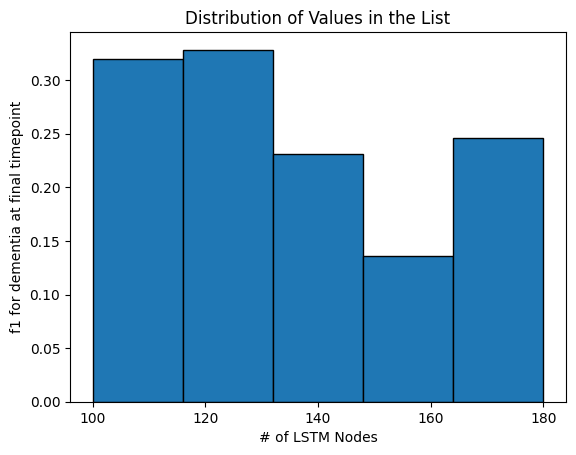

In [66]:
import matplotlib.pyplot as plt

plt.hist(range(1, len(dem_f1)+1), bins=len(dem_f1), weights=dem_f1, edgecolor='black', alpha=1)
plt.title('Hyperparameter tuning')
plt.xlabel('# of LSTM Nodes')
plt.ylabel('f1 for dementia at final timepoint')
plt.xticks(range(1, len(dem_f1) + 1), range(100, 100 + 20 * len(dem_f1), 20))
plt.show()